# M05_1_regressing_sentiment_scores_NH
A script that fits a regression model to predict sentiment scores on previously unseen data for New Hampshire. The metric by which I will decide which model fits best will be the MAE (mean absolute error), i.e. the average distance of a predicted label vs a real label. 

Before this can begin however, I will have to split the labelled data (and data to be labelled by the algorithm) into a Bernie and a Hillary set, as both require different regressors for each state (at least this is the theoretically consistent approach, in my eyes). Further, there will have to be a decision regarding what will be counted as a Bernie Sanders/HC tweet: the filter-derived addressee variable? the classifier-derived addressee variable? some function of both? 

For this purpose, the first step is to compare classified and assigned labels and come to some decision on how to subset the respective samples.

NL, 23/07/20  
NL, 24/07/20 -- updating with more comprehensive text pre-processing using spaCy

In [43]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

import spacy
import re

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from mord import LogisticAT

from joblib import dump, load

In [105]:
# in
LABELLED_TWEETS = "/Users/nikloynes/Desktop/SENTIMENT/data/labelled_tweets/fmtd_with_metadata/"
FULL_SAMPLE = "/Users/nikloynes/Desktop/SENTIMENT/data/classifications/"
TRAINED_MODELS = "/Users/nikloynes/Desktop/SENTIMENT/data/trained_models/"

# out
MODEL_TUNING_OUT = "/Users/nikloynes/Desktop/SENTIMENT/data/model_tuning_parameters/"
PREDICTIONS_OUT = "/Users/nikloynes/Desktop/SENTIMENT/data/data_with_predictions/"

## DATA IN

In [3]:
nh_train_df = pd.read_csv(LABELLED_TWEETS+'new_hampshire.csv', dtype = {'id' : 'str'})
nh_full_df = pd.read_csv(FULL_SAMPLE+'nh_addressee_classified.csv', dtype = {'id_str' : 'str'})

In [95]:
nh_full_df.head()

,id_str,text,bernie_mention,hillary_mention,addressee,preds_addressee,class_0,class_1,class_2,class_3,bernie_preds_log,bernie_preds_forest,hillary_preds_log,hillary_preds_forest
0,693269454881447936,@NHDems @iowademocrats @scdp #nhpolitics #iaca...,False,True,Hillary Clinton,1.0,0.000,0.996,0.004,0.000,5,6.54,8,5.477929
1,692950898134368256,@NHDems @SCdems #nhpolitics #iapolitics #iacau...,True,True,both,2.0,0.005,0.023,0.972,0.000,5,6.29,5,5.110595
2,692953880255152128,@NHDems @SCdems #nhpolitics #iapolitics #iacau...,True,True,both,2.0,0.005,0.023,0.972,0.000,5,6.29,5,5.110595
3,693064737748340736,The bros who love Bernie Sanders have become a...,True,True,both,0.0,0.825,0.109,0.044,0.022,6,6.66,7,5.674762
4,693261130333057024,RT @ABCLiz: Bill Clinton on what Hillary Clint...,False,True,Hillary Clinton,1.0,0.000,1.000,0.000,0.000,5,6.61,4,3.598500


In [4]:
bernie_train_df = nh_train_df[(nh_train_df['bernie_score'].notnull())]
bernie_train_df.head()

,id,text,bernie_score,hillary_score,addressee,timestamp,user_id,municipality,admin,county,ideology_bin,n_tweets,n_hillary,n_bernie,pop_norm,pop_quantiles
0,695344964755017728,Donald Trump and Bernie Sanders win the New Ha...,1.0,NaN,Bernie Sanders,2016-02-04 15:35:33,81126182,Durham,New Hampshire,United States,moderate,1,0,1,0.842397,4.0
2,694249917829750784,RT @jhutch1992: Let's be clear. This campaign ...,3.0,NaN,Bernie Sanders,2016-02-01 15:04:13,400255860,Concord,New Hampshire,United States,moderate,1,0,1,3.465415,4.0
4,696823971052920832,My predictions for #NH #FITN tomorrow: @Bernie...,0.0,NaN,Bernie Sanders,2016-02-08 17:32:35,28696353,Concord,New Hampshire,United States,liberal,1,0,1,3.465415,4.0
5,696084254535581696,RT @billyeichner: .@BernieSanders R u in the B...,0.0,NaN,Bernie Sanders,2016-02-06 16:33:13,2380466915,Temple,New Hampshire,United States,NaN,1,0,1,-0.398387,2.0
8,695459064910901248,RT @PolitiFact: Bernie Sanders says six bank c...,1.0,NaN,Bernie Sanders,2016-02-04 23:08:56,15013503,Concord,New Hampshire,United States,NaN,10,2,9,3.465415,4.0


In [94]:
len(nh_full_df)

18086

In [5]:
hillary_train_df = nh_train_df[(nh_train_df['hillary_score'].notnull())]
hillary_train_df.head()

,id,text,bernie_score,hillary_score,addressee,timestamp,user_id,municipality,admin,county,ideology_bin,n_tweets,n_hillary,n_bernie,pop_norm,pop_quantiles
1,696840745370529792,Hillary Clinton mulls a campaign staff shake-u...,NaN,-1.0,Hillary Clinton,2016-02-08 18:39:15,29599480,Concord,New Hampshire,United States,conservative,28,21,12,3.465415,4.0
3,696497445996359680,RT @MeninistTweet: Rt for puppy monkey baby\n\...,NaN,-2.0,Hillary Clinton,2016-02-07 19:55:06,3046904705,Newmarket,New Hampshire,United States,liberal,1,1,0,0.309324,4.0
6,694603988491210752,"""Hell yeah more like Hill yeah!"" @johnbfortesc...",NaN,3.0,Hillary Clinton,2016-02-02 14:31:10,320343568,Hampton,New Hampshire,United States,moderate,2,1,1,0.916440,4.0
7,696899637219708928,RT @peterdaou: The massive trolling operation ...,NaN,3.0,Hillary Clinton,2016-02-08 22:33:15,99775711,Concord,New Hampshire,United States,liberal,43,37,18,3.465415,4.0
14,692829438598352896,RT @Opter_: Fav for Hillary Clinton\nRT for Le...,NaN,-1.0,Hillary Clinton,2016-01-28 16:59:44,919483188,Concord,New Hampshire,United States,NaN,1,1,0,3.465415,4.0


In [7]:
len(bernie_train_df)

673

In [6]:
len(hillary_train_df)

398

We now have 2 datasets containing all the scores for both hillary and Bernie. To start off with, it'd be useful to get a grasp of the distribution of these scores. While I don't want to change the sampling here, as I think the distribution of scores is somewhat informative, it's still good to know. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a23bf8a20>]],
      dtype=object)

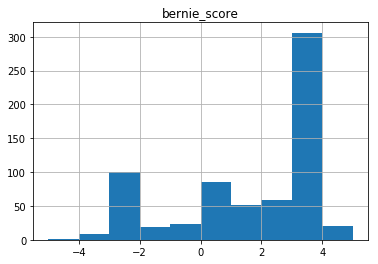

In [8]:
bernie_train_df.hist(column='bernie_score')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a23b09320>]],
      dtype=object)

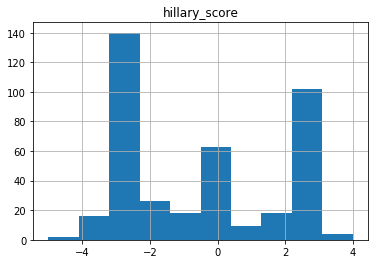

In [9]:
hillary_train_df.hist(column='hillary_score')

Let's normalise these scores, so that they are 0-10 instead of -5- +5

In [10]:
bernie_train_df['bernie_normalised_score'] = 5
bernie_train_df.loc[(bernie_train_df.bernie_score==-5), 'bernie_normalised_score'] = 0
bernie_train_df.loc[(bernie_train_df.bernie_score==-4), 'bernie_normalised_score'] = 1
bernie_train_df.loc[(bernie_train_df.bernie_score==-3), 'bernie_normalised_score'] = 2
bernie_train_df.loc[(bernie_train_df.bernie_score==-2), 'bernie_normalised_score'] = 3
bernie_train_df.loc[(bernie_train_df.bernie_score==-1), 'bernie_normalised_score'] = 4
bernie_train_df.loc[(bernie_train_df.bernie_score==0), 'bernie_normalised_score'] = 5
bernie_train_df.loc[(bernie_train_df.bernie_score==1), 'bernie_normalised_score'] = 6
bernie_train_df.loc[(bernie_train_df.bernie_score==2), 'bernie_normalised_score'] = 7
bernie_train_df.loc[(bernie_train_df.bernie_score==3), 'bernie_normalised_score'] = 8
bernie_train_df.loc[(bernie_train_df.bernie_score==4), 'bernie_normalised_score'] = 9
bernie_train_df.loc[(bernie_train_df.bernie_score==5), 'bernie_normalised_score'] = 10

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
hillary_train_df['hillary_normalised_score'] = 5
hillary_train_df.loc[(hillary_train_df.hillary_score==-5), 'hillary_normalised_score'] = 0
hillary_train_df.loc[(hillary_train_df.hillary_score==-4), 'hillary_normalised_score'] = 1
hillary_train_df.loc[(hillary_train_df.hillary_score==-3), 'hillary_normalised_score'] = 2
hillary_train_df.loc[(hillary_train_df.hillary_score==-2), 'hillary_normalised_score'] = 3
hillary_train_df.loc[(hillary_train_df.hillary_score==-1), 'hillary_normalised_score'] = 4
hillary_train_df.loc[(hillary_train_df.hillary_score==0), 'hillary_normalised_score'] = 5
hillary_train_df.loc[(hillary_train_df.hillary_score==1), 'hillary_normalised_score'] = 6
hillary_train_df.loc[(hillary_train_df.hillary_score==2), 'hillary_normalised_score'] = 7
hillary_train_df.loc[(hillary_train_df.hillary_score==3), 'hillary_normalised_score'] = 8
hillary_train_df.loc[(hillary_train_df.hillary_score==4), 'hillary_normalised_score'] = 9
hillary_train_df.loc[(hillary_train_df.hillary_score==5), 'hillary_normalised_score'] = 10

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### This is where spaCy comes in. I will try to pre-process all my text using it. 

In [14]:
nlp = spacy.load("en_core_web_sm")
nlp.tokenizer.token_match = re.compile(r"(#[A-Za-z0-9_]+|@[A-Za-z0-9_]+)").match

In [15]:
import re
def clean_text(text):
    text = re.sub(r"RT", "", text)
    text = text.lower()
    text = re.sub(r"&amp", "", text)
    text = text.strip(' ')
    return text

In [55]:
bernie_train_df.text[2]

"RT @jhutch1992: Let's be clear. This campaign is not about Bernie Sanders. This campaign is about the needs of the American people. #Caucus…"

In [56]:
# testing the lemmatization pipeline

test_text = "RT @jhutch1992: Let's be clear. This campaign is not about Bernie Sanders. This campaign is about the needs of the American people. #Caucus…"
test_text = clean_text(test_text)
test_text = nlp(test_text)
for token in test_text:
    if token.text=='sanders' or token.text=='berniesanders' or token.text=='@berniesanders' or token.text=="@sensanders":
        #add = token.text
        print('this is NOT lemmatized: '+token.text)
    elif token.is_punct==False and token.is_stop==False and token.like_url==False and token.is_space==False:
        #add = token.lemma_
        print('this is lemmatized: '+token.lemma_)

this is lemmatized: @jhutch1992:
this is lemmatized: let
this is lemmatized: clear
this is lemmatized: campaign
this is lemmatized: bernie
this is NOT lemmatized: sanders
this is lemmatized: campaign
this is lemmatized: need
this is lemmatized: american
this is lemmatized: people
this is lemmatized: #caucus…


In [17]:
bernie_cleaned_text = []

for text in bernie_train_df.text:
    text = str(text)
    text = clean_text(text)
    text = nlp(text) # tokenize
    # lemmatize:
    lemmatized = []
    for token in text:
        if token.text=='sanders' or token.text=='berniesanders' or token.text=='@berniesanders' or token.text=="@sensanders":
            lemmatized.append(token.text)
        elif token.is_punct==False and token.is_stop==False and token.like_url==False and token.is_space==False:
            lemmatized.append(token.lemma_)
    bernie_cleaned_text.append(' '.join(lemmatized))
    print(lemmatized)

['donald', 'trump', 'bernie', 'sanders', 'win', 'new', 'hampshire', 'primary', 'new', 'hampshire', 'kid', 'tuesday']
['@jhutch1992:', 'let', 'clear', 'campaign', 'bernie', 'sanders', 'campaign', 'need', 'american', 'people', '#caucus…']
['prediction', '#nh', '#fitn', 'tomorrow', '@berniesanders', 'low', 'predict', 'close', '@johnkasich', 'surprise']
['@billyeichner:', '.@berniesanders', 'r', 'u', 'beyhive']
['@politifact:', 'bernie', 'sanders', 'say', 'bank', 'company', 'asset', 'equal', '60', 'percent', 'u.s', 'gdp']
['snl', 'send', 'larry', 'david', 'bernie', 'sanders', 'bern', 'enthusiasm', '@mediaite']
['bernie', 'supporter', 'read', 'article', 'worth', 'tell', 'like']
['great', 'way', 'start', 'day', 'canvass', '@berniesanders', 'manchester', '#gotv', '#fitn', '#nhpolitics']
['@snopes:', 'rocky', 'horror', 'picture', 'bernie', 'jane', 'sanders', '1975', 'lgbt', 'march']
['@fpuniversity', 'get', 'ready', '#feelthebern', '@berniesanders']
['@anthonycumia:', 'crowd', '#bernie', 'sand

['@randpaul:', '.@berniesanders', 'ice', 'cream', 'flavor', '@benandjerrys.', 'demand', 'equal', 'time', '#demtownhall']
['@felicebelman:', 'madeleine', 'kunin', 'weigh', 'sanders', 'clinton', '@bostonglobe', '#fitn']
['@huffpostpol:', 'ben', 'jerry', 'co', 'founder', 'give', 'bernie', 'sanders', 'unofficial', 'ice', 'cream', 'flavor']
['@berniesspotify:', 'senator', 'bernie', 'sanders', 'currently', 'listen', 'pillowtalk', 'zayn']
['@yaboyberniesand:', 'new', 'hampshire', '=', 'new', 'history', 'revolution', '#feelthebern']
['marc', 'bow', 'want', '@berniesanders', 'answer', 'question', '#takeastand']
['@philipshelly:', '@berniesanders', 'say', 'thing', '@hillaryclinton', 'agree', 'like', '#demdebate']
['bernie', 'sanders', 'hoarse', '#fitn']
['@rldiculousness:', 'moment', 'realize', 'bernie', 'sanders', 'vote']
['read', 'thing', 'find', 'time', 'understand', 'hillary', 'clinton', 'neoliberal']
['@woridstarhiph0p:', 'moment', 'realize', 'bernie', 'sanders', 'vote']
['bernie', 'sanders

['@governorpataki:', 'terrific', 'rubio', 'speech', 'democrat', 'watching', 'know', 'crush', 'bernie', 'hillary', 'unite', 'america', 'let']
['@berniesanders:', 'chilly', 'new', 'hampshire', '#feelthebern', 'poll', 'tuesday', 'february', '9th']
['river', 'separate', 'bernie', 'sanders', 'state', 'primary']
['mum', '2', '@berniesanders', '#rallie', 'week', '#jealous', '#fitn']
['@sadieisonfire:', 'shut', 'mom', 'job', 'bernie', 'sanders', 'make', 'minimum', 'wage', '15', 'hour', 'u', 'suck']
['@berniesanders:', 'democrats', 'want', 'win', 'general', 'election', 'frankly', 'think', 'strong', 'candidate']
['@nealgoswami', '@berniesanders', 'pic', 'daughter', 'right', 'pic']
['@steakjones:', '@berniesanders', 'love']
['2', 'day', 'ahead', '#nh', '#fitn', 'primary', '@realdonaldtrump', '@berniesanders', 'strong', 'lead', 'respective', 'contest']
['@sensanders:', 'moral', 'responsibility', 'reduce', 'grow', 'gap', 'rich']
['@cnn:', '.@berniesanders', 'say', 'believe', 'generally', 'god', 'ne

['@voxdotcom:', 'bernie', 'sanders', 'propose', 'lot', 'new', 'taxis', 'add']
['@bernies_music:', 'bernie', 'sanders', 'like', 'troye', 'sivan']
['@psychicpebble:', 'hillary', 'clinton', 'insufferable', 'steal', 'bernie', 'big', 'talking', 'point', 'pretend', 'believe']
['#bernie2016', '@andrewmadore', 'm']
['@sensanders:', 'message', 'republican', 'worry', 'campaign', 'contribution', 'worry', 'child', 'grand']
['@hillaryclinton:', '2', 'want', 'real', 'progressive', '@berniesanders,', 'day', 'https']
['@futurehendrix52', '@lolyas_xo', 'bernie', 'sanders', 'democratic', 'runner']
['@hillaryclinton', '@sensanders', 'shade', 'necessary', 'team']
['.@berniesanders', 'win', 'new', 'hampshire', 'know', 'need', 'new', 'england', 'president', 'thing']
['@smerconish:', 'come', 'look', 'america', 'art', 'garfunkle', 'join', '@cnn', 'let', '@berniesanders', 'use', 'tune']
['@wolfofweedst:', '@berniesanders', '#droppedthemic', '#goldmansach', 'archaic', '#cannabis', 'hypocrisy', '#maddow', '#demd

['bernie', 'sanders', 'call', 'overturn', 'citizen', 'united', 'condemn', 'ben', 'jerry', 'political', 'speech', 'bueller']
['#repost', '@emjaybe95', 'repostapp', 'franklin', 'pierce', 'university', 'hold', 'awesome', 'bernie', 'sanders']
['@etrnlvista:', 'win', 'shift', 'position', 'call', '#pandering', '#berniesanders', 'lead', 'way', 'leader', '#union']
['@roseanndemoro:', 'want', 'parent', 'know', 'win', '#newhampshireprimary', 'tomorrow', 'goodjob!#feelthebern', '#millennialsforbernie', 'https']
['bernie', 'sniff', 'fart']
['stop', 'trail', '#nh', 'primary', 'packed', 'room', '#bedford', '@berniesanders', '#fitn']
['@people4bernie:', 'people', 'believe', '@berniesanders?', 'belief', '#feelthebern', '#iowacaucus']
['@berniesanders', 'debate', 'foreign', 'policy', 'basically', 'tell', 'people', 'educate', 'good', 'work']
['@phil_radford:', 'donate', '$', '1', '@berniesanders', 'retweet', '$', '200', '@benjealous', '@people4bernie', '@mmflint', '@anniemleonard', 'https']
['@publicthe

['@hillaryclinton', '@berniesanders', '@micastark', '@msnbc', 'bad', 'faculty', 'attend', 'debate', 'secondary', 'tix', 'shortage']
['@cnn:', '.@berniesanders', 'trounce', '@hillaryclinton', 'new', 'hampshire']
['fire', 'feelin', 'bern', '#notforsale', '#wearebernie', '#bernie2016', '#democracy']
['@sensanders:', 'united', 'states', 'ceos', '300', 'time', 'worker', 'simply', 'immoral', 'deal']
['@tvnewzted:', 'head', 'keene', 'nh', '@berniesanders', 'rally', 'ponder', '#wwsd', '@sharmantv']
['bernie', 'sanders', 'play', 'kill', 'fuck', 'marry', 'north', 'korea', 'russia', 'iran']
['agree', '@mmflint!', 'read', 'endorsement', 'bernie', 'sanders', 'right', '#feelinthebern']
['@berniesanders', 'oh', 'snap']
['@yaboyberniesand:', 'look', 'fam', 'win', 'let', 'tell', 'different', '#caucusforbernie', '#feelthebern']
['@berniesanders', 'compliment', '@tedcruz']
['@ajplus:', 'bernie', 'sanders', 'lead', 'hillary', 'clinton', 'iowa', '51%!to', '43%!among', 'iowa', 'democrats']
['@nbcsnl:', '@be

['@berniesanders:', 'chilly', 'new', 'hampshire', '#feelthebern', 'poll', 'tuesday', 'february', '9th']
['@berniesanders:', 'likelihood', 'wall', 'street', 'get', 'away', 'lot', 'illegal', 'behavior', 'know', '#fitn']
['@berniesanders']
['need', 'write', 'bernie', 'sanders', 'help', 'literary', 'agent', 'soon']
['@thebriefing2016:', 'hope', 'fun', 'club', '@berniesanders.', '#demdebate']
['#nh', 'voter', 'primary', 'vote', '#berniesanders', 'tomorrow', 'tuesday', 'primary', '#hillaryclinton', 'voter', 'wednesday']
['hillary', 'clinton', 'strategist', 'attack', 'bernie', 'sanders', 'anti', 'wall', 'street', 'ad', 'firm', 'work', 'wall', 'street']
['david', 'milliken', 'wait', 'ask', '#peoplespresidentialproject', 'question', 'u.s', 'senator', 'bernie', 'sanders', 'let']
['@berniesanders', 'shit', 'timeline']
['@robertsamuelson', 'claim', 'current', 'system', 'work', 'fine', '#nowecant', 'false', 'charm', 'bernie', 'sanders', 'single', 'payer', 'plan']
['@cnn:', '.@tommychong', 'say', 'w

['@foxnation', '@jessebwatter', '@berniesanders', 'young', 'folk', 'take', 'care', 'retirement', 'scary', 'socialist', 'school', 'fail']
['@berniesanders', '@hillaryclinton', 'big', 'business', 'raise', 'price', 'minimum', 'wage', 'increase']
['guess', '@berniesanders', 'plane', 'let', 'leave', 'time', '#fitn', '#nhpolitic']
['underway', '@vwarenanh!', 'await', 'presidential', 'candidate', '@berniesanders', '@hillaryclinton']
['@velcrofin', '2/2', 'bernie', 'sanders', 'maintain', 'position', 'endorse', 'bernie', '@realdonaldtrump', '@chgardens1', '@mitchellvii']
['@politico:', 'look', '@berniesanders', 'twitt', 'avatar']
['@drunk_america:', 'bernie', 'sanders', '2016']
['@collinrees:', 'bad', 'day', '100x', 'well', 'gop', 'candidate', '#berniesander', 'speak', 'truth', 'end', '#demdebate']
['@sensanders:', 'year', '2016', 'job', 'lift', 'americans', 'poverty', 'get', 'raise', 'minimum', 'wage']
['kendra', 'video', 'bernie', 'sanders', 'sailor', 'scout', 'costume', 'dance', 'sailor', 'm

In [18]:
hillary_cleaned_text = []

for text in hillary_train_df.text:
    text = str(text)
    text = clean_text(text)
    text = nlp(text) # tokenize
    # lemmatize:
    lemmatized = []
    for token in text:
        if token.text=='sanders' or token.text=='berniesanders' or token.text=='@berniesanders' or token.text=="@sensanders":
            lemmatized.append(token.text)
        elif token.is_punct==False and token.is_stop==False and token.like_url==False and token.is_space==False:
            lemmatized.append(token.lemma_)
    hillary_cleaned_text.append(' '.join(lemmatized))
    print(lemmatized)

['hillary', 'clinton', 'mull', 'campaign', 'staff', 'shake', 'new', 'hampshire', 'primary']
['@meninisttweet:', 'rt', 'puppy', 'monkey', 'baby', 'like', 'hillary', 'clinton']
['hell', 'yeah', 'like', 'hill', 'yeah', '@johnbfortescue', '#hillary2016', '#hillaryclinton']
['@peterdaou:', 'massive', 'trolling', 'operation', '#hillary', 'supporter', 'exceed', 'see', 'let', 'pretend', 'g']
['@opter_:', 'fav', 'hillary', 'clinton', 'leslie', 'knope']
['@igorvolsky:', 'potus', 'candidate', 'sunday', 'show', 'clinton', 'sanders', 'bush', 'trump', 'rubio', 'christie', 'kasich', 'carson', 'candidate', 'discusse']
['byah', 'bye', 'nh', 'hillary', 'head', 'michigan', 'sunday']
['@hillaryclinton:', 'new', 'dad', 'write', 'hillary', 'hope', 'family']
['@todayshow:', 'breaking', 'hillary', 'clinton', 'apparent', 'winner', 'democratic', '#iowacaucus', '#decision2016']
['@adirado29:', 'hillary', 'clinton', 'call', 'marco', 'rubio', 'abortion', 'comment', 'pretty', 'pathetic']
['@meninisttweet:', 'rt', '

['@ac360', '@davidaxelrod', 'spot', 'sanders', 'think', 'vote', 'kasich', 'tomorrow', 'instead', 'hillary']
['clinton', 'staffers', 'set', 'iowa', 'town', 'humboldt', 'ablaze', 'friday', 'stem', 'advance', 'bernie', 'sanders', 'volunteer']
['@dloesch:', 'trump', 'lay', 'foundation', 'party', 'help', 'hillary', 'clinton', 'immensely', 'coincidence', 'accident']
['@lord_gainz:', 'fuck', 'hillary', 'clinton', 'stick', 'benghazi', 'way', 'benghazi', 'fuck', 'hillary', 'clinton']
['@hillaryclinton', 'volunteer', 'ask', 'pic', 'street', 'primary', 'crazier', '#fitn']
['@nytimes:', 'hillary', 'clinton', 'old', 'feminist', 'supporter', 'message', 'young', 'woman', 'back', 'candidacy', 'shame']
['@governorpataki:', 'terrific', 'rubio', 'speech', 'democrat', 'watching', 'know', 'crush', 'bernie', 'hillary', 'unite', 'america', 'let']
['@berniesanders:', 'democrats', 'want', 'win', 'general', 'election', 'frankly', 'think', 'strong', 'candidate']
['@arielcberry:', 'see', 'hillary', 'clinton', 'pe

['@woridstarhiph0p:', 'rt', 'puppy', 'monkey', 'baby', 'like', 'hillary', 'clinton']
['hillary', 'clinton', 'fundraising', 'email', 'say', 'sanders', 'outspende', 'begs', 'supporter', '$', '1']
['@leecamp:', '.@nytimes', 'endorse', '#hillaryclinton', 'banner', 'ad', 'citibank', 'page', 'man', 'tell', 'something']
['@cnnpolitic', '@cnnmoney', 'reason', '#brianwilliams', 'believable', '#hillary']
['byah', 'bye', 'nh', 'hillary', 'head', 'michigan', 'sunday']
['@chelseahandler:', 'cap', 'explosion', 'feeling', 'liberal', 'backlash', 'hillary', 'clinton#go', 'girl']
['fbi', 'tell', 'hillary', '3', 'close', 'confidant', 'prepare', 'testify', 'oath', '@newsmax_media']
['@peddoc63:', 'pair', '✌', '🏽️hillary', 'know', 'tell', 'truth', 'bernie', 'think', '😬', '#feelthebern', '#nhprimary', '#pjnet', '#tcot']
['@hillaryclinton:', 'watch', 'live', 'hillary', 'speak', '#nhdems2016', 'dinner', 'manchester', '4', 'day', 'nh', 'primary', '→']
['bernie', 'sanders', 'open', '60', '33', 'lead', 'hillary'

['@mitchellvii:', 'donald', 'trump', 'hillary', 'clinton', 'indict', 'breitbart', '@breitbartnew']
['#democrats', '#manchester', '#newhampshire', '#feelthebern', '#berniesanders', '#hilaryclinton', '#fitn', '#nhprimary…']
['byah', 'bye', 'nh', 'hillary', 'head', 'michigan', 'sunday']
['@hillaryclinton', '#notonyourteam', '#hillarylies', '#notlikeyou;me']
['hillary', 'clinton', 'iowa', 'caucus', 'win', 'smell', 'need', 'audited', 'paper', 'shocker', 'lol']
['hilary', 'rock', 'nh', '#hillary2016', 'nashua', 'nh', 'rally']
['@opter_:', 'fav', 'hillary', 'clinton', 'leslie', 'knope']
['@motherjones:', 'prisoner', 'iran', 'come', 'fear', 'sound', 'hillary', 'clinton', 'voice']
['@kristinatuch:', 'y', 'hillary', 'clinton', 'thing']
['@jeffzeleny', '@berniesanders', '@hillaryclinton', 'dinner', 'hold', '10,000', 'seat', 'hockey', 'arena', 'usually', 'small', 'venue']
['@nytscience', '@nytime', 'hillary', 'clinton']
['@ezraklein', 'handle', 'hillary', 'clinton']
['ironic', 'hillary', 'clinton'

['@meninisttweet:', 'rt', 'puppy', 'monkey', 'baby', 'like', 'hillary', 'clinton']
['vote', 'bernie', 'hillary', 'november', 'meantime', 'article', 'important', '#feelthebern']
['@wgladstone:', 'hillary', 'clinton', 'brag', 'praise', 'henry', 'kissinger', 'understand', 'people', 'think', 'progre']
['@hillaryclinton:', 'heart', 'thank', 'iowa', '-h']
['say', 'donald', 'trump', 'hillary', 'clinton', '|', 'dana']
['@meninisttweet:', 'rt', 'puppy', 'monkey', 'baby', 'like', 'hillary', 'clinton']
['@hillaryclinton:', 'president', 'commander', 'chief', 'candidate', 'experience', 'judgment', 'plan', 'saf']
['@berniesanders', 'respect', 'u', 'hillary', 'clinton', 'pass', 'email', 'classified', 'info', 'lead', 'life', 'lose']
['@hillaryclinton:', 'say', 'bluster', 'chest', 'beating', 'strategy', 'defeat', 'terrorism', '#gopdebate']
['@dory:', 'hillary', 'clinton', 'late', 'message', 'youth']
['hillary', 'clinton', 'commitment', '2016', 'final', 'pitch', '@hillaryclinton']
['@hillaryclinton', 'n

Now, let's extract features from the tweet text for both models. 

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_bernie = TfidfVectorizer(sublinear_tf=True, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2), 
                        stop_words='english')

features_bernie = tfidf_bernie.fit_transform(bernie_cleaned_text)
labels_bernie = bernie_train_df.bernie_normalised_score
features_bernie.shape

(673, 6241)

In [20]:
tfidf_hillary = TfidfVectorizer(sublinear_tf=True, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2), 
                        stop_words='english')

features_hillary = tfidf_hillary.fit_transform(hillary_cleaned_text)
labels_hillary = hillary_train_df.hillary_normalised_score
features_hillary.shape

(398, 3811)

In [21]:
# instantiate models
model_linear = LinearRegression()
model_1vR = LogisticRegression(multi_class='ovr')
model_multi = LogisticRegression(multi_class='multinomial',
    solver='lbfgs')
model_ordinal = LogisticAT(alpha=0)  # alpha parameter set to zero to perform no regularisation
model_random_forest = RandomForestRegressor()

### Let's test all of these models

1. Bernie

In [22]:
MAE = make_scorer(mean_absolute_error)
folds = 10

print('Mean absolute error:' )
MAE_linear = cross_val_score(model_linear,
    features_bernie,
    labels_bernie,
    cv=folds,
    scoring=MAE)
print('Linear regression: ', np.mean(MAE_linear))
MAE_1vR = cross_val_score(model_1vR,
    features_bernie,
    labels_bernie,
    cv=folds,
    scoring=MAE)
print('Logistic regression (one versus rest): ', np.mean(MAE_1vR))
MAE_multi = cross_val_score(model_multi,
    features_bernie,
    labels_bernie,
    cv=folds,
    scoring=MAE)
print('Logistic regression (multinomial): ', np.mean(MAE_multi))
MAE_ordinal = cross_val_score(model_ordinal,
    features_bernie,
    labels_bernie,
    cv=folds,
    scoring=MAE)
print('Ordered logistic regression: ', np.mean(MAE_ordinal))
MAE_random_forest = cross_val_score(model_random_forest,
                                   features_bernie,
                                   labels_bernie,
                                   cv=folds,
                                   scoring=MAE)
print('Random Forest regressor: ', np.mean(MAE_random_forest))

Mean absolute error:
Linear regression:  1.6057377218629707


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be chan

Logistic regression (one versus rest):  1.890577815239972
Logistic regression (multinomial):  1.8589694495935731
Ordered logistic regression:  1.560733099209833


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

Random Forest regressor:  1.6871262768789108


2. Hillary

In [23]:
MAE = make_scorer(mean_absolute_error)
folds = 10

print('Mean absolute error:' )
MAE_linear = cross_val_score(model_linear,
    features_hillary,
    labels_hillary,
    cv=folds,
    scoring=MAE)
print('Linear regression: ', np.mean(MAE_linear))
MAE_1vR = cross_val_score(model_1vR,
    features_hillary,
    labels_hillary,
    cv=folds,
    scoring=MAE)
print('Logistic regression (one versus rest): ', np.mean(MAE_1vR))
MAE_multi = cross_val_score(model_multi,
    features_hillary,
    labels_hillary,
    cv=folds,
    scoring=MAE)
print('Logistic regression (multinomial): ', np.mean(MAE_multi))
MAE_ordinal = cross_val_score(model_ordinal,
    features_hillary,
    labels_hillary,
    cv=folds,
    scoring=MAE)
print('Ordered logistic regression: ', np.mean(MAE_ordinal))
MAE_random_forest = cross_val_score(model_random_forest,
                                   features_hillary,
                                   labels_hillary,
                                   cv=folds,
                                   scoring=MAE)
print('Random Forest regressor: ', np.mean(MAE_random_forest))

Mean absolute error:
Linear regression:  1.948157566539723
Logistic regression (one versus rest):  2.147599657866025


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be chan

Logistic regression (multinomial):  2.030375916694916
Ordered logistic regression:  1.846346153846154


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

Random Forest regressor:  1.901557130113267


## It appears that we should proceed with the ordered logistic regression model for Bernie, and the random forest model for Hillary

Now to tune the parameters and select the best model.  
I also choose to further explore the random forest model for bernie, just as it provides more tuning options than the log model.

In [24]:
bernie_param_grid_LOG = [
    {'alpha': [0.1, 0.5, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
]

hillary_param_grid_LOG = [
    {'alpha': [0.1, 0.5, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
]


bernie_param_grid_FOREST = [
    {'n_estimators': [100, 150, 200, 300, 400, 500, 1000], 
     'max_features': [10, 20, 30, 40, 50, 60, 70, 100, 150, 200, 250, 300, 350, 400, 450, 500, None]}
]

hillary_param_grid_FOREST =  [
    {'n_estimators': [100, 150, 200, 300, 400, 500, 1000], 
     'max_features': [10, 20, 30, 40, 50, 60, 70, 100, 150, 200, 250, 300, 350, 400, 450, 500, None]}
 ]

In [25]:
# bernie tuning LOG
bernie_model_log = GridSearchCV(estimator=model_ordinal,
                               param_grid=bernie_param_grid_LOG,
                               scoring=MAE,
                               cv=10)

bernie_model_log.fit(features_bernie, labels_bernie)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticAT(alpha=0, max_iter=1000, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [0.1, 0.5, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error), verbose=0)

In [57]:
bernie_model_log_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.547701,0.018400,0.000341,0.000009,0.1,{'alpha': 0.1},1.250000,1.397059,1.500000,1.611940,...,0.095868,0.099010,0.099010,0.100660,0.095710,0.100660,0.094059,0.090759,0.097408,0.003392
1,0.374289,0.025532,0.000362,0.000032,0.5,{'alpha': 0.5},1.279412,1.411765,1.470588,1.686567,...,0.236364,0.244224,0.249175,0.270627,0.232673,0.222772,0.235974,0.252475,0.244511,0.012740
2,0.540054,0.021684,0.000345,0.000016,0.1,{'alpha': 0.1},1.250000,1.397059,1.500000,1.611940,...,0.095868,0.099010,0.099010,0.100660,0.095710,0.100660,0.094059,0.090759,0.097408,0.003392
3,0.416496,0.033197,0.000357,0.000037,0.2,{'alpha': 0.2},1.220588,1.397059,1.500000,1.641791,...,0.138843,0.136964,0.133663,0.141914,0.138614,0.135314,0.130363,0.133663,0.137033,0.003518
4,0.390882,0.030252,0.000340,0.000004,0.3,{'alpha': 0.3},1.205882,1.426471,1.500000,1.626866,...,0.175207,0.171617,0.179868,0.186469,0.165017,0.161716,0.160066,0.169967,0.171869,0.008394
5,0.387937,0.038743,0.000342,0.000013,0.4,{'alpha': 0.4},1.250000,1.426471,1.485294,1.671642,...,0.216529,0.221122,0.219472,0.226073,0.202970,0.196370,0.204620,0.212871,0.212813,0.009517
6,0.371220,0.037170,0.000339,0.000006,0.45,{'alpha': 0.45},1.235294,1.426471,1.500000,1.671642,...,0.224793,0.229373,0.232673,0.252475,0.212871,0.206271,0.219472,0.234323,0.227506,0.012316
7,0.373310,0.026446,0.000362,0.000041,0.5,{'alpha': 0.5},1.279412,1.411765,1.470588,1.686567,...,0.236364,0.244224,0.249175,0.270627,0.232673,0.222772,0.235974,0.252475,0.244511,0.012740
8,0.376995,0.021923,0.000340,0.000007,0.6,{'alpha': 0.6},1.279412,1.426471,1.470588,1.701493,...,0.261157,0.277228,0.273927,0.298680,0.267327,0.275578,0.259076,0.278878,0.276045,0.011391
9,0.379753,0.055242,0.000365,0.000032,0.7,{'alpha': 0.7},1.279412,1.426471,1.500000,1.716418,...,0.295868,0.306931,0.305281,0.326733,0.297030,0.311881,0.278878,0.308581,0.305432,0.012093


In [26]:
bernie_model_log_results_df = pd.DataFrame(bernie_model_log.cv_results_)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

In [27]:
bernie_model_log.best_score_

1.534918276374443

In [58]:
bernie_model_log.best_estimator_

LogisticAT(alpha=0.9, max_iter=1000, verbose=0)

In [30]:
bernie_final_model_log = bernie_model_log.best_estimator_

In [45]:
# save model using jobli
dump(bernie_final_model_log, TRAINED_MODELS+'bernie_final_model_log.joblib') 

['/Users/nikloynes/Desktop/SENTIMENT/data/trained_models/bernie_final_model_log.joblib']

In [33]:
# bernie tuning forest
bernie_model_forest = GridSearchCV(estimator=model_random_forest,
                                  param_grid=bernie_param_grid_FOREST,
                                  scoring=MAE,
                                  cv=10)

bernie_model_forest.fit(features_bernie, labels_bernie)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [100, 150, 200, 300, 400, 500, 1000], 'max_features': [10, 20, 30, 40, 50, 60, 70, 100, 150, 200, 250, 300, 350, 400, 450, 500, None]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error), verbose=0)

In [34]:
bernie_forest_model_results_df = pd.DataFrame(bernie_model_forest.cv_results_)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

In [35]:
bernie_model_forest.best_score_

1.6708260732993274

In [36]:
bernie_final_model_forest = bernie_model_forest.best_estimator_

In [46]:
# save model using joblib
dump(bernie_final_model_forest, TRAINED_MODELS+'bernie_final_model_forest.joblib') 

['/Users/nikloynes/Desktop/SENTIMENT/data/trained_models/bernie_final_model_forest.joblib']

In [37]:
# hillary tuning log
hillary_model_log = GridSearchCV(estimator=model_ordinal,
                                param_grid=hillary_param_grid_LOG,
                                scoring=MAE,
                                cv=10)

hillary_model_log.fit(features_hillary, labels_hillary)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticAT(alpha=0, max_iter=1000, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [0.1, 0.5, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error), verbose=0)

In [38]:
hillary_model_log_results_df = pd.DataFrame(hillary_model_log.cv_results_)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

In [39]:
hillary_model_log.best_score_

1.9698492462311559

In [40]:
hillary_final_model_log = hillary_model_log.best_estimator_

In [47]:
# save model using joblib
dump(hillary_final_model_log, TRAINED_MODELS+'hillary_final_model_log.joblib') 

['/Users/nikloynes/Desktop/SENTIMENT/data/trained_models/hillary_final_model_log.joblib']

In [42]:
# hillary tuning forest
hillary_model_forest = GridSearchCV(estimator=model_random_forest,
                                   param_grid=hillary_param_grid_FOREST,
                                   scoring=MAE,
                                   cv=10)

hillary_model_forest.fit(features_hillary, labels_hillary)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [100, 150, 200, 300, 400, 500, 1000], 'max_features': [10, 20, 30, 40, 50, 60, 70, 100, 150, 200, 250, 300, 350, 400, 450, 500, None]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error), verbose=0)

In [48]:
hillary_forest_model_results_df = pd.DataFrame(hillary_model_forest.cv_results_)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

In [49]:
hillary_model_forest.best_score_

2.0202625966430108

In [50]:
hillary_final_model_forest = hillary_model_forest.best_estimator_

In [51]:
# save model using joblib
dump(hillary_final_model_forest, TRAINED_MODELS+'hillary_final_model_forest.joblib') 

['/Users/nikloynes/Desktop/SENTIMENT/data/trained_models/hillary_final_model_forest.joblib']

## Having trained these models - with improved accuracy from the model selection round - it is now time to predict values on the unseen data

First, clean the text in the full sample using the cleaning pipeline used on the training data

In [63]:
full_cleaned_text = []

for text in nh_full_df.text:
    text = str(text)
    text = clean_text(text)
    text = nlp(text) # tokenize
    # lemmatize:
    lemmatized = []
    for token in text:
        if token.text=='sanders' or token.text=='berniesanders' or token.text=='@berniesanders' or token.text=="@sensanders":
            lemmatized.append(token.text)
        elif token.is_punct==False and token.is_stop==False and token.like_url==False and token.is_space==False:
            lemmatized.append(token.lemma_)
    full_cleaned_text.append(' '.join(lemmatized))
    print(lemmatized)

['@nhdem', '@iowademocrats', '@scdp', '#nhpolitics', '#iacaucus', '#iapolitic', '#scpolitic', '#hillary2016', '#hillaryclinton', '#hillary']
['@nhdems', '@scdem', '#nhpolitics', '#iapolitics', '#iacaucus', '#scpolitics', '#hillaryclinton', '#hillary', '#berniesander', '#bernie']
['@nhdems', '@scdem', '#nhpolitics', '#iapolitics', '#iacaucus', '#scpolitics', '#hillaryclinton', '#hillary', '#berniesander', '#bernie']
['bro', 'love', 'bernie', 'sanders', 'sexist', 'mob', '@mashable', '#imwithher', '#hillary2016', '#nhpolitics']
['@abcliz:', 'bill', 'clinton', 'hillary', 'clinton', 'need', '76', 'hrs', 'fight', 'dog', 'fight', 'fight']
['@jazzshaw:', 'wow', 'morning', 'joe', 'crew', 'actually', 'discuss', 'seriously', 'democrats', 'hillary', 'clinton', 'indict']
['@cnnbrk:', 'state', 'department', 'say', 'will', 'release', '22', 'email', 'hillary', 'clinton', 'contain', 'secret', 'information']
['@hillaryclinton']
['@bernie_sanders_:', 'robert', 'reich', 'know', 'hillary', '19', '#berniesa

['@dailyhillary:', 'new', 'ppp', 'iowa', 'poll', 'hillary', 'clinton', '48', 'sanders', '40', "o'malley", '7', '#imwithher', '#hillary2016']
['@abbyabrams:', 'hillary', 'clinton', 'get', 'lilly', 'ledbetter', 'endorsement', 'fair', 'pay', 'act', 'anniversary']
['@jeanettejing:', 'proud', 'walmart', '#hillary2016,', 'walmart', 'board', 'member', '1986', '1992']
['@opter_:', 'fav', 'hillary', 'clinton', 'leslie', 'knope']
['thankfully', '#hillary2016', '#imwithher', '#nhpolitics', '#fightforhillary']
['prove', '#imwithher', '#hillary2016']
['halperin', 'white', 'house', 'buzz', 'fbi', 'investigation', 'hillary', 'clinton', '@weeklystandard']
['lilly', 'ledbetter', 'endorse', 'hillary', 'clinton', '#imwithher', '#hertoo', 'fight', '#equalpay', '#nhpolitics']
['@hillaryclinton', 'lie', '#benghazi', '-lie', 'secret', 'email', 'server', '-lie', '#juanitaboraddrick', 'damned', 'liar', '#nhpolitics', '#fitn']
['@tomwatson:', 'huh', 'enthusiasm', 'hillary', 'tell', 'nyt']
['@freespeak3:', '.@ho

['@peterdaou:', 'emphatic', 'advocacy', '@hillaryclinton', 'easily', 'explain', 'daughter', 'adviser', 'trust', '#hillary']
['@die__trying_:', 'ted', 'danson', 'road', 'nh', 'today', 'hillary', 'clinton', '#hillary2016', '#nhpolitic', '#fitn']
['hillary', 'get', 'help', 'nh', '#imwithher', '#hillary2016']
['@wayneedh:', 'magic', 'johnson', 'say', '#imwithher', 'endorse', '#hillary2016', 'prez', 'vote', 'hrc', 'super', 'slam', 'dunk', 'america']
['@hillaryclinton', '@thebetternathan', '@cindyr33d', 'hillary', 'bot', 'account', 'natalia', 'evans', 's.l.p', 'caslpo', 'canadian', 'pathologist', 'photo']
['@opter_:', 'fav', 'hillary', 'clinton', 'leslie', 'knope']
['@hillaryclinton:', 'campaign', '100', 'amazing', 'photo']
['@tvkatesnow:', '49%!of', 'americans', 'recently', 'say', 'believe', 'hillary', 'clinton', 'tell', 'truth', 'come', 'email', 'report']
['@politics1com:', 'hillary', 'clinton', 'email', 'scandal', 'heat', 'state', 'dept', 'declare', '22', 'private', 'server', 'email', 'se

['cia', 'operative', 'valerie', 'plame', 'campaign', 'behalf', 'hillary', 'clinton']
['@dloesch', '@ap', 'hillary', 'clinton', 'belong', 'prison', 'president', 'obama']
['@hal_flc:', 'clinton', 'campaign', 'engage', 'bad', 'panicky', 'tactic', 'knock', 'feather']
['@davidsirota:', 'clinton', 'get', '$', '13.2', 'm', 'health', 'industry', 'campaign', 'cash', 'declare', 'medicare', 'come', 'pass', 'https']
['@nhdem', '@iowademocrats', '@scdp', '#nhpolitics', '#iacaucus', '#iapolitic', '#scpolitic', '#hillary2016', '#hillaryclinton', '#hillary']
['@realdonaldtrump:', 'hillary', 'clinton', 'major', 'national', 'security', 'risk', 'presidential', 'material']
['view', 'john', 't.', 'broderick', 'jr', 'history', 'hillary', 'clinton', 'meet', 'hillary', 'clinton', 'early', 'october']
['@hillaryclinton', 'hillary', 'decrepit', 'corrupt', 'filthy', 'liar']
['disturb', '$', 'spend', '@hillaryclinton']
['@asmmelendez:', 'job', 'u.s', 'navy', 'classify', 'face', 'court', 'martial', 'handle', 'like'

['cap', 'explosion', 'feeling', 'liberal', 'backlash', 'hillary', 'clinton', '#ditto', '#imwithher']
['@hillaryclinton:', '40-year', 'record', 'progressive', 'result', 'boil', 'day']
['@hillaryclinton', 'bs', 'hillary', 'know', 'go', 'care', 'insurer', 'banker', 'mean', 'raise', 'peasant']
['@petermellinger:', 'great', '@joshuabourdonnh', 'join', 'today', '#fitn', '#nhpolitics', '#hillary2016', '#imwithher']
['cap', 'explosion', 'feeling', 'liberal', 'backlash', 'hillary', 'clinton']
['@retiredfirecapt:', 'ed', 'klein', 'hillary', 'feel', 'bern', 'fbi', 'director', 'james', 'comey']
['hillary', 'clinton', 'elect', 'president', 'happen', 'u.s', 'economy']
['@hillaryclinton', 'win', 'iowa', 'razor', 'thin', 'pinhead', 'win', '@sensanders', '#iowacaucus']
['watch', 'colbert', 'explain', 'broncos', 'draft', 'hillary', 'clinton', 'super', 'bowl']
['@hillaryclinton', 'derry', 'skip', 'nh', 'primary', 'event', 'like', 'chance', 'case', '#hillaryinnh']
['@hillaryclinton', 'say', 'say', 'skip',

['@hillaryclinton:']
['@wmur9:', 'hillary', 'clinton', 'win', 'iowa', 'coin', 'flip']
['@hillaryclinton', 'hardly', 'progressive', 'support', 'major', 'bank', 'approve', 'subsidy', 't', 'continue', 'private', 'health', 'insurance', 'scam']
['@hillaryclinton:', '2', 'want', 'real', 'progressive', '@berniesanders,', 'day', 'https']
['@liberalmormon', '@kaijuking23', '@berniesanders', '@hillaryclinton']
['@hillaryclinton:', '2', 'want', 'real', 'progressive', '@berniesanders,', 'day', 'https']
['@hillaryclinton:', '40-year', 'record', 'progressive', 'result', 'boil', 'day']
['@naral', '@erahaxhiu', '@hillaryclinton']
['@hillaryclinton:', '2', 'want', 'real', 'progressive', '@berniesanders,', 'day', 'https']
['@hillaryclinton:', '3', 'important', 'progressive', 'make', 'progress', 'health', 'care', 'fight', 'inequality', 'hillary', 'reco']
['@thinkingofmoney:', 'currently', 'read', 'ed', 'klein', 'hillary', 'feel', 'bern', 'fbi', 'director', 'james', 'comey', 'omg', 'thi']
['@gdeanleigh:',

['@correctrecord:', '.@hillaryclinton', 'lifelong', 'champion', 'middle', 'class', '#demtownhall']
['@mauriciod44:', 'indict', 'woman', '@hillaryclinton', 'ed', 'klein', 'hillary', 'feel', 'bern', 'fbi', 'director', 'james', 'comey', 'https']
['@marianne_m_b:', 'fbi', 'criminal', 'investigation', 'hillary', 'clinton', 'espionage', 'corruption', '@grtvne…']
['coverage', 'bernie', 'sanders', 'hillary', 'clinton', 'town', 'hall', 'derry', 'plus', 'interview', 'carly', 'fiorina', '@11', 'shelle']
['@hillaryclinton:', 'historic', 'win', 'iowa', 'caucus', 'hillary', 'accomplish', 'woman']
['@seiu:', '.@seiu', 'help', '@hillaryclinton', 'win', 'iowa', 'fire', 'nh', 'nv', 'find', 'force', '#hillye']
['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics', '#hillary2016', '#hillaryclinton', '#hillary', 'g']
['@realjameswoods:', 'break', 'hillary', 'clinton', 'spy', 'life', 'risk', '|', '|', 'observer']
['@bms_thadcastle:', 'vote', '◻️', 'hillary', 'clin

['@hillaryclinton:', '4', 'hillary', 'run', 'point', 'run', 'difference', 'feel', 'free', 't']
['@barbaraboxer:', 'hillary', 'progressive', 'day', 'bernie', 'democrat', 'day']
['#berniesanders', 'comment', 'low', 'blow', 'say', '#clinton', 'know', 'record', 'wholly', '#moderate.', '#nohill']
['@hillaryclinton?', '@potus?', 'fyi', '@tabsonobama!', '#ia', '#nh']
['barack', 'obama', 'endorse', 'hillary', 'clinton', 'carry', 'legacy', '#imwithher', '#hillary2016']
['@pamelakealer13:', 'hillary', 'clinton', 'send', 'classified', 'information', 'ted', 'cruz', 'know', 'staff', 'lie', 'caucus', 'goer']
['consider', 'barack', 'obama', 'corrupt', '#imwithher', '#hillary2016']
['@hillaryclinton:', '4', 'hillary', 'run', 'point', 'run', 'difference', 'feel', 'free', 't']
['hillary', 'clinton', 'history']
['@teddydaviscnn:', 'brady', 'campaign', 'back', 'clinton', 'seize', 'bernie', 'gun', 'vote', 'aid', 'hillary', 'debate', 'real', 'progressive', 'http']
['oh', 'love', 'god', 'washington', 'post',

['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics', '#hillary2016', '#hillaryclinton', '#hillary']
['@hillaryclinton:', 'chance', 'build', 'progress', 'result', 'people', 'goal', 'hillary', '#demtow…']
['@hillaryclinton', 'flawless', '#demtownhall', 'honest', 'thoughtful', 'positive', 'clearly', 'ready', 'shatter', 'glass', 'ceiling', '#imwithher', '#fitn']
['soros', 'fund', 'management', 'hillary', 'clinton', 'big', 'contributor', '#nhpolitics', '#fitn', '#demtownhall', '#tcot']
['@alisonspalding2:', 'lose', 'money', 'bailout', 'hillary', 'speak', 'gt;&gt;&gt;&gt;a', 'clinton', 'everybody', 'get', 'screw', '#weendorsebe…']
['@hillaryclinton', 'adopt', 'sanders', 'agenda']
['@timalberta:', 'hillary', 'clinton', 'say', 'worry', 'optic', 'take', '$', '675k', 'goldman', 'speeches', 'b', 'c', 'sure', 'run', 'p']
['@hillaryclinton:', 'somebody', 'actually', 'want', 'produce', 'real', 'result', 'people', 'life', 'progressive', 'get', 'result', '

['@mccollummike:', 'bbc', 'news', 'bernie', 'sanders', 'supporter', 'bad', 'reputation', 'online']
['@sensanders:', 'gender', 'wage', 'gap', 'lifelong', 'effect', 'average', 'yearly', 'social', 'security', 'income', 'receive', 'woman', '$', '12,857', 'compare', 't']
['@infamousgrace_', 'forgot', 'write', 'op', 'ed', 'piece', '#bernie,', '#bernie', '#feelthebern', '#nh', '#iowacaucus']
['retweet', 'viral', 'r', 'emotional', '@susansarandin', 'exactly', 'right.thank', '#wearebernie']
['bernie', 'sanders', 'chance', '@youtube']
['@wildpowers:', '#bernie', '@senwarren', 'agree', 'glass', 'steagall', 'issue', '#hillary', 'say', 'greed', 'pragmatic', '#uniteblue', '#blm', '#latinos', 'https:/']
['@berniesanders', 'word', 'pundit', 'plural', 'pundit', 'pundint']
['like', '@youtube', 'video', 'rand', 'paul', 'scary', 'people', 'want', 'vote', 'bernie', 'sanders', 'siriusxm']
['@shareefjackson:', 'twitter', 'bernie', 'sanders', 'supporter', 'big', 'problem']
['@berniesanders']
['@mikesldy6969:'

['attack', 'senator', 'shaheen', '#nhpolitics', 'bro', 'love', 'bernie', 'sanders', 'sexist', 'mob', '@mashable']
['@50th_president', '@wnc4bernie', '#janesander', 'grace;compassion', '-her', 'hug', 'cocoon', 'lift', 'weight', 'fear', '#bernie2016', '#feelthebern']
['ironic', 'bernie', 'sanders', 'top', 'rival', 'use', 'outside', 'money']
['@sensanders:', 'unacceptable', 'united', 'states', 'percent', 'world', 'population', '25', 'percent', 'world', 'p']
['bernie', 'brink', 'late', 'new', 'hampshire', 'number', 'reveal', 'national', 'trend', '#feelthebern']
['@nhkathysullivan:', 'ironic', 'bernie', 'sanders', 'top', 'rival', 'use', 'outside', 'money']
['@todayshow:', 'involve', 'senior', 'boxing', '@berniesanders', 'joke', '@mitchellreport', 'release', 'medical', 'report', 'https:/']
['ok', 'fear', 'subside', 'gain', 'w', 'risk', '@berniesanders', 'well', 'prospect', 'change', 'well']
['@sensanders:', 'end', 'disgrace', 'woman', 'make', '79', 'cent', 'dollar', 'compare', 'man', 'go', '

['bernie', 'sanders', 'presidential', 'candidate', 'oppose', 'fracke']
['@bellenaturellez', '@yamiche', '@deray', '@berniesanders', 'lt;double', 'facepalm&gt']
['@jack_welch:', 'watch', 'angry', 'martha', 'raddatz', 'interview', 'ben', 'carson', 'friendly', 'raddatz', 'interview', 'bernie', 'sanders', 'perfect', 'medium', 'bias', 'example']
['@mwphnh', '@business', 'yeah', 'bet', 'jew', 'brooklyn', '@berniesanders', 'anti', 'semite', 'like', 'anti', 'fraud']
['@berniesanders', 'speak', 'peterborough', 'nh', '#solar', '#wind', '#climate', '#pipelines', '#stopned', '#saveourfuture']
['@mtaibbi:', 'erica', 'garner', 'write', 'impassioned', 'endorsement', 'bernie', 'samder']
['@sensanders:', '15', 'african', 'american', 'man', 'incarcerate', 'compare', '106', 'white', 'man', 'unacceptable']
['@olivianuzzi:', 'foster', 'people', 'casually', 'stroll', 'bernie', 'sanders', 'iowa', 'hq', 'perform', 'event', 'toni']
['pop', 'back', 'bernie', 'sanders', 'prez']
['@mtaibbi:', 'erica', 'garner', '

['@nydailynews:', 'eric', 'garner', 'daughter', 'endorse', '@berniesanders', 'president']
['bernie', 'sanders', 'health', 'care', 'plan', 'cost', 'middle', 'class', 'politifact']
['@livingonchi:', 'bernie', 'sanders', 'beast', 'bold', 'leadership', '@youtube', '#feelthebern', '@berniesanders', '#bernie2016']
['mouth', 'wreck', 'terrible', 'candidate', '@berniesanders', 'option', 'salvation', 'well', 'prospect']
['@yamiche:', '.@berniesanders', 'burlington', 'iowa', 'tonight', 'come', 'vote', 'let', 'change', 'america']
['@_feel_the_bern_', 'board', 'america', 'chance', 'salvation', '@berniesanders', '@sensanders', '@gopisdead']
['@chriswalloch:', 'study', 'bernie', 'sanders', 'single', 'payer', 'plan', 'twice', 'expensive', 'say', '@voxdotcom']
['happen', 'bernie', 'sanders', 'win', 'iowa', '#politic', '#feedly']
['@susansarandon:', '.@elizadushku', 'speak', 'lgbt', '@berniesanders', 'stand', 'gay', 'right', '30', 'yrs', 'wait', 'u']
['@velcrofin', '2/2', 'bernie', 'sanders', 'maintain

['@puttcarp:', 'mt', '@criticl_me', 'unravelling', '@berniesanders', '#msm', 'blackout', '#freepress', '#feelthebern']
['@moveon:', 'message', '@berniesanders', 'skeptic', '@robertreich', '#feelthebern', '#politicalrevolution']
['@kujo71:', 'bernie', 'win', 'week', 'social', 'medium', 'politico', '#feelthebern', '#berniesanders']
['bernie', 'sanders', 'bum', 'want', 'money']
['@puttcarp:', 'endorsement', 'plenty', 'clue', 'sen', '@elizabethwarren', '#sanderswarren2016', '#dreamteam', '#u…']
['@sensanders:', 'outrage', 'million', 'parent', 'force', 'work', 'income', 'stay', 'home']
['@berniesanders', 'lead', 'movement', 'board', 'wearebernie', '#telleveyoneyouknow']
['@politico:', 'bernie', 'sanders', 'electability', 'problem', '|', 'ap', 'photo']
['@mwphnh', '@berniesanders', '@hillaryclinton', '@mikebloomberg', '@billclinton', 'wall', 'street', 'control', '@gop,', 'get']
['@shadz6ty6:', '#wearebernie', "#bernie'll", 'ask', 'key', 'question', '#hrc', '#trump/#gopdebate', 'loon', '#feel

['@wi4bernie:', 'debate', 'medicare', 'system', 'good', 'nation', 'health', 'doctor', '#feelthebern', '#bernieis…']
['#nhpolitics', '#iapolitics', '#iacaucus', '#scpolitics', '#hillaryclinton', '#hillary', '#berniesander', '#bernie']
['ok', 'ready', 'trump', 'sanders', 'cruz', 'whackjob', 'run', 'president']
['@cherijacobus:', 'donald', 'trump', 'retweets', 'creator', 'pic', 'show', 'bernie', 'sanders', 'send', 'gas', 'chamber', '@jdforward']
['@cuntmeout:', 'bernie', 'sanders', 'defend', 'child', 'molester', 'vote', 'amber', 'alert', 'bill', 'question', 'walk', 'away', 'https:/']
['@l4nguyen:', 'share', 'stage', 'tonight', 'iowa', '@stonewalldem', '#proudtocaucus', '@berniesanders', '#wearebernie']
['@2dmonds1pistol:', '#lucyflores', 'endorse', '#berniesanders', 'las', 'vegas', 'march', '#integrity']
['@ryansiskow:', '#gay', '#selfemployed', 'guy', 'live', '#iowa', 'accord', '@berniesanders,', '#establishment', '#imwithhe…']
['gop', 'official', 'publicly', 'denounce', 'bernie', 'sande

['.@clairecmc', 'comment', '#bernie2016', 'show', 'need', 'backfire', 'ha', '#feelthebern']
['@thesolarspirit:', '🔥', '#wearebernie', '🔥', 'want', 'new', 'deal', 'restore', '#bernieorbust', '#feelthebern']
['favorite', '#snl', 'political', 'impression', '@nbcsnl', '@sarahpalinusa', '@hillaryclinton', '@berniesanders']
['@jaclynkellye:', 'sense', '@berniesanders', 'sentiment', 'widely', 'feel', '#wearebernie']
['watch', 'porn', 'suddenly', 'bernie', 'sanders', 'ad', 'start', 'play']
['@matthewraskob:', '#berniesanders', 'fly', 'coach', 'anymore', 'negative', 'campaigning']
['@mahamosa:', '.@berniesanders', 'project', 'confidence', '#iowa', 'abc', 'news', '@abc', '#wearebernie', '#feelthebern', '#council…']
['@berniesanders:', '@hillaryclinton', 'say', 'dem', 'look', 'candidate', 'electable', 'agree', 'jeff', 'weaver', 'http']
['@birdieglad:', 'hello', 'absolutely', 'comparison2', 'bernie', 'sanders', 'president', 'obama', 'whatsoever', '@potus.', 'https']
['@jaydecuomo', '@sensanders', 

['@randyrenstrom:', 'big', 'question', '@berniesanders', '#iacaucus:', 'delegate', 'haul', 'limit', 'geography']
['#alaskadispatchnews', 'poll', '#berniesanders:', '47.5', '#hillaryclinton:', 'pzjue5onug']
['@dilemmv:', 'apparently', 'lack', 'enthusiasm', 'sanders', 'world', 'rainbow', 'puppy', 'call', 'diversity', 'bernie']
['@facethenation:', 'ask', 'democrats', 'get', 'cbs', 'news', 'battleground', 'tracker', 'say', '@berniesanders.']
['@voxdotcom:', 'tax', 'code', 'look', 'like', 'bernie', 'sanders', 'get', 'want']
['@sensanders:', 'message', 'republican', 'worry', 'campaign', 'contribution', 'worry', 'child', 'grand']
['@nd4bernie:', '@moforbernie', '@berniesanders', 'let', 'damn', 'sure', 'mccaskill', 'get', 'boot', 'omg', 'quote', 'bernie', '👹', '😡', '😡', '😡', '😡', '😡', '😡', '😡', '😡']
['@its_bea55:', 'rep', 'karlrove', 'defend', '@sensanders', 'sanders', 'democrat']
['@voxdotcom:', 'tax', 'code', 'look', 'like', 'bernie', 'sanders', 'get', 'want']
['bernie', '#michaelmoore', 'pr

['@millennials4her:', 'look', 'like', '@berniesanders', 'desperate', 'go', 'message', 'guess', 'internal', 'suck', '#berningout', 'ht']
['@berniesanders', 'support', 'bernie']
['lot', 'issue', 'bernie', 'sanders', 'candidacy', 'life', 'understand', 'hype']
['@gspunky245:', '@pennandstirone', '@trentonob56', '@nhlabor_news', '@berniesanders', '@wakeup__america', '@iowacaucuswatch', '@nochristie16']
['@aseitzwald:', 'sanders', 'fully', 'admit', 'have', 'big', 'ego', 'like', 'politician']
['@people4bernie:', 'bernie', 'philadelphia', '#feelthebern']
['#berniesanders', 'viable', 'campaign', 'conventional', '#hillary2016']
['wtf', '@bostonglobe.', 'hilary', 'need', 'new', 'england', 'president', 'office', '#disappointed', '#bernie2016']
['@berniesanders:', 'invest', 'job', 'education', 'young', 'people', 'jail', 'incarceration', '#iacaucus']
['@people4bernie:', 'student', 'pump', '@berniesanders', 'town', 'hall', 'mtg', '@northerniowa!', 'political', 'revolution', '#iacaucus', 'https']
['@w

['@wmur9:', 'video', 'bernie', 'sanders', 'say', 'campaign']
['video', 'bernie', 'sanders', 'say', 'campaign']
['@hillarysmen:', 'breaking', 'emerson', 'college', 'poll', 'iowa', 'hillary', 'clinton', '51', 'bernie', 'sanders', '43', '#imwithher', '#standwithhillary']
['@sensanders:', 'hard', 'understand', 'concern', 'climate', 'change', 'vigorously', 'oppose', 'new', 'fossil', 'fuel', 'pip']
['@corinew77:', 'donate', '$', '3', '@berniesanders', 'behalf', '@brandilnewcomer,', '@haley_aye,', '@pizzamadame', '#bernitforward']
['wall', 'st', 'fund', 'regulator', 'save', 'democratic', 'party', 'vote', '#bernie', 't']
['@berniesanders:', 'campaign', 'bernie', 'sanders', 'hillary', 'clinton', 'donald', 'trump', 'campaign']
['@berniesanders:', 'absurd', 'family', 'walton', '@walmart)', 'wealth', '130', 'million', 'americans']
['@berniesanders:', 'worry', 'nation', 'slide', 'oligarchy', 'go', 'to', 'stop']
['@jarmadillos', 'definately', 'vote', 'people', 'passionate', '@berniesanders', 'undere

['@latimes', "@hillaryclinton's", 'loyalty', 'lie', 'wall', 'street', 'foreign', 'government', "@berniesanders'", 'loyalty', 'america', '99']
['@mmflint:', 'tonight', 'officially', 'endorse', '@berniesanders', 'president', 'read', 'endorsement', 'letter']
['loud', 'proud', 'bernie', 'bernie', 'bernie', 'bernie', '#feelthebern', '#bernbabybern']
['@vwarenanh:', 'banner', 'presidential', 'candidate', '@berniesanders', '@hillaryclinton', '@martinomalley', '@vwarenanh', '2/5', 'https:/']
['bernie', 'sanders', 'win', 'iowa', 'reason', '@thenation']
['@cnn', '@hillaryclinton', 'loyal', 'wall', 'street', 'foreign', 'government', "@berniesanders'", 'loyalty', 'america', '99']
['@time:', 'watch', 'bernie', 'sanders', 'sing', 'land', 'land', 'vampire', 'weekend']
['@berniesanders', '@ninaturner', '@cnn', 'awesome', 'support', 'nina', 'truth', '#wearebernie', '#berniestrong']
['@angeliname55:', 'bernie', 'sanders', 'supporter', 'old', 'amazing', 'world']
['@huffingtonpost', '@hillaryclinton', 'lo

['@wptzstewart:', 'iowa', '@berniesanders', 'talk', 'victory', 'circus', 'campaign', 'msg', '#vt', 'live', 'at5', '#vtpoli', 'http']
['@iowa4bernie:', 'stuck', 'message', 'stick', 'message', '@kevin_larson', '@bostonglobe', '#iacaucus']
['ink', 'war', 'vermont', 'shop', 'offer', 'free', 'bernie', 'sanders', 'tattoo', 'response', 'n', '#nh1news']
['@elizarule', '@berniesanders', '@starrprospect', 'clear', 'eyed', 'ignore', 'subsequent', 'refutation']
['@elizarule', '@berniesanders', '@paulwaldman1', '@theprospect', 'primary', 'guide', 'political', 'philosophyand', 'popular', 'mobilization']
['bernie', 'sanders', 'socialist', '@seacoastonline']
['@iowa4bernie:', 'caucus', 'tomorrow', 'bernie', 'time', 'real', 'change', '#feelthebern', '#iacaucus', '@people4bernie', '@berniesanders', 'https']
['@geeohpees2:', 'fight', 'vet', '#feelthebern', '#iacaucus', '#wearebernie']
['@moveon:', '#mondaymotivation:', '#caucusforbernie', '@berniesanders', '#iowacaucus', '#feelthebern', '#notmeus']
['@ha

['@berniesanders', '@women4bernie', 'day', 'new', 'beginning', 'raise', 'flag', 'freedom', 'high', '-lesmis', '#caucusforbernie']
['@samanthajoroth:', '.@berniesanders', 'precinct', 'captain', 'door', 'knock', 'find', 'voter', 'support', 'sanders', 'switch', 'trump', '#iacaucus', 'http']
['@berniesanders:', 'football', 'spectator', 'sport', 'democracy', 'spectator', 'sport', '#caucusforbernie']
['@artistokc:', '#caucusforbernie']
['@teapublicanways:', '#caucusforbernie', '#iacaucus', '#weendorsebernie', '#feelthebern', '#berniestrong', '#caucusforbernie', 'bernie', 'sander', 'win', 'iowa', 'h']
['@bernieisonfire:', '#iowatoday', '#berniewillwiniowa', '#caucusforbernie', '#berniestrong', '#bernieisonfire', '@cnn', '@foxnews', '@stephenathome']
['@lollipopcrumbs:', 'bernie', 'sanders', 'campaign', '#notmeu', '#feelthebern']
['@maryaliceparks:', '.@berniesanders', 'say', 'proud', 'young', 'people', 'time', 'voter', 'get', 'involved', 'campaign']
['@theresaschroe14:', '#berniestrong', '#ia

['sanders', 'dominate', 'pre', 'caucus', 'facebook', 'conversation', 'iowa']
['@berniesanders:', 'football', 'spectator', 'sport', 'democracy', 'spectator', 'sport', '#caucusforbernie']
['#caucusiowa', '#caucusday', '#caucus4bernie', '#caucusforbernie', '#notmeus', '#iowacaucus', '#iowatoday', '#iowaforbernie', '#berniestrong']
['@usjeffersoniana:', 'pls', 'bernie', 'sanders', 'bailout', '1/24/1995', '#iowatoday']
['@mmflint:', 'tonight', 'officially', 'endorse', '@berniesanders', 'president', 'read', 'endorsement', 'letter']
['@politico:', '.@berniesanders', 'dominate', 'pre', 'caucus', 'facebook', 'conversation', 'iowa']
['@sensanders:', 'time', 'expand', 'social', 'security', 'sure', 'country', 'retire', 'dignity', 'respect']
['@meetthepress:', '.@quinnipiacpoll', '#iowacaucuses,', 'show', '@berniesanders', 'ahead', '@hillaryclinton', 'point', 'https']
['@npr:', 'music', 'bernie', 'sanders']
['@hillary4florida:', 'bernie', 'sanders', 'vs.', 'hillary', 'clinton', 'talker', 'doer', '#

['@yaboyberniesand:', 'aight', 'fam', 'get', 'iowa', 'proud', 'believe', '#caucusforbernie', '#feeltheb…']
['@politico:', '.@berniesanders', 'adviser', 'convict', 'union', 'embezzle', '|', 'ap', 'photo']
['@bywatergal', '@politico', '@berniesanders', 'good', 'candidate', 'win', 'god', 'bless', 'trump', 'disappear', 'soon', 'later']
['@frankluntz', '@berniesanders', '@hooverhuskie']
['@greene_thoughts:', 'paul', 'krugman', 'wrong', 'bernie', 'sanders', '@sharethis']
['@malyndanyc:', 'finally', 'reason', 'vote', '#iowacaucus', '#berniesanders', '#berniestrong', '#notmeus']
['@msnbc:', '.@ricksantorum', 'attack', "@berniesanders'", 'free', 'college', 'tuition', 'proposal', 'call', 'unfair']
['@food_democracy:', 'stand', 'farmer', 'iowa', 'caucus', '4', 'bernie', 'sanders', 'revolution', 'start', '#feelthebern', '#iowacaucus']
['@colesprouse:', '#iowatoday', 'pave', 'future', 'generation', 'spend', 'time', '#caucasforbernie', '#feelthebern']
['@samanthajoroth:', 'indication', 'dm', 'precin

['@woodburnjeff:', 'nh', 'dem', 'presidential', 'debate', 'favor', '@hillaryclinton"', 'nh', 'voter', '@berniesanders']
['@nhkathysullivan:', '.@woodburnjeff', 'yes', '@berniesanders', 'show', 'lot', 'respect', '4', 'nh', 'voter', 'waffle', 'debate', '#fitn']
['@sensanders:', 'united', 'states', 'join', 'rest', 'industrialized', 'world', 'recognize', 'healthcare', 'right']
['@woodburnjeff:', 'nh', 'dem', 'presidential', 'debate', 'favor', '@hillaryclinton"', 'nh', 'voter', '@berniesanders']
['@mtaibbi:', 'huge', 'showing', 'bernie', 'sanders', 'regardless', 'result']
['@mylesdyer:', 'spot', 'bernie', 'sanders', 'crowd', 'iowa', 'city', '#iowacaucus', '#feelthebern', '#caucusforbernie']
['@bostonglobe:', 'bernie', 'sanders', 'watch', '#iowacaucus', 'result', 'hotel', 'room', 'des', 'moines', 'analysis']
['@jimwaterson:', 'bernie', 'sanders', 'campaign', 'spend', 'cash', 'buying', 'sponsor', 'snapchat', 'filter', 'tonight', 'caucus', 'amazing']
['@ethankeller:', 'iowa', 'city', '@bernies

['louder', 'iowa', 'hear', 'you!!!#feelthebern', '#caucusforbernie']
['@bernie_sanders_:', '#iowacaucus', '#bernie2016']
['@billmckibben:', 'kind', 'amazing', '@hillaryclinton', 'establishment', '50', '49', 'guy', '@berniesanders']
['.@martinomalley', 'good', 'guy', 'stand', 'tall', 'walk', 'proud', '@berniesanders', 'supporter', 'love', '#iowacaucus']
['@jamilsmith:', 'bernie', 'sanders', 'go', 'declare', 'victory', 'speech', '30', 'minute', '@cnn', 'report', 'actuall']
['@rsherlock:', 'leave', '#martinomalley', 'supporter', 'middle', 'seat', '#berniesanders,', 'right', '#hillaryclinton', 'win', '#iowacaucu']
['@chwoodward91:', '6', 'month', 'ago', 'predict', 'bernie', 'sanders', 'hillary', 'clinton', '1%!of', '#iowacau…']
['@women4bernietx:', '#feelthebern', '#caucusforbernie', '#votetogether', '#berniestrong', '#wearebernie', '#women4bernie']
['@berniesanders!', '#iowacaucus']
['watch', 'polk', 'county', 'eye', 'des', 'moine', '#feelthebern', '#iowacaucus', '#caucusforbernie']
['@ta

['@nhdems', '@scdem', '#nhpolitics', '#iapolitics', '#iacaucus', '#scpolitics', '#hillaryclinton', '#hillary', '#berniesander', '#bernie']
['.@scrowder', '@tycapitalism', '@berniesanders', 'different', 'trump']
['@mssamanthamay:', 'bernie']
['@libertea2012:', 'check', '-;gt', '0.2%!difference', '#caucuswithbernie', '#feelthebern', 'check', '#berniestrong', 'https']
['@zeroalucard27', '@people4bernie', 'hoagie', 'gullet', 'fully', 'melt', 'stomach', 'acid', 'start', 'cheer', '#feelthebern']
['@ezraklein:', 'impressive', 'place', 'finish', 'iowa', 'marco', 'rubio', 'tie', 'bernie', 'sanders', 'genuinely', 'remarkable', 'politic']
['@c_j_timmins:', '90%!of', 'precinct', 'report', '@berniesanders', 'tie', 'hillary', '#iowacaucus']
['care', 'eventual', 'percentage', 'point', '100%!win', '#berniesanders.', 'let', 'repeat', 'nationwide', 'forward', 'real']
['@birdobservation:', 'endorse', 'vote', '4', 'bernie', 'sanders', 'means', 'prevent', 'bad', 'alternative', 'pls', 'critical', 'bernie', 

['@iheartbernie:', '#caucusforbernie', '@berniesanders', 'ask', 'saturday', 'giant', 'iowa', 'crowd', 'monday', '#notmeus']
['@billmckibben:', 'kind', 'amazing', '@hillaryclinton', 'establishment', '50', '49', 'guy', '@berniesanders']
['rick', 'santelli', 'quite;"bernie', 'sanders', 'tout', 'free', 'education', 'great', '18', '21', 'pay', 'till', '60']
['@sensanders:', 'time', 'expand', 'social', 'security', 'sure', 'country', 'retire', 'dignity', 'respect']
['@jamcolley:', 'bernie', 'sanders', 'set', 'day', 'ruin', '1']
['#caucusforbernie', '#berniestrong', '#iowacaucus', '#iowatoday', '@nhdem', '@iowademocrat', '@scdp', '#nhpolitics', '#iacaucus', '#iapolitic']
['#caucusforbernie', 'w/', 'iowa', 'thank', 'new', 'hampshire', '#iacaucus', '#iacaucus2016', '#nhpolitics', '#bernie2016']
['@policy4people16:', '@amkondotnet', '@frazzledma25', '@hillaryclinton', '@berniesanders', 'go', 'ulcer']
['@joseiswriting:', 'people', 'respect', '@hillaryclinton', 'support', '@berniesanders?', 'denigr

['photograph', 'bernie', 'jane', 'sanders', 'lgbt', 'march']
['#feelthebern!', '#nhpolitics', '#nhprimary', '#bernie2016', '#keepitintheground', '#banfracking', '#actonclimate', '#imwithhim', '#fitn']
['yes', 'try', 'channel', '@berniesanders', '@ninaturner.', 'spin', 'painful']
['#feelthebern!', '#nhpolitics', '#nhprimary', '#bernie2016', '#keepitintheground', '#banfracking', '#actonclimate', '#imwithhim', '#fitn']
['bill', 'clinton', 'unleash', 'stinging', 'attack', 'bernie', 'sanders']
['outside', 'bernie', 'sanders', 'rally', 'manchester', 'moses', 'firey', 'tornado']
['thank', 'bernie', 'vote', 'hillary', 'lot', 'respect', 'twin', 'stater']
['@sensanders:', 'united', 'states', 'ceos', '300', 'time', 'worker', 'simply', 'immoral', 'deal']
['yes', 'vote', '4', '#berniesanders', '#gotvforbernie']
['@berniesanders:', 'chilly', 'new', 'hampshire', '#feelthebern', 'poll', 'tuesday', 'february', '9th']
['@jynettesuggs:', 'rebublican', 'candidate', 'well', 'hillary', 'clinton', 'bernie', 

['@purdy_liz:', 'hillary', 'clinton', 'say', 'bernie', 'sanders', 'foreign', 'policy', 'adviser', 'network', 'politifact']
['faith', 'agency', 'cloud', 'bernie', 'sanders', 'v.a', 'response']
['@msnbc:', '@berniesanders,', 'campaign', 'finance', 'purity', 'possible', '@aseitzwald', 'redux']
['@adamslily:', 'ap', 'american', 'legion', 'threaten', 'legal', 'action', 'bernie', 'sanders', 'campaign', 'stop', 'emblem']
['@berniesanders', 'campaign', 'take', 'heat', '#uppervalley', 'resident', 'photo', 'mailer', 'without', 'permission', '#fitn']
['@samebnhpr:', 'manchester', '@chiefwillard', 'word', '@sensanders']
['@jonstefanski01:', '#votetogether', '#dearfuturepotus', '#feelthebern', '#nhprimary', '#bernie2016', '#blacklivesmatter', '#women4bernie']
['@people4bernie:', 'march', 'street', '#feelthebern', 'time', '#votetogether']
['@jonstefanski01:', '#votetogether', '#dearfuturepotus', '#feelthebern', '#nhprimary', '#bernie2016', '#blacklivesmatter', '#women4bernie']
['commitment', '2016',

['@nextgen_nh:', 'huge', 'news', 'day', 'nh', 'primary', '@berniesanders', 'join', '@hillaryclinton', 'endorse', '#50by30!', '#nhp…']
['@berniesanders:', 'campaign', 'bring', 'people', '#votetogether']
['@nextgen_nh:', 'huge', 'news', 'day', 'nh', 'primary', '@berniesanders', 'join', '@hillaryclinton', 'endorse', '#50by30!', '#nhp…']
['apply', 'jackass', '#feelthebern', '#berniesanders', '#bernie', '#bernie2016']
['#sanders,', 'income', 'job', 'soar', 'economist', 'say', '#feelthebern', '#bernie', '#bernie2016', '#election2016']
['@berniesanders', 'go', 'drive', 'car', 'poll', 'bernie', 'give']
['@sensanders:', 'moral', 'responsibility', 'reduce', 'grow', 'gap', 'rich']
['student', 'wait', 'blizzard', 'today', 'commit', 'vote', 'concert', 'whitt', '@berniesanders.']
['@cnn:', '@berniesanders,', 'income', 'job', 'soar', 'economist', 'say']
['@nhlabor_news:', 'right', 'democracy', 'people', 'power', 'organization', 'endorse', 'bernie', 'sanders', '#nhpolitics', '#union']
['@susansarandon

['@berniesanders']
['@berniesanders:', 'real', 'family', 'value', 'strengthen', 'bond', 'family', 'improve', 'life', 'family']
['@peterdaou:', 'break', 'tad', 'devine', '#berniesander', 'aide', 'concede', '@chrislhaye', 'sanders', 'establishment', 'd']
['sanders', 'keep', 'focus', 'economic', 'inequality', 'portsmouth', 'speech', 'steam', 'primary', 'day', 'bernie', 'sanders']
['@theyoungturks:', 'system', 'rig', '@berniesanders', 'fix', '#feelthebern', '#bernie2016']
['believe', 'say', 'record', 'clear', '@tehelmin', '@berniesanders']
['@igorvolsky:', 'potus', 'candidate', 'sunday', 'show', 'clinton', 'sanders', 'bush', 'trump', 'rubio', 'christie', 'kasich', 'carson', 'candidate', 'discusse']
['@anitakumar01:', 'large', 'venue', 'university', 'new', 'hampshire', "@berniesanders's", 'rally', 'arena', '#nhprimary']
['.@hillaryclinton', '@berniesanders', 'clash', 'wall', 'street', 'donation', 'health', 'care', '#fitn', '#nhpolitics', '#wmur']
['@mikespencil:', 'new', 'arkansas', 'poll',

['@tomwatson:', 'wow', 'team', 'sanders', 'seek', 'humiliate', 'young', 'dreamer', 'wtf', 'matter', 'people', '#nvcaucu']
['@joelafuller:', 'hillary', 'campaign', 'call', 'sanders', 'supporter', 'sexist', 'bernie', 'call', 'come', 'vote']
['@berniesanders', '@toconservatives', '@libertea2012']
['@berniesanders:', 'chilly', 'new', 'hampshire', '#feelthebern', 'poll', 'tuesday', 'february', '9th']
['@sahilkapur:', 'nh', 'poll', 'emerson', 'college', 'gop', 'trump', '31', 'bush', '16', 'kasich', '13', 'rubio', '12', 'cruz', '11', 'dem', 'sanders', '54', 'clinton', '42']
['bernie', 'sanders', 'revolutionary', '#imwithher', '#hillary2016', '#votetogether', '#603forhrc']
['@guerrilladems:', 'agree', 'bernie', 'sanders', 'know', '#uniteblue', '#wearebernie']
['@bindureddy:', 'vote', 'bernie', 'sanders', 'stand', 'little', 'guy', 'fight', 'clinton', 'manipulation', 'lie']
['boy', 'scout', 'result', 'trump', '1', 'carson', '1', 'kasich', '1', 'cruz', '1', '@sensanders', '6', "o'malley", '1', '@

['@mcbyrne:', 'love', 'mom', 'power', 'manchester', '@berniesanders', 'rally', 'cc', '@momsrising']
['#hillaryclinton', 'adviser', 'fundraiser', 'lobby', '#obamacare', '#feelthebern', '#bernie2016', '#election2016']
['@cnnpolitics:', '@berniesanders,', 'income', 'job', 'soar', 'economist', 'say', '@cnnmoney']
['snow', 'start', 'campaign', 'continue', 'help', 'hour', '#bernie2016', '#nhpolitic']
['@bluenationrev:', 'break', '@berniesanders', 'reject', 'sexist', 'supporter']
['@renomarky:', '#bernie2016', 'feel', 'people', 'lose', '#socialsecurity', 'willing', 'work', 'job', 'hate', 'https:/']
['@gottalaff:', 'bernie', 'trolls', 'bernie', 'hillary', 'troll', 'hillary', 'conflate', 'help', 'cause']
['@nohiddenmagenta', 'thank', 'say', 'good', 'conscience', 'vote', '@berniesanders,', 'support', 'abortion', '9', 'month', '#fitn']
['@bmsthadcastie:', 'vote', '◻️', 'hillary', 'clinton', '◻️', 'donald', 'trump', '◻️', 'bernie', 'sanders', '✔', '️', 'thad', 'castle']
['@jaflowers2:', '@berniesa

['@berniesanders']
['@emrata:', '💕', 'happy', 'b', 'nh', 'w/', '@berniesanders', 'speak', 'rally', 'tonight', 'approx', '5:50', '#votetogether']
['@wirelesspuppet:', 'ban', 'fracke', '#berniesander', '#newhampshireprimary']
['@jmillhouse:', 'nelson', 'mandela', '76', 'year', 'old', 'president', 'south', 'africa', 'let', 'use', "@berniesanders'", 'age']
['@mollyesque:', 'introduce', 'bernie', 'sanders', 'unh', '@emrata', 'say', 'boy', 'want', '1st', 'female', 'pre', 's']
['@g_mccray:', 'bernie', 'sanders', 'win', 'big', 'week', 'panelist', 'share', 'vote']
['@metronewscanada:', 'montreal', 'bear', 'woman', 'take', 'u.s', 'citizenship', 'vote', 'bernie', 'sanders', 'bern', 'g']
['fellow', 'new', 'hampshirite', 'right', 'decision', 'tomorrow', 'vote', 'real', 'change', 'country', '@sensanders', '#feelthebern']
['@mostawesomeblog', '@bdbgoldens3', '@berniesanders', '@cnnpolitics', '2008', 'hrc', 'win', 'nh', 'primary', 'despite', 'way', 'vote']
['@mostawesomeblog:', 'yes', 'vote', 'vote', 

['@adamslily:', 'ap', 'american', 'legion', 'threaten', 'legal', 'action', 'bernie', 'sanders', 'campaign', 'stop', 'emblem']
['@msnbc:', '@berniesanders,', 'campaign', 'finance', 'purity', 'possible', '@aseitzwald', 'redux']
['@alex_roarty:', 'gop', 'plan', 'use', 'bernie', 'sanders', 'ballot', 'democrat']
['@alex_roarty:', 'gop', 'plan', 'use', 'bernie', 'sanders', 'ballot', 'democrat']
['.@berniesanders', 'support', '#lgbt', 'community', 'go', '30', 'year', '#fitn', '@nhdem', '@people4bernie']
['wait', 'formally', 'submit', 'support', 'bernie', 'sanders', 'tomorrow', 'form', 'ballot', '#fitn', '#nhpolitics', '#bernie2016', '#feelthebern']
['@sensanders', 'wtpl', 'fm', 'manchester', 'concord', 'laconia', 'offer', '5', 'minute', 'candidate', 'monday', 'talk', 'nh', 'voter', '2', '5', 'pm', '866', '823', '1077']
['@judyreardon:', 'faith', 'agency', 'cloud', 'bernie', 'sanders', 'v.a', 'response']
['@dad_porn:', 'bernie', 'sanders', 'find', 'dead', 'gangnam', 'style', '15', 'hour']
['@m

['@people4bernie:', 'word', '@edwardsharpe', 'singe', '#feelthebern', '#nhprimary', 'means']
['#nh', 'voter', 'primary', 'vote', '#berniesanders', 'tomorrow', 'tuesday', 'primary', '#hillaryclinton', 'voter', 'wednesday']
['@everydemdonor:', 'andrew', 'grobeck', 'give', '$', '250', '@berniesanders.', 'live', 'omaha', 'ne', 'work', 'window', 'door', 'installation', 'johnson']
['@berniesanders:', 'woah', 'big', 'turnout', '#gotvforbernie', 'rally', '@uofnh!']
['@lesliemalm', 'morning', 'joe', '@berniesanders!', 'g']
['@nd4bernie:', '.@berniesanders', 'stage', 'jane', '2', 'adorable', 'grandchild', '#votetogether', '@cspan', 'live', '@uofnh', '#newhampshi…']
['@bernie2016tv:', '@berniesanders', '#votetogether', 'nh', 'primary', 'event', '#bernie2016', '#btlive']
['@berniesanders:', 'woah', 'big', 'turnout', '#gotvforbernie', 'rally', '@uofnh!']
['bernie', 'sanders', 'lie', 'continue', '#603forhrc', '#nhprimary', '#imwithher']
['@mdforbernie:', 'democracy', 'spectator', 'sport', '#feeltheb

['@cnn:', '@berniesanders,', 'income', 'job', 'soar', 'economist', 'say']
['@kronayne:', 'kasich', 'bernie', 'president', 'ben', 'jerry', 'free', 'icecream', '#kasichdadjoke']
['@berniesanders:', 'sanders', 'campaign', 'statement', 'clinton', 'falsehood']
['@wmur9:', '.@berniesanders', 'take', 'stage', 'pinkerton', 'academy', 'derry', '#fitn', '#nhpolitics', '@adamsextonwmur']
['@etrnlvista:', 'win', 'shift', 'position', 'call', '#pandering', '#berniesanders', 'lead', 'way', 'leader', '#union']
['@megynkelly:', '.@marcorubio', 'obama', 'literally', 'try', 'change', 'america', '@berniesanders', '@hillaryclinton', 'win', 'go', 'beco']
['@fivethirtyeight:', 'bernie', 'sanders', 'need', 'big', 'win', 'new', 'hampshire']
['#feelthebern!', '#nhpolitics', '#nhprimary', '#bernie2016', '#keepitintheground', '#banfracking', '#actonclimate', '#imwithhim', '#fitn']
['actually', 'think', 'bernie', 'cuba', 'mind']
['bernie', 'sanders', 'hillary', 'clinton', 'year', 'vs.', '@youtube']
['@dxferris', '

['@nhdems:', 'come', 'meet', 'president', 'join', '@martinomalley', '@berniesanders', '@hillaryclinton', 'friday', '#fitn', '#nhpolitics']
['@xpcoulson:', 'currently', 'cold', 'dc', 'see', '@sensanders', 'hand', 'pocket', '@berniesanders', '#feelthebern']
['@berniesanders:', 'ready', 'radical', 'idea', 'go', 'to', 'invest', 'job', 'education', 'jail', 'incarceration', '#bernieinmn', 'https']
['@brentgriffiths:', 'man', 'throw', 'tomato', 'trump', 'call', 'bernie', 'sanders', 'communist', '#iacaucus']
['right', 'nose', 'care', 'long', 'buy', 'ad', 'time', 'guess', '#wearerbernie']
['@berniesanders:', 'ready', 'radical', 'idea', 'go', 'to', 'invest', 'job', 'education', 'jail', 'incarceration', '#bernieinmn', 'https']
['@deanbarker:', 'day', 'friend', '@jay1043', 'debate', 'possible', 'bernie', 'prevent', 'happen', '#fitn']
['@jacknecn:', 'bernie', 'yearning', 'ice', 'cream', '#feelthebern', "@yobencohen's", 'frozen', 'tribute', '@berniesanders:']
['@campskunk:', 'election', 'cycle', 'ne

['@jamilsmith:', 'love', 'folk', 'tweet', '@berniesanders’s', 'racial', 'justice', 'platform', 'read', 'cite']
['bernie', 'sanders', 'hillary', 'clinton', 'year', 'vs.']
['@cinemasuicide', 'bernie', 'sanders']
['@drunk_america:', 'bernie', 'sanders', '2016']
['@danmericacnn:', '.@unionleader', 'nh', 'debate', 'holdout', 'sen', 'bernie', 'sanders']
['@jordanchariton:', '@glennthrush', '@berniesanders', '@potus', 'bum', 'aversion', 'unsanctioned', 'dem', 'debate', 'bernie', 'revolution']
['new', 'england', 'joint', 'board', 'unite', 'endorse', 'bernie', 'sanders', '#nhpolitics', '#union', '#uniteblue']
['@danmericacnn:', '.@unionleader', 'nh', 'debate', 'holdout', 'sen', 'bernie', 'sanders']
['@adamslily:', 'rating', 'false', '--&gt', 'bernie', 'sanders', 'say', 'poll', 'well', 'gop', 'candidate', 'hillary', 'clinton', '#iacaucus']
['stop', 'play', 'bernie', 'sanders', 'vision', 'ad']
['@yobencohen:', 'underground', 'trend', '@berniesanders', '#potus', '#feelthebern', '#berniesyearning',

['like', '@youtube', 'video', 'america', '|', 'bernie', 'sanders']
['come', 'meet', 'president', 'join', '@martinomalley', '@berniesanders', '@hillaryclinton', 'friday', '#fitn', '#nhpolitics']
['sanders', 'lead', 'clinton', 'point', 'iowa', 'day', 'caucus', 'sen', 'bernie', 'sanders', 'vt', 'narrowly', 'lead', '|', '@tpm']
['@weknowwhatsbest:', 'moment', 'confusion', 'bernie', 'sanders', 'announce', 'participate', 'thursday', 'gop', 'debate']
['@pitchfork:', '.@vampireweekend', 'play', '@berniesanders', 'rally', 'rostam', 'batmanglij', 'exit']
['sanders', 'trump', 'duck', 'debate', 'kasich', 'nh', 'nh', 'surprise', '#fitn']
['@nytime', '@hillaryclinton', '@berniesanders', 'secondly', 'negative', 'draw', 'clear', 'distinction', 'opponent']
['@areacode206', '@berniesanders', '@msnbc', '7:38', 'great', 'idea', 'unsanctioned', 'debate', 'candidate', 'count']
['@gothicplanet:', 'go', 'stand', '@berniesanders', 'go', 'let', 'campaign', 'organizer', 'racially', 'profile']
['bernie', 'sanders

['let', 'prove', 'billionaire', 'wrong', 'gotv', '@berniesanders', '#feelthebern', '#nhpolitic']
['@ryansiskow:', '.@berniesanders', 'raise', 'taxis', 'elect', 'good', '#democrat', 'run', '2016']
['strange', 'coldness', 'bernie', 'sanders']
['@sensanders:', 'definition', 'democratic', 'socialism', 'create', 'government', 'work', 'handful', 'people']
['.@robshattuckal06', 'btw', 'bernie', 'sanders', 'socialist', 'trump', 'big', 'govt', 'thank']
['@tuohy', '@berniesanders', 'mr', 'conley', 'principal']
['@pcalith:', 'insane', 'legitimately', 'insane', 'sanders', 'campaign', 'run', 'reddit', 'thread']
['thank', 'u', '@sensanders', '4', 'donate', 'flag', 'fly', 'capitol', '2', 'husband', 'vet', 'pepe', 'st', 'albans', 'vt', 'hope', '2', 'u', 'debate', 'nh', '#feelthebern']
['@eclecticbrotha', '@iastartingline', '@berniesanders', 'dunno', 'say', 'want', 'week', 'feb', '4', 'week', 'arrogant', 'maybe', 'work']
['@cnn:', '.@vampireweekend', 'perform', '@berniesanders', 'rally', 'iowa', 'city'

['@mcclainjulie:', '.@slate', 'bernie', 'sanders', 'revolution', 'good', '#nhpolitics', '#fitn']
['bernie', 'sanders', 'campaign', 'question', 'microsoft', 'app', 'iowa', 'caucus', 'verge']
['revolution', 'dining', 'happen', '@berniesanders', '@nashuaforbernie', '#berniesanders']
['@hillaryclinton,', '@martinomalley,', '@berniesanders', 'agree', 'let', 'debate', 'nh', '#nhpolitics', '#fitn']
['@wiltonauger', 'tweet', 'join', 'revolution', '#feelthebern', '#wearebernie']
['@ralstonreports:', 'incredible', 'disingenuous', 'bernie', 'manager', 'admit', 'wear', 'culinary', 'button', 'misrepresentation', 'htt']
['@cnn', '@berniesanders', 'go', 'leave', 'easy', 'fun']
['@cnn', '@berniesanders', '@africanfighter', 'steal', 'datum', 'union', 'sneak', 'loosing']
['@berniesanders:', 'people', 'underestimate', 'let', 'rock', 'boat', '#iacaucus']
['@ralstonreports:', 'incredible', 'disingenuous', 'bernie', 'manager', 'admit', 'wear', 'culinary', 'button', 'misrepresentation', 'htt']
['@mcclainjuli

['magical', 'thinking', 'sanders', 'campaign']
['@jencorcor', '@berniesanders', '@kbid38', 'split', 'simon', 'garfunkel', 'bernie', 'sanders', 'use', 'song']
['@voxdotcom:', 'study', 'bernie', 'sanders', 'single', 'payer', 'plan', 'twice', 'expensive', 'say']
['@dylanmatt:', '.@kenneththorpe', 'analysis', 'sanders', 'single', 'payer', 'plan', 'pretty', 'devastating']
['@washingtonpost', '@berniesanders', 'remember', '@hillaryclinton', 'hold', 'year']
['@cnn:', '.@vampireweekend', 'perform', '@berniesanders', 'rally', 'iowa', 'city', 'weekend']
['@chilipeppers:', 'new', '#feelthebern', 'concert', 'los', 'angeles', '2/5', 'benefit', '@berniesanders.', 'tix', 'http']
['join', 'support', 'democracy', 'america', 'dfa', '@actblue', '100%!of', 'donation', 'go', 'bernie', 'sanders']
['@berniesanders:', 'freedom', 'speech', 'mean', 'freedom', 'buy', 'united', 'states', 'government']
['@susansarandon', 'thank', 'effort', 'get', '@berniesanders', 'wh.i', '#feelthebern']
['oh', '@berniesanders,', 

['@demsocialists:', 'dsa', 'highlight', '@nationalnurse', '@people4bernie', 'great', 'group', 'independent', 'work', 'help', '@berniesanders', 'htt']
['@adamslily:', 'newsweek', 'group', 'bernie', 'sanders', 'play', 'dirty', 'campaign', 'trail', 'know', '#iacaucu']
['#foxnews', 'compare', '@berniesanders', 'yoda', '#socialisthesnot.', '#losersyouare']
['99%!with', 'bernie', 'sanders', 'duh']
['@mostawesomeblog:', 'urgent', 'help', '@berniesanders', 'reach', '3', 'm', 'contribution', '#iacaucus!', '#feelthebern']
['let', '@hillaryclinton', '@berniesanders', 'white', 'house', '@barackobama', 'join', 'today', '#nhpolitic']
['look', 'think', 'bernie', 'sanders', 'good', 'guy', 'hug', 'waaaaay', 'well', 'president', 'hillary', 'clinton', 'socialism']
['@adamslily:', 'today', 'sanders', '@idaveprice', 'super', 'pac', 'nyt', 'sanders', 'dem', 'beneficiary', 'outside', '$']
['@liberallatchr:', '#bern4million', 'need', 'twitter', 'trend', 'pls', '#bern4million', 'bring', '4', 'million', 'contri

['@nick_palmateer:', 'mention', 'bernie', 'far', 'hillary', 'wonder', 'seriously', '#feelthebern', '#gopdebate']
['@grforsanders:', 'oh', 'wow', 'dulce', 'candy', 'question', 'pull', 'hard', 'demographic', 'tough', 'question', 'ben', 'carson', '#gopdebate', '#feelth…']
['@mviser:', 'bernie', 'sanders', 'good', 'candidate', 'president', 'sweeden', 'marco', 'rubio']
['@fpatnode', '@foxnews', '@megynkelly', 'hope', '#berniesander', 'will', 'bh0', 'supreme', 'court', 'ala', 'hrc']
['bernie', 'sanders', 'president', 'sweden']
['@newtgingrich:', 'rubio', 'bernie', 'sanders', 'good', 'candidate', 'sweden', 'america', 'tough', 'hillary', 'disqualify', 'presid']
['@bernie2016tv:', 'let', '1%!what', '4', 'million', 'donation', '@berniesanders', 'look', 'like', 'stop', '#weare…']
['@mattbinder:', 'marco', 'rubio', 'think', 'bernie', 'sanders', 'great', 'president', '*borat', 'voice', '#gopdebate']
['@bernieverse:', '#vets4bernie', '#feelthebern', '#berniesander', '4', 'stand', '4', 'vet', 'decade

['@klandrigannh1:', 'bill', 'clinton', 'salem', 'office', 'home', 'field', 'disadvantage', 'bernie', 'sanders', '@nh1news', '#nhpolitic']
['@thefreshbrew', '@berniesanders', '@hillaryclinton', '@potus', 'people', 'know', 'lot', 'bad', 'job']
['@buzzfeednews', '@berniesanders', 'people', 'trump', 'f', 'word']
['@stylistkavin:', 'bernie', 'bashes', '@ppact', '@hrc', 'sheep', 'play', 'victim', 'bad', 'world', 'see']
['@chbacon:', '@deanbarker', '@berniesanders', 'campaign', 'behavior', 'come', 'weaver']
['@aguywithnolife', '@berniesanders', 'jesus', 'fuck']
['#mlk', 'die', 'fight', 'worker', '#berniesanders', 'spend', 'life', 'fight', 'american', 'worker', "#mlk's", 'dream', 'live', '#sanders.']
['@francisdmillet:', 'go', 'election', 'surprise', '#berniesanders', '27-point', 'lead', '#hillaryclinton', '#newhampshire', 'ht']
['bernie', 'sanders', 'literally', 'forget', 'human', 'right', 'campaign', 'good']
['work', '@hrc', 'summer', 'believe', 'equal', 'right', 'establish', 'norm', '@berni

['@panda317:', 'join', 'support', 'bernie', 'sanders', '@actblue', '#bernitforward', '@cassandrarule', '#imwithhim']
['@brasilmagic:', 'progressive', 'brother', 'hate', 'hillary', 'love', 'bernie', 'drag', 'elizabeth', 'warren']
['bernie', 'sanders', 'disruptive', 'technology', 'hrc', 'big', 'blue']
['@panda317:', 'join', 'support', 'bernie', 'sanders', '@actblue', '#bernitforward', '@cassandrarules', '#imwithhim']
['@clmerle:', 'think', 'people', 'desperately', 'want', 'bernie', 'sanders', 'mike', 'gravel']
['problem', 'easy', '#bernie2016', '#singlepayer', '#vermont', '@voxdotcom']
['people', 'agree', 'bernie', 'sanders', 'planned', 'parenthood', 'establishment']
['@manchesternews8:', 'get', 'traction', 'bernie', 'sanders', 'schedule', 'visit', 'new', 'hampshire', 'thursday', '33', 'percent', 'cnn', 'w', 'http']
['@grandmahannah:', 'like', 'tea', 'parti', 'agree', 'bernie', 'sanders', 'enemy']
['@nhkissyface', '@berniesanders', '@heathermatarazz', 'element', 'venue', 'manchester', '6

['@ethankeller:', 'cnn', 'poll', 'show', 'bernie', 'sanders', 'open', 'insurmountable', 'lead', 'rival', 'primary', 'state', '#bernie2016', '#feelthebern', 'https']
['bernie', 'sanders', 'fight', 'planned', 'parenthood', 'human', 'right', 'campaign', '@voxdotcom', '#hillary2016']
['@politico:', 'new', 'poll', '@hillaryclinton', 'well', 'shot', 'beating', '@realdonaldtrump', '@berniesanders']
['@sensanders:', 'debate', 'climate', 'change', 'real', 'cause', 'human', 'activity', 'planet', 'people', 'trouble', 'https:/']
['@people4bernie:', 'gorgeous', 'photo', 'love', '#bernieinal', '#feelthebern']
['@bernieshomie:', 'bernie', 'tax', 'bracket', 'improved', 'service', 'extra', 'cost', '#feelthebern', 'https']
['@zaidjilani:', '40', 'maine', 'lawmaker', 'endorse', 'bernie', 'sanders']
['@allanbrauer:', 'bernie', 'sanders', 'run', 'democratic', 'establishment', 'seek', 'nomination']
['@brains4bern:', '@berniesanders', 'get']
['@green_alliance:', 'interested', '@billmckibben', '@berniesanders

['@soiltare', '@colesprouse', '@hillaryclinton', '@berniesanders', 'like', '10']
['interested', '@billmckibben', '@berniesanders', '#portsmouthnh', 'tonight', 'tomorrow']
['@xdelmar59:', '@ypestis86', '@nhdogmom', '@hrc', '@berniesanders', 'sanders', 'trashes', 'pp', 'hrc', 'way', '#feelthecrashandbern', '#imwithher', '#hillye', '#hi…']
['#plannedparenthood', 'push', 'sanders', '4', 'establishment', 'comment', '#imwithher', '#hillary2016', '#standwithpp', '#fitn']
['@maryalicepark', 'follow', '@berniesanders', 'nh', 'week']
['@glennheiser:', 'bernie', 'sanders', 'healthcare', 'plan', 'make', 'total', 'sense', 'protect', 'american', '#imwithher', '#hillary2016']
['@thepeoplesview:', 'lash', '@ppact', '@hrc', 'show', '@berniesanders', 'fit', 'president', '#imsoestab…']
['@aseitzwald:', '.@brianefallon', 'say', 'vet', 'bernie', 'sanders', 'start', 'becuase', 'take', 'seriously']
['wmur', 'poll', '@berniesanders', 'granite', 'state', 'overall', 'choice', 'president']
['@huffingtonpost', 'p

['@teapublicanways:', 'bernie', 'sanders', 'attack', 'plan', 'parenthood', 'human', 'right', 'campaign']
['trump', 'progressive', 'conservative', 'common', 'bernie', 'sanders', 'lose', 'general', 'hillary', 'wake']
['@thebriefing2016:', 'people', 'take', 'plan', 'parenthood', 'bogus', 'house', 'committee', '✔', '️', 'republican', 'candidate', '✔', '️', 'bernie', 'sanders⁉️']
['@dnc', 'member', '@berniesanders', 'sue', 'party', 'list', '@ppact', '@hrc', 'opponent', 'fight']
['@bristola48:', '@bspence5', '@sensanders', 'bernie', 'super', 'pac', 'rnc', 'wonder', 'bernie', 'tout', 'donation']
['@ardry64', '@jennschmelder', '@morningmika', '@berniesanders', 'let', 'remember', 'mr', 'independent', 'bernie', 'run', 'dem', 'need', '$']
['@berniesanders:', 'ask', 'people', 'vote', 'revolution', 'transform', 'country', '#iacaucus']
['@lucretius4:', 'bernie', 'sanders', 'officially', 'big', 'deal', 'supporter', 'welcome', 'political', 'blowback']
['@irapirsun', '@paladinette', 'love', 'look', 'ch

['hillary', 'clinton', 'bernie', 'sanders', 'marco', 'rubio', 'money', 'race', 'winner']
['let', 'know', 'bernie', 'share', 'cash', 'ticket', 'dem', '#standwithhillary']
['@hillaryclinton:', 'today', 'day', 'ready', 'stand', 'hillary', '#imwithher']
['thing', 'sad', '#hillary2016,', 'unabashed', 'bias', 'outright', 'lie', 'face', 'entire', 'adult', 'life']
['@ambjohnbolton:', 'forget', 'politic', 'forget', 'spin', 'think', '#hillary', 'deep', 'legal', 'trouble']
['@hillaryclinton:', '#iacaucus', 'day', 'stand', 'hillary', 'let', 'know', 'tweet', '#imwithher.']
['@megan_e_doyle:', 'icymi', 'day', 'trail', '@hillaryclinton.', 'photo', '@lizfrantz.', '#fitn']
['@hillaryclinton:', '.@billclinton', 'take', 'hillary', 'snapchat', 'scene', 'iowa']
['hillary', 'clinton', 'campaign', 'urge', 'democratic', 'presidential', 'debate', 'flint']
['timer', 'boost', 'bernie', 'sanders', 'iowa', 'senator', 'hold', '3-point', 'lead', 'hillary', 'clinton', '49', '46', 'percent', '#feelthebern']
['cornel',

['bring', 'home', 'hillary', 'iowa', '#iacaucus', '#hillary2016']
['update', 'hillary', 'clinton', 'secret', 'email', 'contain', 'name', 'cia', 'operative']
['@hillary4florida:', 'hillary', 'clinton', 'accomplishment', 'senator', '🇺', '🇸', '#hillary2016', '#imwithher', '#fightforhillary', '#stan…']
['@demonseed7:', '@adamslily', 'good', 'work', '#standwithhillary', '#imwithher', '#hillary2016', '#iacaucu']
['@christians4hrc:', '#hillary', 'exhibit', 'true', '#christianvalues', 'fight', '#christians4hillary', '#iowatoday', 'https:/']
['iowa', 'public', 'employee', 'union', 'rally', 'clinton', 'peoplesworld', '@sharethis', '#standwithhillary', '#hillary2016']
['@hillaryclinton']
['@hillaryclinton']
['@kphed:', 'liberal', 'think', 'hillary', 'clinton', 'corrupt', 'untrustworthy', 'reward', '25', 'year', 'gop', 'smear']
['@hillaryclinton']
['@hillaryclinton']
['fox', 'news', 'uncovers', 'conclusive', 'evidence', 'hillary', 'clinton', 'time', 'traveler', '@mediaite']
['come', 'hillary', 'ch

['hillary', 'clinton', 'campaign', 'decide', 'won".what', 'oh', 'ok', 'guess', 'stop', 'count', 'now.we', 'win', 'win', 'shut']
['@hillaryclinton:', 'roundtable', 'april', 'final', 'rally', 'caucus', 'let', 'history', 'iowa']
['@hillaryclinton:', '#iacaucus', 'day', 'stand', 'hillary', 'let', 'know', 'tweet', '#imwithher.']
['hillary', 'clinton', 'secret', 'email', 'controversy', 'explain', '@voxdotcom']
['@hillaryclinton:', 'roundtable', 'april', 'final', 'rally', 'caucus', 'let', 'history', 'iowa']
['@hillaryclinton:', 'iowa', 'caucus', '24', 'hour', 'away', 'sure', 'know']
['@hillaryclinton']
['@anniekarni:', 'clinton', 'campaign', 'begin', 'formulate', 'line', 'attack', 'trump', 'landlord', '@glennthrush']
['@hillaryclinton', 'loyalty', 'lie', 'wall', 'street', 'foreign', 'government', '@berniesanders', 'loyalty', 'america', '99', '#feelthebern']
['@nowaynra1:', '#standwithhillary']
['@hillaryclinton', 'like', 'u']
['@hillaryclinton:', 'today', '#iacaucus!', '#imwithher,', 'sure', 

['@hillaryclinton:', 'roundtable', 'april', 'final', 'rally', 'caucus', 'let', 'history', 'iowa']
['@owillis:', 'hillary', 'clinton', 'get', 'get', 'te', 'cruz', 'tv']
['@hillaryclinton:', '#iowacaucus', 'today', 'stand', 'hillary', '#imwithher.']
['@financebuzz:', 'notice', 'socialist', 'sanders', 'give', '#hillary', 'fight', '#iacaucus', '@cnn', 'narrative', 'close', 'primary']
['hillary', 'clinton', 'see', 'shadow', 'week', 'freedom', '@seanhannity', '#tcot']
['@hillaryclinton:', '#iacaucus', 'day', 'stand', 'hillary', 'let', 'know', 'tweet', '#imwithher.']
['@hrc:', 'fight', 'fight', 'pledge', 'support', 'hillary', 'clinton', 'help', 'lgbt', 'equality']
['@judgenap:', 'hillary', 'email', 'contain', 'secret', 'operational', 'intelligence']
['@hillaryclinton', '@federalreserve', 'hillary', 'stand', 'go', 'to', 'protect', 'people', 'banker', 'time', 'bank']
['chris', 'christie', 'school', 'tonight', 'hillary', 'bill', 'clinton', 'tomorrow', 'gay']
['@stephenfhayes:', 'stunning', 'hill

['#bernie2016', 'killin', 'town', 'hall']
['@ralphb47', '@millionairebern', '@dilemmv', '@berniesanders', '@hillaryclinton', 'yes-', 'chart', 'crap']
['fun', 'video', '#bernie']
['@iowa4bernie:', 'want', 'enlighten', '@berniesanders', 'brand', 'socialism', 'read', '#wearebernie']
['bernie', 'sanders', 'liberal', 'imagination']
['@rich_fxdump:', 'bernie', 'throw', 'coat', 'crowd', 'cedar', 'rapid', 'speech', 'sunday', 'night', '🔥', '#feelthebern', '🔥']
['new', 'bernie', 'sanders', 'ice', 'cream', 'flavor', 'buy', 'store']
['@libertea2012:', 'video', 'bernie', 'sanders', 'wall', 'st', 'ruin', 'life', 'americans', '#uniteblue']
['@ncforbernie:', 'caucusing', 'easy', 'caucus', 'bernie', '#iowacaucus', '#bernie2016']
['sorry', 'bernie', 'supreme', 'court', 'work', '@motherjone', '#imwithher', '#hillary2016', '#nhpolitics', '#fitn']
['@sensanders:', 'message', 'republican', 'worry', 'campaign', 'contribution', 'worry', 'child', 'grand']
['gun', 'control', 'advocate', 'forgive', 'bernie', 'sa

['nra', 'report', 'card', 'grade', 'bernie', 'sanders', 'd-', 'sanders', 'planned', 'parenthood', 'voting', 'rating', '100']
['@cnn:', 'ben', 'jerry', 'founder', 'whip', '40', 'pint', '@berniesanders-themed', 'bernie', 'yearning']
['@madmerrill1:', '@berniesanders', '@sensanders', 'come', 'alvirne', 'hudson', 'nh', 'thursday', 'february', '4th', 'senior', 'gov', 'class', 'mock', 'caucus']
['@not_the_axman:', '@berniesanders', '@sensanders', 'jacoby', 'live', 'cornish', 'nh', 'like', 'meet', 'future', 'president']
['ben', 'jerry', 'founder', 'make', 'flavor', 'bernie', 'sanders', '#feelthebern', '#bernie2016']
['@fiverights:', 'hillary', 'democrat', 'socialist', 'senate', 'vote', 'socialist', 'bernie', 'sanders', '93%!of', 'time']
['@richardtrumka', '@aflcio', '#feelthebern', '#wearebernie', '#berniesandersforpresident2016', '#berniesanders', '#berniefact']
['#feelthebern', '#enoughisenough', '#berniesanders', '#berniesandersforpresident2016', '#wearebernie', '#bernie2016']
['obama', 's

['@berniesanders', 'glad', 'people', 'hear', 'bernie', '#wearebernie']
['@djred678:', '.@berniesanders', 'mention', '9%!tax', 'hike', 'middle', 'class', 'poor', 'finance', 'big', 'government', '#demtownhall']
['@2harris2', '@berniesanders', 'honestly', 'truthfully', 'tell', 'bernie', 'compare', 'hillary', 'dick', 'cheney', 'fight', '@ppact', '@hrc?']
['@mcclainjulie:', '@berniesanders', 'refer', "@hillaryclinton's", 'commitment', 'end', 'gun', 'violence', 'politic', '#demtownhall']
['@zac_petkanas:', 'yeah', 'nra', 'help', '@berniesanders', 'elect', 'congress', '1990']
['@collingately:', 'talk', 'urban', '@berniesanders', 'think', 'new', 'hampshire', 'vs', 'rural', 'iowa', '#demtownhall']
['@zac_petkanas:', 'yeah', 'nra', 'help', '@berniesanders', 'elect', 'congress', '1990']
['.@berniesanders', 'bad', 'right', 'try', 'explain', 'away', 'gun', 'position', 'blame', 'hillary', 'nh', '#demtownhall']
['@chriscuomo', '@berniesanders', '75']
['@totesmcgotes:', 'jesus', '@berniesanders', 'fkg

['@berniesanders', '#quality', '#political', '#data', '#voterlists', 'hot', '#digital', 'commodity', 'consult', '#experts']
['@gdebenedetti', '@tomservo10', '@berniesanders', 'lt;offer', 'valid', 'vermont&gt']
['@graniteprof:', 'new', 'new', 'hampshire', 'unicorn', 'voter', 'choose', 'bernie', 'sanders', 'john', 'kasich']
['@sensanders', 'sure', 'prefer', 'continue', 'brainwash', 'believe', 'achieve']
['@cnn:', '@berniesanders', 'win', '#iowa', '#newhampshire', 'late', '#voter', '#list', 'state', '#emailmarketing']
['#feelthebern', '#enoughisenough', '#berniesandersforpresident2016', '#bernie2016', '#berniesanders', '#wearebernie']
['like', 'bernie', 'sanders', '3', 'album']
['@djred678:', 'bernie', 'sanders', 'manager', 'lobbyist', 'monsanto', 'will', 'hear', 'bernbot', 'admit', '#vettingbernie']
['#feelthebern', '#enoughisenough', '#berniesandersforpresident2016', '#berniesanders', '#bernie2016', '#wearebernie']
['bernie', 'sanders', 'want', 'trust', '#notberning', '#imwithher', '#hi

['prefer', 'big', 'government', 'big', 'capital', 'half', 'chance', 'get', 'like', 'bernie', 'sanders', 'run', 'big', 'government']
['@berniesanders:', 'massive', 'redistribution', 'wealth', 'problem', 'go', 'wrong', 'direction', '#demtownhall', 'https']
['@sensanders:', 'americans', 'carry', 'student', 'debt', 'credit', 'card', 'auto', 'loan', 'debt', 'tragedy', 'young', 'people']
['kid', 'waste', 'bernie', 'time', 'hillary', 'commercial', 'cnn', 'f', 'break', '#bernie2016']
['#feelthebern', 'fed', 'nh', 'candidate', 'endorse', '.@berniesanders', 'need', 'help']
['@sensanders', 'good', 'intention', 'debt', 'problem', 'need', 'address', 'spending']
['#nhpolitics', '#iapolitics', '#iacaucus', '#scpolitics', '#hillaryclinton', '#hillary', '#berniesander', '#bernie']
['@themattdemarco:', 'ignorant', 'think', '@berniesanders', 'learn', '@killermike', '#feelthebern']
['@sensanders', 'state', 'vt', 'dismiss', 'single', 'payer', 'cost', 'sanders', 'think', 'go', 'money']
['@cnn:', 'shot', 'al

['@endorsebernie:', '#wearebernie!', '@nationalnurse', '#feelthebern!', '#bernie2016']
['@ianonpolitics:', 'vote', '@berniesanders', '@hillaryclinton', 'answer', 'direct', 'question', 'strike', 'insult']
['@saralang:', 'wait', 'think', '@berniesanders', 'go', 'negative', 'think', 'regular', 'politician']
['win', 'democratic', 'town', 'hall', 'forum', 'bernie', '92%!feelthebern']
['@thebriefing2016:', '.@berniesanders', 'hey', 'fix', 'mailer']
['lawyer', 'family', 'walter', 'l.', 'scott', 'withdraw', 'support', 'candidate', 'endorse', 'senator', 'bernie', 'sanders']
['@vegans4bernie:', 'hillary', 'get', 'donation', 'wallstreet', 'presidential', 'candidate', 'history', '#bernie2016']
['@themichaelrock:', 'bernie', 'sanders', 'look', 'like', 'kind', 'person', 'chew', 'sleeve']
['@tamaragitt:', '.@bradybuzz', 'hold', 'press', 'today', 'discuss', '@berniesanders', 'pander', 'gun', 'frame', 'self', 'lifelong', 'advocate']
['watch', 'video', '#feelthebern', '#enoughisenough', '#wearebernie', 

['@monasalama_:', 'difference', 'b', 'w', '#berniesander', '#hillaryclinton', 'bernie', 'call', 'republican', 'friend', 'hillary', 'call', 'republican', 'enem']
['@ninaturner:', 'nation', 'yes', '2', '@berniesanders', 'visionary', 'usa', 'w', 'de']
['@ayyherso', 'bernie', 'sanders', 'prez']
['@sensanders:', 'americans', 'carry', 'student', 'debt', 'credit', 'card', 'auto', 'loan', 'debt', 'tragedy', 'young', 'people']
['@yobencohen:', 'new', '@berniesanders', 'ice', 'cream', 'bear', '#berniesyearne', '#feelthebern']
['@nra:', 'straw', 'purchasing', 'crime', '@berniesanders.', 'help', 'presidential', 'candidate', 'know', 'law', '#demtownhall']
['@lowrancc', '@randpaul', '@berniesanders', 'think', 'social', 'security', 'bad', 'concerned', 'health']
['@nhdogmom:', 'gun', 'control', 'advocate', 'forgive', 'bernie', 'sanders', '@motherjone', '#gunsense', '#imwithher…']
['@cnn:', 'poll', '@hillaryclinton', '6', 'point', 'ahead', '@berniesanders', 'iowa']
['@harikondabolu:', 'audience', '#dem

['@maggienyt:', 'good', '@anniekarni', 'piece', 'bill', 'clinton', 'phone', 'bank', 'robby', 'mook', 'concern']
['54', 'lead', 'progressive', 'think', 'hillary', 'clinton']
['@viciousbabushka:', 'woman', 'vote', 'republican', '#tcot', '#uniteblue', '#feelthebern', '#hillary2016', '#ccot', '#lnyhbt', '#pjnet']
['@hrc:', '@hrc', 'support', '@hillaryclinton', 'president', '2016', '#standwithhrc', '#hillary2016']
['@pollreport:', 'new', 'hampshire', 'president', 'hillary', 'clinton', 'd', '48', 'donald', 'trump', 'r', '39', 'cnn', 'wmur', 'unh', 'lv', '1/13', '18']
['@creynoldsnc:', 'issue', '@hillaryclinton', 'start', 'campaign', 'year', '#imwithher']
['yes', 'millennial', 'hillary', 'clinton', 'feminist', '#imwithher', '#hillary2016', '#nhpolitics', '#fitn']
['10', 'reason', 'vote', 'bernie', 'sanders', 'support', 'hillary', 'clinton']
['@hillaryclinton:', 'mayor', 'flint', 'go', 'away']
['@nhkathysullivan:', 'bill', 'clinton', 'concord', 'hillary', 'think', 'planned', 'parenthood', 'est

['@davidcorndc:', 'good', 'news', 'hillary', 'week']
['@wary12:', 'renew', 'commitment', 'hillary', 'clinton', '#imwithher', '#hillyes']
['@hillaryclinton:', 'people', 'remember', 'son', 'death', 'remember', 'life', 'gwen', 'carr', 'mother', 'eric', 'garner']
['@iammgraham:', 'democrat', 'will', 'vote', 'hillary', 'clinton', '|', 'time']
['@hillaryclinton:', 'political', 'landscape', 'hostile', 'reproductive', 'right', 'word', 'matter', 'absence', '-naral', '@ilyseh', 'ht']
['@ddlovato:', 'excited', 'iowa', 'city', '#hillaryforprez', '#hillary2016', '#imwithher', '#hillaryforia', '#iacaucus2016']
['@hillaryclinton']
['@nbcnews:', 'confident', 'singer', 'demi', 'lovato', 'join', 'hillary', 'clinton', 'iowa', 'rally']
['@kphed:', 'chris', 'matthews', 'ask', 'hillary', 'clinton', 'take', 'turn', 'thing', 'pathetic']
['@tmacomber33:', 'potato', 'well', 'president', 'hillary', 'clinton']
['@ldbrillante:', 'wall', 'st', 'interests', 'r', 'hillary', 'donor', 'run', 'entire', 'campaign']
['@co

['@ryansiskow:', 'sure', '@berniesanders', 'campaign', 'accuse', '#lillyledbetter', 'corrupt', '#establishment.', '#imwithher']
['@damkina', 'care', 'policy', 'people', 'likely', 'excited', 'bernie', 'elizabeth', 'warren']
['@lawrence', 'post', 'editorial', '@berniesanders', 'get', 'lot', 'buzz', 'post', 'idea', '2011']
['@djred678:', 'will', 'hear', '@maddow', 'hillary', 'clinton', '8-point', 'lead', 'bernie', 'sanders', 'iowa', 'poll']
['bernie', 'sanders', 'story', '#iowacaucus']
['@chairmanbuckley', 'washington', 'post', 'editorial', '@berniesanders', 'contradict', '2011', 'view', 'share']
['@sensanders:', '27%!of', 'low', 'wage', 'worker', 'single', 'parent', 'get', 'recognize', 'minimum', 'wage', 'totally', 'inad']
['@sensanders:', '#equalpay', 'partisan', 'issue', 'instead', 'american', 'issue', 'basic', 'fairness']
['@berniesanders:', 'republican', 'colleague', 'worry', 'campaign', 'contribution', 'worry', 'child', 'http']
['@sensanders:', 'longer', 'tolerate', 'economy', 'poli

['@sensanders:', 'twice', 'elderly', 'woman', 'live', 'poverty', 'man', '2013', 'expand', 'cut', 'social', 'security']
['@4closurenation2:', 'hear', '@berniesanders', '#notmeus', 'divide']
['@women4bernie:', '#notmeu', '#feelthebern', '@berniesanders', '@nationalnurses', '@people4bernie']
['#notweus', '#weendorsebernie', '#berniesandersforpresident2016', '#berniesanders', '#bernie2016', '#enoughisenough', '#bernie']
['@alasscan_', '@ralphb47', '@ianmolony', '@berniesanders', '@jeneps', 'support', 'paternal', 'right', 'rapist']
['@2016bethechange:', '#notmeus', '#jointherevolution', '#westandtogether', '#wearebernie', '#enoughisenough', '#berniesandersforpresident2016']
['@mikestillawake:', 'need', 'corporate', 'greed', '19th', 'market', '#philly', '#marchforbernie', '#feelthebern']
['@amkondotnet:', 'need', 'revolution', 'high', 'education', 'funded.@berniesander', '#notmeus']
['nancy', 'pelosi', 'think', 'bernie', 'sanders', 'insane', '#berniesanders', '#nancypelosi', '@theeagleirisin

['@bernie2016tv:', 'live', '-https://t.co/dy1mmpsymo', '#bernie2016', '#feelthebern', '#wearebernie', '#notmeus']
['positive', 'sanders', 'supporter', 'extends', 'hate', 'jeanne', 'shaheen', '#nhpolitics']
['@nylabor4bernie:', '#feelthebern', '#marchforbernie', 'nyc']
['black', 'life', 'like', 'father', 'matter', 'endorse', '@berniesanders']
['@olivianuzzi:', 'late', 'iowa', 'difference', 'trump', 'sanders', 'operation', 'state']
['@liketoaster', '@berniesanders', 'vote', 'specifically']
['📷', 'bernie', 'sanders', 'super', 'pac', 'haul', 'bernie', 'sanders', 'raise', 'money', 'year', 'super', 'pac', 'campaign']
['@chilipeppers:', 'new', '#feelthebern', 'concert', 'los', 'angeles', '2/5', 'benefit', '@berniesanders.', 'tix', 'http']
['@vegans4bernie', '@berniesanders', 'buddyboy', 'answer', 'bernie', 'superwigglebuttcanvasscompanion']
['#berniesanders', 'lifetime', 'presidential', 'candidate', 'time', '@huffpostpol']
['@vegans4bernie', '@berniesanders', '#nhpolitic', '#notmeu']
['start'

['bernie', 'sanders', 'demand', 'white', 'people', 'apologize', 'slavery', '@berniesanders', 'lt;&lt', 'fucking', 'retard']
['@berniesanders']
['@katarinasinfamy:', 'lovely', 'afternoon', 'phone', 'banking', '@berniesanders', 'today', '#iowacaucus', '#feelthebern']
['@nate_cohn:', 'bernie', 'sanders', 'lead', 'poll', 'conduct', 'voter', 'registration', 'file']
['@sensanders:', '2008', '2013', 'ge', 'boeing', 'verizon', 'pay', 'federal', 'income', 'taxis', 'receive', '$', '4.1', 'billion', 'tax', 'rebate', 'h']
['thousand', 'people', 'march', 'bernie', 'sanders']
['@progressivgreen:', 'go', 'people', 'hit', 'phone', '#notmeus', '#weendorsebernie', '#feelthebern']
['bernie', 'sanders', '2016']
['@oldelmtree:', '#notmeus', '#wearebernie']
['#notmeus', '#weendorsebernie', '#berniesanders', '#bernie2016', '#berniesandersforpresident2016', '#enoughisenough', '#bernie']
['@women4bernie:', 'equal', 'pay', 'equal', 'work', 'living', 'wage', '#notmeu', '#feelthebern', '@berniesanders', '@nationa

['@johnberman', '@danaperino', '@berniesanders', 'look', 'like', 'walk', 'dead', 'convention']
['@berniesanders:', 'stand', 'build', 'political', 'revolution', 'limit', 'accomplish', '#notmeus']
['@berniesanders:', 'stand', 'win', 'divide', 'big', 'money', 'interest', 'win', '#notmeu', 'http']
['@bernie2016tv:', '#bernie2016', '#feelthebern', '#wearebernie', '#notmeus']
['@wmur9:', 'nh', '@berniesanders', '@hillaryclinton', '@martinomalley', 'supporter', 'choose', '@demconvention', 'delegate', '#fitn', '#nhpolitics']
['@jeffrae:', 'thousand', 'march', '#nyc', 'support', 'bernie', 'sanders', '#feelthebern']
['@denngree', '@theonlyadult', '@brianefallon', '@berniesanders', 'yeah', 'okay', 'president', 'go', 'to', 'bitch']
['@tan10002:', '#marchforbernie', '#feelthebern', '#imwithher', 'easily', '10k', 'march', 'bdway', 'viva', 'revolution']
['@jonbanquer', '@bernie99844507', '@bernpress', '@sanchez_gasper', '@abswl15', '@v3xxi', '@berniesanders', '@hillaryclinton']
['matter', 'clinton', 

['@dumpchumptrump', '@berniesanders', 'hold', '😉']
['@realdonaldtrump', 'prediction', 'iowa', 'caucus', 'dem', 'bernie', 'sanders', 'repub', 'donald', 'trump', 'good', 'luck', 'sir']
['@lechatnoire4:', '@ediblyorganic', '@nhdogmom', '@lehimesa', '@berniesanders', 'try', 'dump', 'vt', 'nuclear', 'waste', 'sierra', 'blanca', 'texas']
['@roseanndemoro:', '@nicholsuprise', 'thousand', 'iowa', 'city', 'tonight', '#notmeus', '#wearebernie', '#feelthebern', 'feelthebern']
['@pittsbern:', '#readytocaucus', 'relevant', 'candidate', '@berniesanders!', '#notmeus']
['@berniesanders:', 'million', 'people', 'arrest', 'marijuana', 'absurd', 'destroy', 'life']
['~~&gt;&gt;3,013,064&lt;&lt;~&lt;bernie', 'sanders', 'set', 'new', 'time', 'contribution', 'record', 'eve', 'iowa', 'caucus', '#notmeus!']
['@nylabor4bernie:', '#notmeus', 'president', 'sanders', 'need', 'fight', 'alongside', 'turn', 'platform', 'real', 'policy', '#feelthebe…']
['@berniesanders:', 'campaign', 'come', 'long', 'way', 'month', 'mo

['@charlesfrith:', 'zioweasel', 'jump', 'shark', 'call', 'israel', 'stooges', 'like', 'ted', 'cruz', 'hillary', 'clinton', 'anti', 'semite', 'https']
['national', 'treasury', 'employees', 'union', 'endorse', 'hillary', 'clinton', '#nhpolitics', '#union', '#uniteblue']
['@sassysassyred:', '@88usarmy', '@jpm05880', '@pattyds50', '@nelfid1', '@jinez70', '#hillary']
['@hillaryclinton', 'know', 'well', 'potus', 'competent', 'advisor', '@sensanders', 'fine', 'w', 'foreign', 'policy', '@_feel_the_bern_']
['@hillaryclinton', 'know', 'well', 'potus', 'competent', 'advisor', '@sensanders', 'fine', 'w', 'foreign', 'policy', '@_feel_the_bern_']
['@billmon1:', 'hillary', 'clinton', 'introduce', 'new', 'campaign', 'slogan']
['@bikininmaine:', 'mt', '@thepatriot143:', 'hillary', 'clinton', 'trust', 'tell', 'truth', 'gun', '#2a', '#nra', '#pjnet']
['@freespeak3:', '.@foxandfriends', 'hillary', 'clinton', 'need', 'answer', 'qs', '#foxcultchristiannazis.', 'worm', 'white', 'old', 'repub', 'man', 'don']


['@tgradous:', '#hillary', '#emails', 'secret', 'senior', 'lawmaker', 'read', 'special', 'training', 'know', 'well']
['@shirlsadams:', '@randyprine', '@asyjudith', '@nationofchange', 'lt', 'lt;pure', 'applesauce', 'voting', 'record', 'dismal', '#vettingbernie', '#hillary']
['603', 'definitely', 'hrc', '@hillaryfornh', '#603forhrc']
['@hillaryclinton']
['@hillaryclinton']
['@hillaryclinton:', 'election', 'thing', 'build', 'progress']
['@hillaryclinton:', 'come', 'far', 'let', 'republicans', 'fight', 'woman', 'reproductive', 'right', 'far', 'https:/']
['@hillaryclinton:', '43', 'year', 'later', '#roevwade', 'face', 'threat', 'state', 'court', 'law', 'like', 'hyde', 'abortion', 'access']
['@thebradmielke:', 'late', 'arrival', 'hillary', 'clinton', 'speak', 'capacity', 'crowd', '1,036', 'hillside', 'middle', 'school', 'manchester', 'htt']
['@hillaryclinton', 'plan', 'grow', 'log', 'va', 'husband', 'die', 'wait', 'benefits13', 'year', 'count']
['@itsohsodemi:', 'dipolitic', 'pop', 'star', '

['@tylerrickytynes:', "#ericgarner's", 'mother', 'endorse', 'hillary', 'clinton', 'need', 'elect', 'child']
['clinton', 'rally', 'voter', 'new', 'hampshire', 'democratic', 'presidential', 'candidate', 'hillary', 'clinton', 'draw', 'big', 'crowd', 'friday']
['@hillaryclinton:', 'come', 'far', 'let', 'republicans', 'fight', 'woman', 'reproductive', 'right', 'far', 'https:/']
['@ajjaffe:', 'hello', 'jeanne', 'shaheen', 'intros', 'hillary', 'clinton', 'naral', 'pro', 'choice', 'roe', 'v.', 'wade', 'dinner', 'concord']
['clinton', 'rally', 'voter', 'new', 'hampshire', 'manchester', 'n.h', 'democratic', 'presidential', 'candidate', 'hillary', 'clinton', 'd']
['@hillaryclinton:', '43', 'year', 'later', '#roevwade', 'face', 'threat', 'state', 'court', 'law', 'like', 'hyde', 'abortion', 'access']
['@lauraoneill36:', '@cemiyankee', 'deliver', 'amazing', 'field', 'pitch', 'gigantic', 'crowd', '@hillaryclinton', 'manchester', '#hillary2016']
['@rachaelgoldie:', 'manchester', 'nh', 'hillary', 'clin

['#sixwordberniestory', 'lack', 'enthusiasm', 'hillary', '#imwithher', '#hillary2016', '#nhprimary', '#nhpolitic']
['@wmur9:', 'hillary', 'bill', 'clinton', 'long', 'history', 'new', 'hampshire']
['@josheidelson:', 'bill', 'clinton', 'vegas', 'hillary', 'prefer', 'answer', 'anger', 'accept', 'legitimacy', 'anger']
['@hillaryclinton', 'love', 'result', 'poll', '#fitn', '#hillary2016']
['@jeddyrocks33:', '#hilaryclinton', 'will', 'release', 'birther', 'replace', 'speecher', '#hillary2016', '#newh…']
['@weneedhillary:', 'hillary', 'clinton', 'inspirational', 'quote', '#imwithher', '#hillary2016']
['#hillary', 'campaign', 'resort', 'pretty', 'dirty', 'push', 'poll', 'tactic', '#nevada.', '#feelthebern', '#dnc']
['@just_mike_s:', 'hey', 'hillary', 'richard', 'nixon', 'call', 'want', 'paranoia']
['@goodtwitty:', 'robert', 'reich', 'know', 'hillary', '19', 'bernie', 'sanders', 'qualified', 'candidate']
['wow', '@docrocktex26', 'spot', '#imwithher', '#hillary2016', '#603forhrc', '#nhprimary', 

['@jtsantucci:', 'beat', 'hillary', 'clinton', 'get', 'away', 'email', 'stuff', 'hard', 'believe', 'trump', 'say']
['@hillaryclinton:', 'moment', 'backstage', 'manchester', 'nh', 'take', 'care', 'mom', 'alzheimer']
['@hillaryclinton:', 'moment', 'backstage', 'manchester', 'nh', 'take', 'care', 'mom', 'alzheimer']
['@hillaryclinton:', 'republican', 'candidate', 'describe', 'deport', 'million', 'immigrant', 'repeal', 'aca', 'leadership', '#gopdebate', 'ht']
['@hillaryclinton:', 'confirm', '#gopdebate']
['@hillaryclinton:', '#gopdebate']
['@chadsdaddy:', '21', 'consequential', 'clinton', 'scandal', 'rank', 'important', '@washtimes']
['@cspac:', 'marco', 'rubio', 'nominee', 'unite', 'party', 'defeat', 'hillary', 'clinton', '#marcomentum', '#gopdebate']
['nh', 'snapstory', 'snap', 'say', 'hillary', 'clinton', 'flawless', 'spit', 'coffee', 'drink']
['woman', 'agree', '#marcorubio', 'point', '#hillary', 'ask', '#abortion.', '#prolife']
['@captyonah:', 'ask', 'hillary', 'clinton', 'support', '

['@atima_omara:', 'allow', 'va', 'privatized"--hillary', 'clinton', '#demdebate']
['@themorningspew:', '#gopdebate', 'hillary', 'clinton', 'think', 'baby', 'democrats']
['@mr_lexington:', 'ex', 'fbi', 'chief', 'hillary', 'email', 'excuse', 'mislead', 'best', 'hillary', 'clinton', 'assertion', 'fbi', 'investi']
['video', 'surface', 'hillary', 'clinton', 'pay', 'speech', 'goldman', 'sachs', 'completely', 'harmless', '@dailynewsbin']
['@hillaryclinton:', '.@realdonaldtrump', 'person', 'want', 'run', '#gopdebate']
['@synergygavin:', 'fbi', 'close', 'hillary', 'clinton', 'inner', 'circle', 'lawyer', 'face']
['@nytscience', '@nytime', 'hillary', 'clinton']
['@hillaryclinton:', 'sen', 'sanders', 'share', 'big', 'progressive', 'goal', 'country', 'believe', 'lay', 'strong', 'plan', 'ac']
['@1_hoof_hearted:', '@iowademocrat', '@hillaryclinton', '#iowacaucus', 'reason', '#whyimnotvotingforhillary', '#benghazi']
['wrong', 'miss', 'fund', 'library', 'truthbuster', 'watch', 'hillary', 'scandal', 'sp

['@peterdaou:', 'dear', '#feelthebern', 'fan', 'slander', '#hillary:', '#bernie', 'fight', 'paul', 'wellstone', 'dump', 'toxic', 'waste', 'poor', 'community']
['@hillaryclinton', 'greet', 'student', 'new', 'england', 'college', '#603forhrc']
['@marymorientes:', 'vote', 'wisely', '#sixwordberniestory', '#hillaryclinton', '#imwithher', 'hillary', 'clinton', 'bernie', 'sanders']
['@jaketapper:', 'cruz', 'call', 'rubio', 'position', 'virtually', 'indistinguishable', 'hillary', 'clinton']
['bump', 'fabulous', 'leader', '@corybooker', 'verizon', 'ctr', 'nh', 'great', 'event', 'concord', 'w', '#hillary2016', '#nhprimary']
['read', 'thing', 'find', 'time', 'understand', 'hillary', 'clinton', 'neoliberal']
['@brnewsking:', 'fbi', 'asst', 'director', 'call', 'hillary', 'clinton', 'e', 'mail', 'answer', 'wishful', 'think', '#hillaryclinton']
['hillary', 'clinton', 'meet', '100', 'year', 'old', 'mom', 'new', 'england', 'college', 'professor', 'jim', 'walsh']
['@wmur9:', 'hillary', 'bill', 'clinton

['@rosenbergerlm:', 'amazing', 'group', 'high', 'school', 'student', 'drive', 'way', 'ct', 'nh', '@hillaryclinton!']
['@gus_802:', 'breaking', 'hillary', 'clinton', 'eat', 'sandwich', 'bank', 'america', 'atm']
['@ginsburgjobs:', 'media', 'kill', '#hillary', 'presidency', '@ginsburgjobs', '@hillaryclinton']
['@edbenson98:', 'hillary', 'clinton', 'mislead', 'email', 'probe', 'fbi', 'debate', '@thefive', '@thejuanwilliams']
['@joenbc:', 'hillary', 'clinton', 'suggest', 'fbi', 'politicize', 'investigation', 'unfortunate', 'potus', 'try', 'influence']
['@kthomasdc:', 'pre', 'clinton', 'rally', 'billy', 'shaheen', 'tell', 'give', 'fight', 'end', 'hillary']
['@yoyo1712:', 'hillary', 'clinton', 'misleading', 'language', 'thursday', 'night', 'democratic', 'debate', 'describe', 'ongoing', 'fbi', 'investigation']
['@citizensfedup:', 'guide', '2', 'sexist', 'attack', 'hillary', 'clinton', '2008', 'campaign', '#hillaryhasexperience', '❤', '️', 'https']
['@peterkelly74:', 'hillary', 'clinton', 'time

['@hillaryclinton:', '4', 'day', 'new', 'hampshire', 'primary', 'little', 'snow', 'commit', 'vote', 'hillary']
['@terienorelli:', 'know', 'hillary', 'clinton', 'woman', 'woman', 'age', 'stand', 'shoulder', 'https']
['@lee_in_iowa:', 'finger', 'cross', 'hillary', 'sure', 'pick', 'steam', 'snowy', 'new', 'hampshire', '@hillaryclinton', '#imwithher']
['@scriptmafia_de:', '#hillary', 'mislead', 'email', 'probe', 'debate', 'fbi', 'agent', '#jobs', '#500k', 'hillary', 'clinton', 'https']
['@klandrigannh1:', 'nh', 'quit', 'quit', 'hillary', 'clinton', '@nh1news', '#nhpolitics']
['@nhdogmom:', '#imwithher', '#hillary2016']
['@hillaryclinton:', 'need', 'break', 'barrier', 'racism', 'sexism', 'discrimination', 'lgbt', 'americans', 'immigrant', 'people', 'dis']
['@guerrilladems:', 'hillary', 'clinton', 'lose', 'national', 'lead', 'bernie', 'sanders', 'poll', 'show', '#demdebate', '#notmeus', 'htt']
['@hillaryclinton:', 'debate', 'label', 'make', 'progress', 'share', 'agree', '#demdebate', 'https:

['@wmur9:', 'hillary', 'clinton', 'woman', 'leader', 'canvass', 'kick', 'event']
['@hillaryclinton', 'talk', 'break', 'hard', 'high', 'glass', 'ceiling', '#nhdems2016', '@nhpr']
['great', 'night', 'democratic', 'party', 'rally', 'hillary', 'clinton', '@hillaryfornh', '#603forhrc']
['hillary', 'clinton', 'email', '5', 'question', 'answer', '#nhprimary', '#fitn', '@nprpolitics']
['@hillaryclinton', 'say', '#flintwatercrisis', 'happen', 'resident', 'rich', 'white', '#nhdems2016', '@nhpr']
['@hillaryclinton', 'make', 'overture', 'young', 'voter', '#nhdems2016.', 'glad', 'party', '@nhpr']
['@hillaryclinton', 'campaign', 'nh', 'gene', 'mccarthy', 'stop', 'vietnam', 'war', 'say', 'good', 'choice', '#imwithher']
['@hillaryclinton', 'limit']
['stand', 'woman', 'right', 'play', 'gender', 'card', 'deal', 'hillary', 'clinton', '@nh1news', '#nhpolitics']
['#elizabethwarren', 'recall', 'time', 'big', 'donor', 'change', '#hillary’s', 'vote', '#demdebate', '#feelthebern', '#truth']
['@trump2016donald:

['@hillaryclinton:', 'watch', 'live', 'hillary', 'speak', '#nhdems2016', 'dinner', 'manchester', '4', 'day', 'nh', 'primary', '→']
['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics', '#hillary2016', '#hillaryclinton', '#hillary']
['@klandrigannh1:', 'nh', 'quit', 'quit', 'hillary', 'clinton', '@nh1news', '#nhpolitics']
['ty', '@levin4congress', '@waxmanclimate', '4', 'work', 'aca', 'hillary', 'clinton', 'help', 'democrats', 'obamacare', 'forward']
['@markruffalo:', 'problem', 'clinton', 'foundation', 'donor', 'get', 'weapon', 'deal', 'hillary', 'clinton', 'state', 'department']
['byah', 'bye', 'nh', 'hillary', 'head', 'michigan', 'sunday']
['@bipartisanism:', 'attention', 'gop', 'colin', 'powell', 'say', 'agree', 'hillary', 'clinton', 'classified', 'email']
['@bostonglobe:', 'hillary', 'clinton', 'progressive', 'democratic', 'woman', 'challenge', 'bernie', 'sanders']
['#moderate', '#progressive?', '#berniesanders', 'right', '#hillary', 'in

['ty', '@hillaryclinton', '4', 'call', 'issue', 'miss', 'dem', 'debate', '4', 'fighting']
['@hillaryclinton', 'progressive', 'moderate', 'accuse', 'kind', 'moderate', 'center', 'plead', 'guilty']
['@allen_clifton:', 'amazing', 'indict', 'hillary', 'clinton', 'consider', 'imminent', 'fox', 'news', 'claim', 'indict']
['@hillaryclinton', 'care', 'colin', 'powell', 'say', 'general', 'know', 'operational', 'security', 'hang', 'soldier', 'opsec']
['@realjameswoods:', 'significant', 'tell', '@hillaryclinton', 'exhibit', 'lie', 'purse', 'lip', 'rise', 'voice', 'level', 'http']
['@hillaryclinton:', 'regardless', 'hard', 'day', 'grateful']
['hillary', 'clinton', 'come', 'office', '3', 'p.m.', '97', 'main', 'street', 'nashua', 'nh', '03060', '#nhprimary', '#nhpolitics', '#fitn', '#hillaryclinton', '#hillary2016']
['hillary', 'clinton', 'bernie', 'sanders', 'brawl', 'insinuation', 'corrupt', '@froomkin']
['@nhpr:', 'hillary', 'clinton', 'email', '5', 'question', 'answer', '#nhprimary', '#fitn', '@

['bush', 'swinge', 'hard', '@realdonaldtrump', 'donate', 'hillary', 'clinton']
['@hillaryclinton']
['@the_intercept:', 'hillary', 'clinton', 'laugh', '@lhfang', 'ask', 'release', 'goldman', 'sachs', 'speech', 'transcript', 'http']
['time', 'panic', 'hillary', 'clinton', 'campaign', '@topix']
['fight', '|', 'hillary', 'clinton', '@youtube', '#imwithher', '#hillary2016', '#nhpolitics', '#fitn', '#womenforhillary']
['@thebradmielke:', 'late', 'arrival', 'hillary', 'clinton', 'speak', 'capacity', 'crowd', '1,036', 'hillside', 'middle', 'school', 'manchester', 'htt']
['@lauraoneill36:', '@cemiyankee', 'deliver', 'amazing', 'field', 'pitch', 'gigantic', 'crowd', '@hillaryclinton', 'manchester', '#hillary2016']
['great', 'canvass', 'weekend', 'awesome', 'high', 'school', 'principal', 'knock', 'door', '@hillaryfornh', '#hillary2016']
['step', 'aside', 'hillary', 'clinton', 'bernie', 'sanders', 'take', 'control', 'sanders', 'huge', 'lead', 'ia', 'nh']
['@gerfingerpoken:', 'defund', 'hillary', '

['caregiver', 'hillary', 'clinton', 'plan', 'alzheimer', 'cure', 'possible', 'give', 'new', 'hope', 'jim', 'demer']
['@hillaryclinton:', 'work', 'heart', 'iowan', 'american', 'family', 'day', 'honor', "@dmregister's", 'support—9', 'day']
['@thebriefing2016:', 'mayor', 'charleston', 'say', 'hillary', 'clinton', 'stand', 'gun', 'violence', 'make', 'good', 'choice', 'https']
['hillary', 'clinton', 'e', 'mail', 'scandal', 'far', 'graver', 'thought', '@nro', 'lieness']
['@hillaryclinton:', 'work', 'heart', 'iowan', 'american', 'family', 'day', 'honor', "@dmregister's", 'support—9', 'day']
['@hillaryclinton:', '51%!of', 'public', 'school', 'student', 'qualify', 'free', 'reduce', 'cost', 'lunch', '#povertyawareness', 'month', 'let', 'commit', 'r']
['clinton', 'draw', 'enthusiastic', 'crowd', 'new', 'hampshire', 'democratic', 'presidential', 'candidate', 'hillary', 'clinton', 'spend', 'friday']
['@cnnbrk:', 'des', 'moines', 'register', '9', 'day', 'iowa', 'caucus', 'endorse', 'marco', 'rubio',

['@dmregister:', 'register', 'editorial', 'board', '@hillaryclinton', 'need', 'knowledge', 'experience', '#iacaucu']
['@thebriefing2016:', 'mayor', 'charleston', 'say', 'hillary', 'clinton', 'stand', 'gun', 'violence', 'make', 'good', 'choice', 'https']
['hillary', 'clinton', 'email', 'sensitive', 'member', 'oversight', 'committee']
['@nhkathysullivan:', 'des', 'moines', 'register', 'measure', 'democrats', 'outstanding', 'candidate', 'deserving', 'support', 'hillary', 'cli']
['@joyannreid:', 'dmr', 'clinton', 'endorsement', 'tout', 'experience', 'sanders', 'idealism', 'demote', "o'malley", 'cabinet', 'gig']
['@eilperin:', 'town', 'call', 'clinton', '@philiprucker', 'show', 'iowa', 'town', 'battleground', 'b', 'w', 'hillary', 'grit', 'bernie', 'fire']
['@nhdem', '#nhpolitics', '#iapolitics', '#iacaucus', '#scpolitics', '#hillaryclinton', '#hillary', '#berniesander']
['@nhdem', '#nhpolitics', '#iapolitics', '#iacaucus', '#scpolitics', '#hillaryclinton', '#hillary', '#berniesander', '#ber

['@shakestweetz:', 'bernie', 'sanders', 'general', 'population', 'patronizing', 'shit', 'progressive', 'coalition', 'get', 'build', 'https']
['@drshow', 'totally', 'incorrect', 'bernie', 'sanders', 'plan', 'go', 'wall', 'street', 'hillary', 'totally', 'false']
['@berniesanders', 'campaign', 'need', 'respond', 'love', 'know', '@hillaryclinton', '2016', 'stance', '#reparation', '#racism']
['@sensanders:', 'job', 'tell', 'kid', 'country', 'work', 'hard', 'regardless', 'family', 'income', 'college']
['@lsferguson:', 'bernie', 'sanders', 'stomps', 'hillary', 'clinton', 'nh', '60%!to', 'pyvk4ngg05']
['@nxthompson:', 'bernie', 'sanders', 'core', 'supporter', 'young', 'people', 'progressive', 'activist', 'gop', 'operative']
['#tedcruz:', 'tom', 'burns', 'durham', 'say', 'candidate', 'see', 'election', 'cycle', 'bernie', 'sanders']
['donate', '$', '3', '@berniesanders', 'behalf', '@iowa4bernie,', '@coders4sanders,', '@women4bernie', '#bernitforward']
['@forecasterenten:', 'sarah', 'palin', 'end

['great', 'example', 'bernie', 'will', 'run', 'negative', 'campaign', 'negative', 'campaign', 'style', '#fitn']
['yes', 'trump', 'palin', '#gop', '2016', 'ticket', 'lol', '@berniesanders', '#nhpolitic']
['@bernpress:', '.@hrc', "@berniesanders'", 'support', '#gay', 'right', '1972', '@hillaryclinton?', 'oh', 'homophobic']
['@writeinbernie:', 'sarah', 'palin', 'support', 'trump', 'president', 'believe', 'embarrassment', 'humankind']
['#berniesander', 'win', '#demdebate', '@youtube']
['@willmcavoyacn:', 'new', 'cnn', 'wmur', 'poll', 'bernie', 'sanders', 'lead', 'hillary', 'clinton', '60/33', 'new', 'hampshire']
['@joethepatriotic:', 'freeze', 'temp', '@berniesanders', 'toss', 'homeless', 'people', 'cold', 'campaign', 'rally']
['brand', 'new', '@wmur9', 'cnn', 'poll', 'number', '@berniesanders', '@hillaryclinton', '#fitn', 'find', 'tonight', '#nhpolitic', '@joshmcelveen']
['@sensanders:', 'nation', 'remain', 'consistent', 'immigrant', 'tradition', 'welcome', 'flee', 'violence', 'end', 'rai

['@joshschwerin:', 'new', 'statement', '@jmpalmieri', 'republicans', 'help', '@berniesanders']
['donate', '$', '1', '@berniesanders', 'behalf', '@cassandrarules', '#bernitforward']
['@thenewdeal:', 'good', 'come', 'easy', 'warrior', 'work', 'class', 'like', 'bernie', 'sanders', 'come', 'everyday', 'https:/']
['check', 'america', 'need', 'vote', 'bernie', 'sanders', 'bring', 'step', 'close', 'community']
['donate', '$', '1', '@berniesanders', 'behalf', '@lucyflores', '#bernitforward']
['official', 'mainstream', 'medium', 'declare', 'bernie', 'sanders', 'winner', 'debate', 'real', 'progressive', 'politic']
['health', 'care', '@nytimeskrugman', 'argue', '#berniesanders', 'wrong', '#hillaryclinton', 'right']
['granitegrok', 'bernie', 'sanders', 'like', 'socialist', 'statist', 'believe', 'money', 'state', 'money']
['@timalberta:', 'sanders', 'open', '27-pt', 'lead', 'clinton', 'cnn', 'wmur', 'poll', 'astounding', 'number', 'bernie', 'fav', 'unfav', 'nh', 'likely']
['@msnbc:', 'tune', 'miss'

['@sensanders:', 'dr', 'martin', 'luth', 'king', 'ask', 'question', 'million', 'poor', 'people', 'america', '#mlkday']
['@txtschrijver:', 'staan', 'klaar', 'voor', '#uselection', '#newhampshire', '#donaldtrump', 'en', '#hillary2016', 'come', 'olv', '#willempost']
['hillary', 'clinton', 'democratic', 'nomination']
['@hillaryclinton:', '.@billclinton', 'close', 'argument', 'hillary', 'good', 'changemaker', 'meet', 'watch', 'new', 'video', '⬇', '️', 'https']
['@tcooper9999:', '#hillary', '#hillaryclinton', '#unitedems']
['machine', 'clinton', 'campaign', 'build', 'avoid', 'repeat', '2008']
['@drmartyfox:', 'sane', 'world', '#benghazi', 'necessary', 'disqualify', '#hillary', '#commander-in-chief', '#tcot🇺🇸', 'https']
['madam', 'president', 'sound', 'pretty', 'damn', 'awesome', '#imwithher', '#hillary2016', '#iacaucus', '#nhpolitic', '#fightforhillary']
['@nhdem', '@iowademocrats', '@scdp', '#nhpolitics', '#iacaucus', '#iapolitic', '#scpolitic', '#hillary2016', '#hillaryclinton', '#hillary'

['@johngut2467:', 'margaret', 'sanger', 'hillary', 'clinton', 'hero', 'speak', 'kkk', 'meeting']
['@danmericacnn:', 'long', 'line', 'hillary', 'bill', 'clinton', 'davenport']
['bbc', 'news', 'hillary', 'clinton', 'email', 'declare', 'secret', 'lack', 'judgement', 'sense', 'entitlement']
['@bradleybowen:', 'dislike', 'bernie', 'sanders', 'hard', 'seriously', 'compare', 'hillary', 'clinton', 'dick', 'chene']
['@manchesternhnow:', 'view', 'john', 't.', 'broderick', 'jr', 'history', 'hillary', 'clinton', 'meet', 'hillary', 'clinton', 'early', 'october', 'h']
['@hillarysmen:', 'tell', '#hillaryclinton', 'get', 'monday', 'night', '#iowacaucus', '#hillaryclinton', '#hillary2016', '#imwithher', 'http']
['group', 'bernie', 'sanders', 'play', 'dirty', 'campaign', 'trail', 'know', '#imwithher', '#hillary2016']
['@nytimes:', '22', 'hillary', 'clinton', 'email', 'deem', 'classified', 'public']
['importance', 'hillary', 'clinton', 'say', 'philadelphia', 'read', '#imwithher']
['state', 'department', 

['@jengranholm:', 'guy', 'go', 'caucus', 'trump', 'change', 'mind', 'hear', 'clinton', 'town', 'hall']
['great', 'endorsement', 'ny', 'time', '@hillaryfornh', '#nhpolitic']
['@hillaryclinton:', '.@chelseaclinton', 'take', 'instagram', 'account', 'iowa', 'today', 'follow']
['@arkansasrecord:', '#hillary', 'clinton', 'bernie', 'sandrs', 'headin', '4', 'tight', 'race', '#iowa', 'monday', '#newhampshire', '#sanders']
['@just_jenna:', '.@nytimes', 'endorses', '@hillaryclinton', 'democratic', 'nomination']
['@activist360:', 'hillary', 'clinton', 'correct', 'racism', 'play', 'role', 'flint', 'water', 'poisoning', 'civil', 'right', 'issue']
['@nytimes:', 'times', 'editorial', 'board', 'endorse', 'hillary', 'clinton', 'democratic', 'nomination', '@nytopinion']
['@hillaryclinton:', 'see', 'incredible', 'thing', 'look', 'forward', 'see', 'woman', 'president']
['@seiu:', '.@marykayhenry', 'get', 'seiu', 'iowa', 'member', 'fire', 'hit', 'door', '@hillaryclinton', '#imwithher']
['@nytimes:', 'times'

['@hillaryclinton:', 'know', 'hillary', 'single', 'good', 'changemaker', 'meet', 'life', '@billclinton']
['@hillaryclinton:', 'see', 'incredible', 'thing', 'look', 'forward', 'see', 'woman', 'president']
['@morgep65:', '@nhdogmom', '#imwithher', '#hillary2016', '#unitedwewin']
['@artist4ever:', 'yup', 'like', '#hillary2016', '#madampresident']
['gloria', 'steinem', 'white', 'house', 'need', 'hillary', 'clinton', '#imwithher', '#hillary2016', '#hillyes']
['@karimajaan:', '@hillaryfornv', 'excited', '#hillary2016']
['@brianefallon:', 'want', 'partner', 'president', 'clinton', 'tell', 'faith', 'leader']
['@nytopinion:', 'confidence', 'enthusiasm', 'times', 'editorial', 'board', 'endorse', 'hillary', 'clinton']
['hillary', 'clinton', 'democratic', 'nomination']
['@hillaryclinton:', 'know', 'hillary', 'single', 'good', 'changemaker', 'meet', 'life', '@billclinton']
['@sethbringman:', '@nytime', 'endorsement', '@hillaryclinton', 'absolutely', 'beautiful', 'worthy', 'candidate', '#imwithher']

['@googletrends:', 'america', 'look', 'right', '@berniesanders', '@hillaryclinton', 'ahead', 'f', '#demdebate']
['bernie', 'sanders', 'rally', 'rochester', 'nh', '2/4/16', 'live', 'stream', 'gpmdvw4vfv']
['@bobbyo1967', '@berniesanders', 'hope', 'right']
['@danielotto1:', '.@berniesanders', 'use', 'outside', 'money', 'candidate', '#imwithher', '#hillaryclinton']
['lmao', 'funny', '#berniepixiedust', '#imwithher', '#hillary2016', '#demdebate']
['@carrienbcnews:', 'believe', 'attack', 'insinuation', 'worthy', 'hillary', 'clinton', 'bernie', 'sanders', '#demdebate']
['@nbcnightlynews:', 'bernie', 'sanders', 'say', 'decide', 'want', 'corporate', 'superpac', 'decide', 'fund', 'campaign', 'directly', 'vo']
['@huffingtonpost:', '.@berniesanders', 'believe', 'public', 'funding', 'election', '#demdebate']
['love', 'country', 'comcast', 'hungry', 'broadcast', "@berniesanders'", 'attack', 'capitalism', '#takethatputin.', '@wnyc', '#demdebate']
['@huffpostpol:', '.@berniesanders', 'wall', 'st', 'e

['push', '@berniesanders', '@_feel_the_bern_', '@sensanders', '@the_fire_berns', '@libertea2012', '@writeinbernie']
['@latinos4bernie:', 'power', 'corruption', 'wall', 'street', 'change', '@berniesanders', '#demdebate', '#breakemup']
['exactly', 'rig', 'economy', '@berniesanders', 'keep', 'talk', 'sound', 'ridiculous', 'like', 'broken', 'record']
['@joshdorner:', 'sanders', 'tell', 'truth', '#demdebate']
['@mattsoleyn:', 'bernie', '#sanders', 'weak', '#crime', 'michael', 'dukakis', 'lose', '#demdebate']
['@mollyhaigh:', 'yes', 'world', 'violence', 'killing', 'believe', 'government', 'take', 'killing', '-@berniesanders']
['@aliceollstein:', 'hillary', 'bernie', 'differ', 'death', 'penalty', '#demdebate']
['@berniesanders', 'take', 'high', 'road', 'email', '#demdebate', '#debatewithbernie', '@nashuaforbernie']
['.@berniesanders', 'restraint', 'front', 'presidential', 'weak', 'prop', 'cannibalize', 'fellow', 'dem', '#demdebate']
['@politifact:', 'new', 'false', 'bernie', 'sanders', 'ad', 

['#lukecage', 'know', '#blackhistorymonth', '@brianmbendis', '@leinilyu', '#berniesanders', '#revolution', '#sanders2016']
['election', '2016', 'elizabeth', 'warren', 'defend', 'bernie', 'sanders', 'goldman', 'sachs', 'criticism']
['@bernies_music:', 'bernie', 'sanders', 'like', 'story', 'far']
['@cnn:', '.@berniesanders', '@andersoncooper', '#demtownhall:', 'larry', 'david']
['@thebriefing2016:', 'new', '@huffingtonpost:', 'sign', 'fuzzy', 'math', 'bernie', 'sanders', 'health', 'plan', '#demtownhall']
['@sensanders:', 'outrageous', 'industrialized', 'world', 'united', 'states', '1', 'billionaire', '1', 'childhood', 'poverty']
['@only4rm:', '@miamiherald', '@fabiolasantiago', 'say', 'long', 'road', 'fail', 'revolution', '@berniesanders', '@theplumlinegs']
['bernie', 'sanders', 'voter', 'support', 'hillary', 'clinton', '10', 'reason']
['@debbie_abrahams:', 'corbyn', 'bernie', 'sanders', 'young', 'voter', 'wrong', '|', 'owen', 'jones']
['@sensanders', 'thin', 'plus', 'smoking', 'dope', '

['@sensanders:', 'income', 'minority', 'increase', 'exponentially', 'majority', 'crumble', '-pope', 'francis']
['@linedrive2_face:', '#feelthebern', '#demtownhall', '#bernie', '#sanders', '#notmeus', '#berniesanders', '#bernie2016', '#berniestrong', '#nhprimary', '#wearebernie', 'h']
['@nytpolitics:', 'bernie', 'sanders', 'run', 'ad', 'new', 'hampshire', 'hillary', 'clinton', '@nytnickc']
['@ap_politics', '@hillaryclinton', '@berniesanders', 'likely', 'highest', 'rate', '@msnbc', 'time']
['bad', 'reason', 'vote', 'bernie', 'sanders', '@huffpostpol']
['@sensanders', 'describe', 'town', 'hall', '300', 'attendee', 'handpicke', 'cnn', 'candidate', 'campaign', 'worker']
['@sensanders', 'resident', 'derry', 'nh', 'means', 'get', 'get', 'lottery', 'description', 'town', 'hall', 'offensive']
['@stylistkavin:', '@berniesanders', 'target', 'small‼️', '#demtownhall', '#imwithher', '#fightforhillary']
['@wesneedham:', 'little', 'chevrolet', 'red', '@berniesanders', 'answer', 'kind', 'car', 'drive'

['sanders', 'campaign', 'revise', 'ad', 'rip', 'deceptive']
['@nhkathysullivan:', 'sanders', 'campaign', 'revise', 'ad', 'rip', 'deceptive']
['@sanders4potus:', 'donald', 'trump', 'racist', 'comment', 'idea', 'america']
['@iamrashidajones:', 'know', 'dangerous', '14', 'trillion', 'damage', 'accountability', 'wall', 'street', 'good', 'bernie', 'https']
['donald', 'trump', 'bernie', 'sanders', 'win', 'new', 'hampshire', 'primary', 'new', 'hampshire', 'kid', 'tuesday']
['@ecmnh:', 'q4:@mlbeaver55', 'break', 'vote', 'cast', '4', '@hillaryclinton', '@berniesanders', 'ia', 'significant', 'stand', '#nhpri…']
['@libertea2012:', '@meetnpatata', '@cook_robert_l', '@berniesanders', 'glory', 'power', 'status', 'quo', 'bernie', 'fo']
['campaign', 'say', 'mistake', '@berniesanders', 'endorse', 'valley', 'news', 'pull', 'video', '#fitn', '#nhpoli', '#nh']
['@lollipopcrumbs:', 'bernie', 'sanders', 'campaign', 'iowa', '#bernie2016', '#feelthebern']
['@sensanders:', 'time', 'long', 'overdue', 'start', '

['@jsparksesquire:', '#feelthebern', '#debatewithbernie', '#demdebate']
['clinton', 'come', 'swinge', 'debate', 'sanders', 'hillary', 'clinton', 'accuse', 'bernie', 'sanders', 'artful', 'smear']
['bernie', 'rock', 'opera', 'house', 'honor', 'volunteer', '#feelthebern', '#notmeu']
['@women4bernie:', 'huge', 'difference', 'btwn', '@berniesanders', '@hillaryclinton', 'glass', 'steagall', '#debatewithbernie', '#demdebate', '@people4bernie', 'https']
['@politifact:', 'new', 'false', 'bernie', 'sanders', 'ad', 'wrongly', 'claim', 'endorsement', 'valley', 'news', 'newspaper']
['@loquacious08:', '@moelleithee', '@nhdogmom', '@bobcusack', 'good', 'question', '@berniesanders', 'raise', 'voice', 'say', 'yell', '#sexism', '#d…']
['biased', 'think', '@berniesanders', 'take', 'debate', 'long', 'shot', '#feelthebern', '#demdebate']
['@deanbarker:', 'time', 'honesty', '@berniesanders', 'honesty', 'problem', '#fitn']
['massive', 'view', 'party', 'volunteer', 'supporter', '@berniesanders', 'milly', 'tav

['@wvforsanders:', '@berniesanders', 'open', 'statement', 'call', 'overturn', 'citizen', 'unite', 'person', 'vote', '#demdebate', '#nhprimary', '#debate…']
['bernie', 'sanders', 'call', 'overturn', 'citizen', 'united', 'condemn', 'ben', 'jerry', 'political', 'speech', 'bueller']
['@berniesanders:', 'ben', 'jerry', 'stop', 'portsmouth', 'office', 'today', 'find', 'local', 'office']
['meet', 'wonderful', '@berniesanders', 'tonight']
['@berniesanders', 'employ', 'minute', 'dishonest', 'dirty', 'trick', 'like', 'earn', 'trust', '#fitn']
['vermont', 'tattoo', 'shop', 'offer', 'free', 'bernie', 'sanders', 'ink', 'mashable', 'time', 'alive']
['.@berniesanders', 'real', 'progressive', '@nra', 'help', 'win', 'vt', 'centrist', 'nh', 'dem', 'nh', 'get', 'death', 'threat', 'gun', 'safety', 'vote']
['@berniesanders', 'sip', 'outta', 'hoco', 'mug', '☕', '️', '☕', '️', '☕', '️', '☕', '️', '☕', '️']
['@deanbarker:', '.@berniesanders', 'real', 'progressive', '@nra', 'help', 'win', 'vt', 'centrist', 'nh

['@shanajuly:', 'ask', 'bernie', 'sanders', 'campaign', '4', 'progressive', 'democrat', 'want', 'pbo', 'primarie']
['@cbspolitics:', 'think', 'particularly', 'progressive', 'vote', 'brady', 'bill', 'time', '@hillaryclinton', '@berniesan…']
['@paulbegala:', '.@sensanders', 'attack', 'deregulation', 'wall', 'street', 'vote']
['time', '@berniesanders', 'smile', '50', 'tree', 'plant', 'rainfor', 'puppy', 'fall', 'sky', 'cancer', 'cure', '#demdebate']
['bernie', 'sanders', 'think', 'need', 'reform', 'democratic', 'party', 'wait', 'run', 'president', 'talk']
['@bobcusack:', 'sanders', 'claim', 'tonight', 'play', 'major', 'role', 'writing', 'obamacare', 'false']
['@nhpr:', 'rubio', 'stump', 'name', 'new', 'opponent', 'bernie', 'sanders', '#nhprimary', '#fitn']
['@nhkathysullivan:', 'bernie', 'sanders', 'think', 'need', 'reform', 'democratic', 'party', 'wait', 'run', 'presiden']
['@jesselehrich:', '.@berniesanders', 'run', 'commander', 'chief', 'time', 'responsibility', 'seriously', '#demdebat

['big', 'yard', 'support', '#downtownnashua', 'walk', '#bernie2016', 'hq', '4', '#demdebate', '#debatewithbernie', '#nhpolitic']
['@berniesanders', 'state', 'mid', 'east', 'action', 'coaltion', 'agree']
['@nbcnightlynews:', 'bernie', 'sanders', 'say', 'establishment', 'mean', 'influence', 'wall', 'street', 'clinton', 'say', 'sanders', 'insinuate']
['poise', 'grace', 'president', 'sanders', 'keepin', 'thing', 'cool', 'feelin', 'bern', '#feelthebern']
['@sensanders:', 'believe', 'time', 'united', 'states', 'join', 'western', 'industrialized', 'country', 'dea']
['@michaelcrowley:', 'story', 'bernie', 'lack', 'foreign', 'policy', 'adviser', 'emphasis', 'm']
['yooooo', '@berniesanders', 'shoutout', '@georgetown*', '#hoyasaxa', 'disclaimer', 'sadly', 'speech', '@gualumni', 'probz']
['@bobcusack:', 'sanders', 'claim', 'tonight', 'play', 'major', 'role', 'writing', 'obamacare', 'false']
['@nashuaforbernie:', '#bernie2016', 'win', '#twitterverse', 'tweet', 'opponent', 'status', 'actual', '#prog

['@kthalps:', 'world', 'violence', 'killing', 'want', 'government', 'involve', 'kill', '@berniesanders', '#deathpena…']
['@hillaryclinton', 'people', '@berniesanders', 'lot', 'thought', 'choice', 'flip', 'flop', '#feelthebern']
['@shaunking:', '#flint', 'white', 'suburban', 'community', 'happen', 'absolutely', 'unacceptable', '@berniesanders']
['@indigoskyy:', 'berniestan', 'swear', 'bernie', 'win', 'debate', 'despite', 'sweat', 'bead', 'run', 'lip', 'geriatric', 'stammering', '#feel…']
['@austinhunt:', 'wonder', 'white', 'suburban', 'community', 'kind', 'reaction', '@berniesanders', 'flint']
['@andruvolinsky:', 'world', 'violence', 'believe', 'government', 'killing', '@berniesanders', '#demdeba…']
['@grforsanders:', '6', 'day', 'new', 'hampshire', 'primary', '6', 'call', 'today', 'help', 'win', 'state', 'vote', 'count', '#feelthebern', 'https']
['current', 'trade', 'agreement', 'past', '30', 'year', 'write', 'corporate', 'america', 'corporate', 'america', '"-@berniesanders', '#demdeba

['@everydemdonor:', 'charles', 'thomas', 'give', '$', '250', '@berniesanders.', 'live', 'morgantown', 'wv', 'self', 'employ']
['republicans', 'destroy', 'bernie', 'sanders', 'national', 'security', 'general', 'election', 'nominate', 'ben', 'carson']
['@nohiddenmagenta', 'confront', '@berniesanders', 'supporter', 'meet', 'extremist', 'stance', 'abortion', 'surprised', '@iprogram4fun']
['@thebriefing2016:', 'hope', 'fun', 'club', '@berniesanders.', '#demdebate']
['@deanbark', '@vnewsuv', '@berniesanders', 'watch', 'commercial', 'screen', 'endorse', 'box', 'appear', 'org']
['@uofnh:', '.@unhstudents', 'take', '@berniesanders', "@hillaryclinton's", 'perspective', '#demdebate.', '#nhprimary']
['@camkenney:', 'get', 'chance', 'boo', '@hillaryclinton', 'live', 'die', 'happy', '#feelthebern', '#debatewithbernie']
['hillary', 'clinton', 'bernie', 'sanders', 'ticket', 'right', 'combo', 'thing', 'washington']
['@berniesanders', 'say', '#getmoneyout', 'attend', 'big', '#fightbigmoney', 'event', 'n

['@muathalwari:', 'bernie', 'sanders', 'chance', 'tell', 'wall', 'street', 'responsible', 'rise', 'isis', '#demdebate']
['@ralphie_may:', 'wait', '@berniesanders', 'yell', 'lawn']
['watters', 'find', 'bernie', 'sanders', 'supporter', 'actually', 'know']
['@berniesanders:', 'afford', 'care', 'veteran', 'send', 'war', '#demdebate']
['institute', '@necouncil', 'pleased', 'host', '@berniesanders', '#politicsandeggs', 'breakfast', 'morning']
['@katiep18:', '#feelthebern', '#bernie2016', '#caturday', '#bernieinnh', '#concordnh', '#nh', '#thisishappening', 'saintkardashianwest', 'photo']
['@dellavolpe:', 'love', 'data', '-&gt', 'bernie', 'sanders', 'win', 'debate', 'google', 'fight', 'way']
['@cali_liberal:', 'elite', 'want', 'write', 'bernie', 'sanders', 'hopeless', 'foreign', 'policy', 'ignore', '@voxd…']
['#berniesander', '#feelthebern', '#notmeus', '#hillno', 'far', 'sanders', 'strong', 'smooth', 'performance', '@bostonglobe']
['bernie', 'sanders', 'define', 'progressive', 'way', 'suit', 

['@dianalnh:', 'big', 'diff', '@hillaryclinton', 'v.', '@berniesanders:-she', 'lift', 'shaheen', 'hassan', 'csp', 'amk', 'life', 'work', 'ris']
['@benjealous:', 'proud', 'endorse', 'bernie', 'sanders', 'read', 'endorsement']
['@bernie2016tv:', '@berniesanders', '#bernie2016', '#demtownhall', '#demdebate']
['@bernie2016tv:', '@berniesanders', '#bernie2016', '#demtownhall', '#demdebate']
['@docftw33:', 'leave', 'store', 'surprise', 'surprise', 'surprise', 'look', 'face', 'wall', 'street', 'journal', '@berniesanders']
['@bernlennials:', 'huge', 'crowd', 'bernie', 'bushwick', 'party', 'brooklyn', '#feelthebern!', '#notmeus']
['@jbspharmd:', '.@mrdannyglover', 'welcome', 'political', 'revolution', '#feelthebern', '#bernie2016']
['@people4bernie:', '.@berniesander', 'power', 'corruption', 'america', 'honest', 'moment', 'politic', 'https']
['@katbeep:', 'bernie', 'sanders', 'take', 'stage', 'mcintyre', 'shaheen', 'celebration', '#nhpolitic']
['@justeconomics:', 'illustrate', 'usa', 'world', '

['feel', 'bern', 'franklin', 'pierce', 'welcome', 'senator', 'bernie', 'sanders', 'campus', 'franklin', 'pierce']
['tell', '@berniesanders', '@washingtonpost', 'owner', '@jeffbezos', 'nervous', '#feelthebern']
['@mingohowl:', 'bernie', 'sanders', 'win', 'debate', 'google', 'fight', 'way']
['#nhpolitics', '#nhprimary', '@libertea2012', '@berniesanders']
['enjoy', 'bernie', 'sanders', 'amazing', 'debate', 'face', 'gifs', '#fitn', '#nhprimary']
['@stephenkelly135', '@_metafizik', 'no.i', 'vote', 'palin', 'fiorina', 'like', 'bernie', 'criticism', 'policy', 'person']
['see', '@berniesanders', 'speak', 'politic', 'egg', 'manchester', 'red', 'tie', 'red', 'woman', 'day', '#fitn', '#redforwomen']
['@cspan:', 'politic', 'egg', 'w/', '@berniesanders', 'manchester', 'live', 'c', 'span', '#fitn', '#nhprimary', '#feelthebern']
['@nhiop:', 'institute', '@necouncil', 'pleased', 'host', '@berniesanders', '#politicsandeggs', 'breakfast', 'morning']
['@vwarenanh:', '.@berniesanders', '@hillaryclinton', 

['@independent:', 'hillary', 'clinton', 'bernie', 'sanders', 'head', 'head', 'debate']
['@symonedsanders:', 'today', '@benjealous', 'naacp', 'president', 'ceo', 'endorse', '@berniesanders', 'president']
['@politifact:', 'bernie', 'sanders', 'say', 'bank', 'company', 'asset', 'equal', '60', 'percent', 'u.s', 'gdp']
['#berniesanders', 'hudson', 'nh', 'great', 'turn', 'enthusiastic', 'audience', '#feelthebern', '#bernie2016', '#women4bernie', '#nh4bernie', 'big']
['@craigcaplan:', '#politicsandeggs', '@berniesanders', 'today', 'manchester', 'nh', '@necouncil', '@saintanselm', '@nhiop']
['@berniesanders', 'will', 'able', 'tomorrow', 'like', 'leave', 'pls']
['@oceanshaman:', '#gobernie!']
['@morning_joe', '@berniesanders', 'suspect', 'sketch', 'larry', 'david', 'sanders', 'sanders', 'play', 'david']
['@ward4anderson:', 'twitter', 'declare', '#hillaryclinton', 'winner', '#demdebate:she', 'capture', 'world', 'demdebate', '#berniesanders', 'htt']
['@businessinsider:', 'bernie', 'sanders', 'mel

['@chi910:', 'hipster', 'care', 'cause', 'follow', 'bernie', 'cool', 'learn', 'care', 'crisis', 'erupt', '#imwithher']
['@hillaryclinton:', '.@berniesanders', 'will', 'cut', 'social', 'security', 'defend', 'expand', 'false', 'innuendo', 'https']
['relatively', 'tepid', 'applause', '@potus', 'video', 'clip', '@berniesanders', 'auditorium', '#fitn', '#nhdp100club', '#nhpolitics']
['@sensanders:', 'profoundly', 'wrong', 'family', 'america', 'walton', 'family', 'walmart', 'own', 'wealth', 'bot']
['@briangaar:', 'bernie', 'sanders', 'look', 'like', 'freshman', 'philosophy', 'professor', 'office', 'hour', 'fuck']
['exeter', 'patch', 'mirsky', 'bernie', 'sanders', 'care', 'job', '#nhpatch', '#nh-', 'new', 'hampshire', 'patch']
['@sensanders:', 'profoundly', 'wrong', 'family', 'america', 'walton', 'family', 'walmart', 'own', 'wealth', 'bot']
['@hillaryclinton:', '.@berniesanders', 'will', 'cut', 'social', 'security', 'defend', 'expand', 'false', 'innuendo', 'https']
['roll', '@berniesanders', 

['cause', 'close', 'heart', 'sign', '@people4bernie', '@bernlennial', '@libertea2012', '@jeanetteje', '#feelthebern']
['@nh1news:', '.@sensanders', 'end', 'speech', 'call', 'political', 'revolution', '#feelthebern', '#fitn', '@nh1photog']
['@chunkymark:', 'revolution', '@george_osborne', '@wsj:', 'bernie', 'sanders', 'close', 'tax', 'loophole', 'large', 'corporation']
['retweet', '@bernie4presidnt', 'bring', 'change', 'need', 'voter', 'happen']
['@kimberlybookman:', 'stand', 'ovation', '@berniesanders', 'speak', 'hr', 'give', '20', 'minute', '#7news']
['letter', 'editor', '#bernie2016', '#feelthebern', '@berniesanders', '@sensanders', '@senwarren']
['.@hillaryclinton', 'sell', 'fracke', 'world', '@berniesanders', 'say', '#banfracking', '#stopned', 'pipeline', 'b4', '#nhprimary', '@huffingtonpost', '@huffpostgreen']
['.@hillaryclinton', 'fracke', 'world', '@berniesanders', 'say', '#banfracking', '#stopned', 'pipeline', 'b4', '#nhprimary', '@huffpostgreen']
['@petersuderman:', 'super', '

['#wallstreet', '#ceo', 'call', '#berniesanders', '#dangerous', '#getmoneyout', '#moneyinpolitic', '#nhrebellion', '#fightbigmoney', '#ows☮♥ⓥ']
['@cnn:', 'curb', 'enthusiasm', '@berniesanders', 'appear', 'saturday', 'night', 'live', 'w/', 'larry', 'david']
['@samsteinhp:', 'bernie', 'sanders', 'win', 'iowa', 'be', 'liberal', 'white', 'people', 'christie', 'predict', 'clinton', 'win']
['@apostletwonn:', '@berniesanders', 'get', 'vote']
['@chairmanbuckley', '@vwarenanh', '@berniesanders', '@hillaryclinton', '@nhdem', 'nh', 'candidate', 'mettle', 'trudge', 'snow']
['@echoactionteam:', '#electable!!!!!!!', '#bernie2016', '#keepitintheground', '#actonclimate', '#stopned', '#stopvtgas', 'thank', '@susansarandon']
['madeleine', 'kunin,1st', 'woman', 'gov', 'vt', 'bernie', 'sanders', 'run', 'vermont']
['@echoactionteam:', '#shutupandvote!!!!!', '#bernie2016', '#keepitintheground', '#stopned', '#stopvtgas', '#actonclimate', '#vote', '#fitn', '#nhprimary', '#feb9', 'https']
['@garyhallford:', 'b

['@salem4obama:', '@chairmanbuckley', 'look', 'like', 'happen', 'tonight', '@vwarenanh!!', '@berniesanders', '@hillaryclinton', '@nhdems', 'https:/']
['bernie', 'sanders', 'take', 'stage', 'thank', 'nhdp', '#fitn']
['@steinhausernh1:', '.@berniesanders', 'speak', '@nhdems', 'dinner', 'live', '@nh1news', '@wbintv', '#nhpolitics', '#fitn', '#nh1news']
['bernie', 'sanders', 'like', 'nice', 'likeable', 'sincere', 'gentleman', 'appear', 'economics', 'course']
['libertarian', 'party', 'candidate', 'bernie', 'sanders', 'vs.', 'donald', 'trump', '2016', 'dream']
['@drtommartinphd:', 'republican', 'karl', 'rove', 'group', 'american', 'crossroad', 'run', 'ad', 'support', 'bernie', 'sanders', '#inner']
['@berniesanders:', 'bad', 'day', 'fair', 'well', 'republicans', 'good', 'day', '#nhdems2016']
['@berniesanders', 'clearly', 'effect', 'sir', 'listen', 'hrc', 'definitely', 'follow', 'lead']
['@viralbuzznewss:', 'nh', 'democrats', 'go', 'gaga', 'bernie', 'sanders']
['#blacklivesmatter', '#blm', '#f

['@chenx064:', 'common', 'anti', 'trade', 'anti', 'immigration', 'thread', 'run', 'sanders', 'trump', 'virulent']
['@apostletwonn:', '@berniesanders', 'get', 'vote']
['@benjealous:', 'proud', 'endorse', 'bernie', 'sanders', 'read', 'endorsement']
['.@chrislhayes', '@hillaryclinton', '@berniesanders', 'overton', 'window', 'move']
['@theobamadiary:', 'bernie', 'sanders', 'kind', 'politician', 'support', '16', 'grow']
['@shark0657:', '@rich_fxdump', '@maryalicepark', '@livenewsytweets', '@berniesanders', '@maya_spark', 'somebody', 'look', 'stupider', 'hillary', 'rig']
['@glomilll:', '@maryalicepark', '@theresaschroe14', '@berniesanders', 'look', 'like', 'go', 'to', 'throw', 'have', 'act', 'like', 'bernie', 'good', 'cand']
['@scotland4bernie:', '@truthbuster', '@berniesanders', '@hillaryclinton', 'charity', 'clinton', 'foundation', 'hmmmmm']
['@collingately:', '.@berniesanders', 'literally', 'walk', 'governor', 'hassan', '#nhpolitics']
['@joewiederhold:', '.@berniesanders', 'join', '@nhreb

['#nhpolitics', '#iacaucus', '#hillary', '#hillary2016', '#hillaryclinton']
['@hillaryclinton:', 'sorry', 'hear', 'terrible', 'tragedy', 'heart', 'go', 'braden', 'family', 'colleague', '-h']
['@hillaryclinton:', 'senator', 'sanders', 'group', 'like', '@ppact', '@hrc', 'establishment', 'take']
['@hillaryclinton:', 'senator', 'sanders', 'group', 'like', '@ppact', '@hrc', 'establishment', 'take']
['@hillaryclinton:', 'senator', 'sanders', 'group', 'like', '@ppact', '@hrc', 'establishment', 'take']
['@hillaryclinton:', 'person', 'bring', 'tremendous', 'experience', 'job', 'world', 'leader']
['hillary', 'clinton', 'inspire', 'makeup', 'tutorial', 'megan', 'mackay', '@youtube']
['hillary', 'clinton', 'champions', 'lead', 'issue', 'flint', 'mayor', 'endorse']
['bernie', 'sanders', 'open', '60', '33', 'lead', 'hillary', 'clinton', 'new', 'hampshire', 'poll', 'abc', 'news', '@abc']
['mention', 'lady', '#hillary2016']
['video', 'resurface', 'expose', 'hillary', 'clinton', 'end', 'campaign']
['#i

['@hillaryclinton:', 'fight', 'equality', 'continue', 'ensure', 'transgender', 'people', 'treat', 'equal', 'right', 'dignity']
['@hillaryclinton:', 'president', 'able', 'stand', 'republican', 'stop', 'backward', 'agenda']
['#imsoestablishment', 'vote', '#hillary2016', 'gut', 'nra', '#gunsinamerica']
['#imsoestablishment', 'think', '#hillary2016', 'raise', 'money', 'democrat', 'country', 'matter', '#imwithher', '#nhsen']
['@hillaryclinton:', 'senator', 'sanders', 'group', 'like', '@ppact', '@hrc', 'establishment', 'take']
['lena', 'dunham', 'like', 'hillary', 'clinton', '#shessortawithher']
['#imsoestablishment', 'find', 'attack', '@hrc', '2b', 'dirty', 'politic', 'worst', '#imwithher', '#hillary2016', '#standwithhrc']
['#imsoestablishment', 'want', 'strong', 'prove', 'fighter', 'advocate', 'lgbt', 'youth', 'family', '#imwithher', '#hillary2016']
['@hillaryclinton:', 'senator', 'sanders', 'group', 'like', '@ppact', '@hrc', 'establishment', 'take']
['@hillaryclinton', 'real', 'monster']


['@dcexaminer:', 'pew', '11%!think', 'donald', 'trump', 'hillary', 'clinton', 'great', 'president']
['hillary', 'clinton', 'launch', 'new', 'ad', 'ahead', 'new', 'hampshire', 'primary', '#nhworkers', '#nhunion']
['#imsoestablishment', 'like', '#hillary2016', 'fight', 'woman', 'right', 'choose', '40', 'year', '#standwithpp']
['#imsoestablishment', 'know', 'outli', 'poll', 'nh', 'mean', 'jacksh*t', '#imwithher', '#hillary2016', '#nhpolitics']
['@hillaryclinton:', 'senator', 'sanders', 'group', 'like', '@ppact', '@hrc', 'establishment', 'take']
['house', '|', 'hillary', 'clinton']
['hard', 'thing', 'learn', 'shovel', 'stop', 'dig', 'grave', '#imwithher', '#hillary2016']
['@gulfcoastbred:', '#bernie', '#hillary', 'whata', 'pair', '😂', '😂', '@peddoc63', '@jjauthor', '@jgilliam_seal', '@mjgranger1', '@waynedupreeshow', '@mdcolangelo']
['#plannedparenthood', 'push', 'sanders', '4', 'establishment', 'comment', '#imwithher', '#hillary2016', '#standwithpp', '#fitn']
['@glennheiser:', 'bernie', '

['@radiofreetom:', 'supporter', 'care', '|', 'watchdog', 'clinton', 'server', 'classify', 'material', 'secret']
['@cbsnews:', 'hillary', 'clinton', 'private', 'email', 'server', 'email', 'classified', 'secret']
['@hillaryclinton:', 'senator', 'sanders', 'group', 'like', '@ppact', '@hrc', 'establishment', 'take']
['@hillaryclinton:', 'senator', 'sanders', 'group', 'like', '@ppact', '@hrc', 'establishment', 'take']
['@diamondandsilk:', 'candidate', 'beat', 'hillary', 'clinton', '@realdonaldtrump', 'pull', 'dem', 'ht']
['@hillaryclinton:', 'invitation', 'share', 'view', '#hightech', '#fitn', 'voter', '#nh', 'video']
['@thebriefing2016:', 'reminder', 'hillary', 'clinton', 'fighting', 'congress', 'universal', 'health', 'care', '1993', '#demdebate', 'https:/']
['@johnfict:', '#hillary', '#billclinton', '@martyleft', '@fj473', '@hillaryclinton', '#tcot', '#uniteblue', '#p2', '#inners', '#maddow']
['bernie', 'sanders', 'fight', 'planned', 'parenthood', 'human', 'right', 'campaign', '@voxdotcom

['@isaacdovere:', 'obama', 'endorse', 'hillary', 'clinton', 'have', 'endorse', 'hillary', 'clinton']
['ouch', 'hillary', 'lose', 'control', 'election', '#election2016']
['#mondaymotivation', 'hillary', 'clinton', 'fighting4', 'woman', 'human', 'right', 'entire', 'adult', 'life', '#imwithher', '#hillyes']
['brock', 'buy', 'blue', 'nation', 'review', '#hillary', 'like', 'adelson', 'buy', 'nevada', 'review', 'establishment', 'manipulation']
['@only4rm', '@jonathanchait', 'progress', 'obama', 'let', 'prove', 'ferocious', 'fighter', 'build', '#imwithher', '#hillary2016']
['@hillaryclinton:', 'wall', 'street', 'hedge', 'fund', 'manager', 'pay', 'low', 'tax', 'rate', 'teacher', 'nurse']
['@ejdionne', '#hillary', 'twitter', 'feed', '85%!right', 'wing', 'vitriol', 'stop', '10%!bernie', 'supporter', '5%!hillary', 'supporter']
['@nhdem', '@iowademocrats', '@scdp', '#nhpolitics', '#iacaucus', '#iapolitic', '#scpolitics', '#hillary', '#hillaryclinton', '#hillary2016']
['bernie', 'sanders', 'want', 

['@brios82:', 'hillary', 'clinton', 'qualified', 'president', '#fightforhillary', '#imwithher']
['@imillhiser:', 'hillary', 'clinton', 'vote', 'iraq', 'war', 'white', 'house', 'right', 'wait', 'vice', 'president']
['@buzzfeedben:', '.@rubycramer', 'story', 'jade', 'hack', 'like', 'give', 'try', 'hillary', 'see', 'world', 'run', 'https']
['@bannerite:', '#demdebate', '#imwithher', 'hillary', 'clinton', 'work', 'ensure', 'right', 'protect']
['truth', 'hillary', 'clinton', '#fitn', '#nhpolitics', '#demtownhall', '#tcot', '#pjnet']
['@bradybuzz:', 'check', '@dan_at_brady', 'share', 'brady', 'campaign', 'endorse', 'hillary', 'clinton', '#enough']
['@nhdogmom:', 'truth', '#imwithher', '#fightforhillary', '#demtownhall#hillary2016']
['@hillaryclinton', 'cunt', '#demtownhall']
['@opter_:', 'fav', 'hillary', 'clinton', 'leslie', 'knope']
['bullsh*t', 'decoder', 'ready', 'hillary', 'clinton', '#fitn', '#nhpolitics', '#demtownhall', '#tcot']
['hillary', 'clinton', 'pretend', 'care', 'child', '#fi

['entertainment', 'industry', 'sellout', 'line', 'support', 'hillary', 'clinton']
['@hillaryclinton:', 'able', 'vote', 'stop', '17-year', 'old', 'patrick', 'elect', 'hillary']
['pave', 'way', '=', '=', 'gt;&gt;april', '1992', 'interview', 'hillary', 'clinton', 'today', '@youtube', '#imwithher', '#hillyes']
['lie', 'oaausfpdtl', 'exprsd', 'concern', 'clinton', 'trmnt', 'real', 'rape', 'vic', '#fitn']
['@adamparkhomenko:', 'watch', 'hillary', 'live']
['@adamsmith_usa:', 'democrats', 'granite', 'state', 'hesitate', 'choose', 'hillary', '#imwithher', '@boston…']
['@hillaryclinton', 'wife', 'enabler', 'sexual', 'predator', 'congenital', 'liar', 'family', 'murder', 'benghazi', 'patriot', 'national', 'security', 'breacher']
['@alfranken:', 'hillary', 'job', 'law', 'school', 'w/', 'child', 'defense', 'fund', '#imwithher', '@hillaryclinton', 'remain', 'committe']
['@africanfighter:', '#fightforhillary', '#imwithher']
['dreams==&gt;&gt;we', 'witness', 'end', 'house', 'clinton', '#fightforhillary

['@sensanders', 'retweete', 'good', 'guy', 'opinion', '#menacetosociety']
['@j_j_brantley:', 'people', '#iowa', '#newhampshire', '#southcarolina', '#nevada', '#berniesander', 'momentum', 'go', '#wearebernie', '#afuturetobeli…']
['choice', 'bernie', '#feelthebern', 'jill', 'stein', 'fix', 'bipartisan', 'disaster', '#itsinourhand', '@drjillstein']
['@allberfield:', 'en', '#newhampshire', 'segundo', 'estado', 'que', 'votara', 'tambien', 'encabeza', 'bernie', '#sanders', 'con', 'el', '53%!clinton', 'se', 'queda', 'con', 'el', '39%!https']
['@sensanders:', 'firm', 'belief', 'senate', '83', 'woman', '17', 'man', 'woman', 'reproductive', 'right', 'questio']
['@nhlabor_news:', 'bernie', 'sanders', 'release', 'detail', 'plan', 'pay', 'medicare', 'm', '#nhpolitics', '#union']
['sickening', 'come', '2', 'expect', '@hillaryclinton', 'surrogate', 'imply', '@berniesanders', 'racist', '#nhpolitics']
['u', 'support', 'bernie', 'sanders', 'drop', 'baby']
['@voxdotcom:', 'bernie', 'sanders', 'propose', 

['.@berniesanders', 'proud', 'building', 'care', 'economy', 'maggie_hassan']
['@babesforbernie:', '#wearebernie', 'attack', 'attack', '#westandtogether', '@people4bernie', '@sensanders', '#feelthebern', 'ht']
['@smerconish:', 'come', 'look', 'america', 'art', 'garfunkle', 'join', '@cnn', 'let', '@berniesanders', 'use', 'tune']
['build', 'care', 'economy', '#familiesfirst.', 'speaker', '@hillaryclinton', '@sensanders', '@martinomalley?']
['sanders', 'ride', 'wave', 'popularity', 'nh', 'vermont', 'sen', 'bernie', 'sanders', 'surge', 'poll', 'week']
['bernie', 'supporter', 'mudslinger', 'imho', '=', '=', 'gt;sanders', 'camp', 'call', 'clinton', 'ally', 'david', 'brock', 'mudslinger', '#imwithher']
['.@berniesanders', 'glad', 'dnc', 'capitulate', 'hear', 'bernie', 'victory', 'ia', '#nhpolitics', '#feelthebern']
['@heathermatarazz:', 'privilege', 'right', 'fight', 'deserve', '#wearebernie', '#feelthebern']
['@citzabroad4bern', '@berniesanders', 'yes', 'lifetime', 'candidate', 'bad', 'recess

['donate', '$', '10', '@berniesanders', 'behalf', '@sethmacfarlane', '@wilw', '#bernitforward']
['@thankyoubernie:', '@berniesanders', 'thank', 'bernie', 'snuggle', 'family', 'instead', 'fight', 'deep', 'gr']
['@wi4bernie:', 'supporter', 'march', 'boardman', 'bernie', 'sanders', '@wkbn', '#feelthebern', '#bernieiselectable']
['@nhdem', '#nhpolitics', '#iapolitics', '#iacaucus', '#scpolitics', '#hillaryclinton', '#hillary', '#berniesander', '#bernie']
['@wi4bernie:', 'local', 'hold', 'bernie', 'sanders', 'rally', '#feelthebern', '#bernieiselectable']
['@wi4bernie:', 'rally', 'hold', 'buffalo', 'bernie', 'sanders', '@wgrz', '#feelthebern', '#bernieiselectable']
['art', 'garfunkel', 'give', 'permission', '4', '#bernie2016', 'use', 'iconic', 'song', 'america', '@musicforbernie', '#feelthebern']
['@liepardestin:', '#berniesanders', 'strong', '#newhampshire', 'ground', 'game', 'incoming', 'fire', 'fuel', '#bernie2016', '#feelthebern', '#fitn', '#iacaucus', 'http']
['@sensanders:', 'billionai

['art', 'garfunkel', 'explain', 'approve', 'bernie', 'sanders', 'use', 'america']
['@berniesanders', 'snow', 'chicago', 'ton', 'berner']
['@wi4bernie:', 'bernie', 'sanders', 'political', 'revolution', 'transformative', 'president', '#feelthebern', '#berniei…']
['@livingonchi:', '#mmjforbernie', '#mmjresearchforbernie', '#feelthebern', '#berniesanders', '#bernie2016', '#bernieorbust']
['@thebernreport:', '.@pups4bernie', '#marchforbernie', '#seattle', 'today', '@berniesanders', 'woof', 'woof', '#feelthebern', '#wearebernie']
['@pammaccabee:', 'wow', 'terrific', 'heartfelt', 'statement', 'thank', 'u', 'endorse', 'bernie']
['@nd4bernie:', '@daveweigel', '@jenniferjjacobs', '@berniesanders', '1000', '+', 'organizer', 'meet', 'texas']
['@nhdem', '#nhpolitics', '#iapolitics', '#iacaucus', '#scpolitics', '#hillaryclinton', '#hillary', '#berniesander', '#bernie']
['@berniesanders:', 'people', 'say', 'create', 'economy', 'work', 'middle', 'class', 'billionaire', 'https']
['@molly3f:', 'big', 's

['@grforsanders:', '#feelthebern', '#bernie2016']
['@billmoyershq', 'need', 'come', 'speak', 'bernie', '#bernie2016']
['@kohrandrew:', 'bernie', 'sanders', 'flag', 'march', 'dr', 'king', '#feelthebern']
['@slackmistress:', 'good', 'safeword', 'bernie', 'sanders', 'second', 'use', '17', 'people', 'yell']
['@ksosanie:', 'switch', 'vote', '@berniesanders', '@martinomalley"', 'read', 'tomorrow', '@dmregister:', 'g']
['@wmur9:', 'kasich', 'sanders', 'campaign', 'wolfeboro']
['@debbiecaplanpr', '@jeanetteje', 'seriously', 'bernie', 'hillary', 'status', 'quo#bernie2016']
['bernie', 'sanders', 'cite', 'new', 'hampshire', 'lead', 'make', 'case', 'white', 'house', 'bernie', 'sanders', 'ahead', 'new', 'hampshir']
['@berniesanders:', 'family', 'show', 'tonight', 'radical', 'practice', 'democracy', '#nhpolitic']
['@alisonkingnecn:', '.@berniesanders', 'say', 'love', 'love', 'love', 'run', '@realdonaldtrump."', 'late', 'nh', 'poll', 'say', 'beat', 'tru']
['sanders', 'efstur', 'í', 'iowa', '#berniesa

['.@nh1news', '#periscope:', '@berniesanders', 'nh1', 'hq', 'concord', 'nh']
['bernie', 'sanders', 'respond', 'chelsea', 'clinton']
['.@berniesanders', 'invoke', 'granny', 'd', 'haddock', 'stop', 'peterborough', 'thursday']
['piss', 'right', 'people', 'award', 'go', 'bernie', 'davos', 'scare', 'hillary', 'guess']
['@billmckibben:', 'fun', 'wander', 'nh', 'talk', 'guy', '@berniesanders', 'pretty', 'clear', 'granite', 'stater', 'ready', 's']
['bernie', 'sanders', 'white', 'own', 'ben', 'domenech', 'publisher', 'federalist', 'join', 'fox', '|', '#election2016']
['@thenation', 'stand', 'reason', 'african', 'americans', 'gain', "@berniesanders'", 'idea', '#feelthebern']
['@berniesanders:', 'democrats', 'want', 'win', 'general', 'election', 'frankly', 'think', 'strong', 'candidate']
['see', '@sensanders', 'speak', 'today', 'honestly', 'highlight', 'life', '#feelthebern', '🔥']
['@sensanders:', 'decision', 'abortion', 'remain', 'decision', 'woman', 'doctor', 'government']
['@thebradmielke:', '

['@berniesanders:', 'today', 'college', 'degree', 'equivalent', 'high', 'school', 'degree', '50', 'year', 'ago', 'public', 'college', 'tuition', 'free', 'http']
['@reaidonaldtrunp:', 'let', 'u', 'retirement', 'home', '@berniesanders']
['@sensanders:', 'tell', 'woman', 'control', 'body', 'extremism']
['republicans', 'blame', 'obama', 'run', 'obama', 'fault', 'snow', 'obama', 'fault', '-bernie', 'sanders', '😂', '😂']
['cornel', 'west', 'hurt', 'bernie', 'sanders', '#nhpolitic', '#imwithher', '#hillary2016']
['@simpostings:', 'bernie', 'hurt', 'transparent', 'deflect', 'issue', 'refuse', 'confront']
['@nhkathysullivan:', '.@berniesanders', 'practice', 'democracy', 'new', 'radical', 'nh', '2016', '4', 'long', 'time']
['work', '#berniesander']
['@feministculture:', '.@berniesanders', 'equal', 'pay', 'woman']
['say', 'group', 'illegal', 'fyi', 'bernie', 'rich', 'rich', '=', 'tax']
['@giftwou:', 'bernie', 'sanders', 'new', 'scare', 'tactic']
['concerned', 'bernie', 'unelectable', 'read', '#fee

['@foxnews:', '.@edhenry', 'let', 'face', '@berniesanders’', 'program', 'go', 'cost', 'lot', 'money', '#oreillyfactor']
['@neforbernie2016:', '#wearebernie', 'proud', 'sell', 'estab', 'throw', '#unitepeople', '#unitepurple', '#feelthebern', 'htt']
['@sensanders:', 'tell', 'woman', 'control', 'body', 'extremism']
['@thenewdeal:', 'bernie', 'sanders', 'heart', 'soul', 'democratic', 'party', 'tough', 'unapologetic', 'warrior', 'working', 'c']
['bernie', 'sanders', 'hillary', 'clinton', 'appearance', 'nh']
['#berniesanders']
['@ktmsuy', '@realdonaldtrump', '@whitegenocidetm', '@berniesanders']
['@mazmhussain', '@daveanthony', 'ummmmmm', 'hear', 'guy', 'name', '@berniesanders']
['@_jon______:', '@speakerryan', 'commit', 'elect', '@berniesanders', 'get', 'nut', 'job', 'like', 'office']
['bernie', 'sanders', 'idea', 'supreme', 'court', 'work']
['@sensanders:', 'tell', 'woman', 'control', 'body', 'extremism']
['.@berniesanders', 'say', '@hillaryclinton', 'camp', 'nervous', '#nh1news']
['@sensa

['@wmur9:', 'bernie', 'sanders', 'arrive', 'nh', 'iowa', 'caucus']
['#berniewontdebate', 'bc', '@berniesanders', 'want', 'president', 'want', 'revolution']
['ibew', 'local', '1228', 'endorse', 'bernie', 'sanders', 'cite', 'opposition', 'hearst', 'corp', 'anti', 'union', 'agenda']
['@dhh:', 'disconnect', 'love', 'scandinavian', 'model', 'sanders', 'think', 'rich', 'pay']
['@cnnpolitics', 'clinton', 'good', 'yes', '@berniesanders', 'well', 'future', 'young', 'voter', 'underestimate', 'intelligence']
['@wcgirl1:', '#bernie', 'sanders', 'look', '#newhampshire', 'iowa', 'loss', 'momentum', '#nh', '#feelthebern', '#notmeus']
['@deanbarker:', 'actually', 'face', 'tomorrow', 'debate', 'bernie', 'run', 'away', '#berniewontdebate']
['thank', '@justinlong', 'mean', 'lot', 'america', '#wearebernie']
['@pamdmon:', 'new', 'yorker', '@berniesanders', 'change', 'democratic', 'party', '🔥', '#newhampshire', '#iowacaucusresults', '@j…']
['@iadem', '@berniesanders']
['@yahooanswerstxt:', 'bernie', 'sander

['ted', 'cruz', 'bernie', 'sanders', 'authentically', 'wrong', '#nhpolitics', '#politics', '#fitn', '#nh', '#newhampshire']
['@chairmanbuckley:', '@berniesanders', 'debate', '@hillaryclinton', 'tomorrow', '@msnbc!', '#nhpolitic']
['fine', 'album', '90s', '#acidbath', '#feelthebern', '#sanders2016', '#whenthekitestringpops']
['@berniesanders', 'come', 'eat', 'local', '#nh.', 'good', 'pizza', 'town', 'visit', 'pizza', 'man', 'manchester', '#nhprimary']
['@lee_in_iowa:', 'bernie', 'sanders', 'enjoy', 'support', 'karl', 'rove', 'democrats', 'independent', 'need', 'know']
['bernie', 'sanders', 'support', 'celebrate', 'elm', 'city', 'solid', 'showing', 'iowa']
['@lee_in_iowa:', 'bernie', 'sanders', 'enjoy', 'support', 'karl', 'rove', 'democrats', 'independent', 'need', 'know']
['@berniesanders', 'campaign', 'finally', 'call', '#hillno', 'secret+', 'email', 'issue', '#nhgop', '#nhpolitics', '#scgop', '#megop', '#massgop', '#flgop', '#tcot', '#ccot']
['@nick_grzegorek', 'people', 'honestly', '

['@jeanettejing:', '#hillary2016', 'afraid', 'debate', '#bernie2016', 'new', 'york', 'city']
['bernie', 'sanders', '#progressive', 'gun', '#imwithher', '#enough', '#gunsense', '#hillary2016']
['@sfforbernie:', '@ah_occ_o', '@grforsander', '@berniesanders', 'thanks', 'donate', '@tim_canova.', 'start', 'donate', '@zephyrteachout']
['@opiningcourt:', 'good', 'endorsement', '@lucyflore', '@berniesanders']
['@women4bernie:', 'plz', 'burn', 'twitter', 'bernie', 'sanders', 'supporter', 'read', 'today', '#feelthe', 'bern']
['@wmur9:', 'bernie', 'sanders', 'arrive', 'nh', 'iowa', 'caucus']
['@taylormattd', '@fvdlfvdl', '@berniesanders', 'jfk', 'jimmy', 'carter']
['@littlebethell', '@cnnpolitic', '@realdonaldtrump', '@berniesanders', 'actual', 'plan', 'well', 'america']
['@olaasm', '@berniesanders', 'lovely', 'gracious', 'city', '3000', 'yr', 'history', 'lie', 'pitiful', 'ruin', 'generation', 'displace', 'policy', 'blunder']
['actually', 'face', 'tomorrow', 'debate', 'bernie', 'run', 'away', '#b

['@kaydeeking:', '@frazzledma25', '@mylesdyer', '@berniesanders', 'big', 'problem', 'decide', 'want', 'stay']
['@ows_ellie:', '24', 'hour', 'iowa', 'caucus', '@berniesanders', 'donor', 'pony', '$', '3', 'million', 'aide', 'sa', '#bernie2016', '#feelthebern']
['@marstu67:', 'list', 'senator', 'vote', 'sell', 'public', 'land', 'dem', 'vote', 'sen.bernie', 'sanders']
['@frazzledma25:', '@berniesanders', 'power', 'outage', 'southern', 'nh', 'keep', 'people', 'see', 'town', 'hall', '#bernie2016']
['@alexisinnh', '@berniesanders', 'bernie', 'scared', 'hillary', 'obama']
['@berniesanders:', 'day']
['@sensanders', 'deny', 'free', 'tuition', 'medical', 'care', 'great', 'idea', 'tell', "gov't", '#hillaryinnh', '#bernie']
['@sensanders:', 'million', 'working', 'americans', 'live', 'poverty', 'absolutely', 'imperative', 'raise', 'minimum', 'wage']
['get', 'adorably', 'awkward', 'phone', 'high', 'school', 'student', 'volunteer', 'bernie', 'campaign', '#berniesanders']
['@davidsirota:', 'answer', '$

['search', 'word', '2015', 'accord', '@merriamwebster:', '#socialism', '#bernie2016', '#feelthebern', '#nhpoli']
['coverage', 'bernie', 'sanders', 'hillary', 'clinton', 'town', 'hall', 'derry', 'plus', 'interview', 'carly', 'fiorina', '@11', 'shelle']
['@berniesanders:', 'day']
['@berniesanders', '#feelthebern', 'agree', 'bernie', 'completely', '$', 'hillary', 'fake', 'work', 'at@the', 'time']
['chill', 'stage', '#cnntownhall', '@berniesanders', '#unity']
['@msnbc:', '.@berniesanders', 'agree', 'msnbc', '#demdebate:', 'photo', 'ap', '#decision2016']
['@blueridergrl:', '@berniesanders', 'spirituality', '#demtownhall', '#feelthebern']
['@stevejurevicius:', 'speak', 'million', '#feelthebern', 'don"t', 'care', "#bernie's", 'democrat', 'elf', '#progressiv…']
['@yakendo:', '#feelthebern', 'usa', "say'n", '#wearebernie', '-&gt', '#hillaryclinton', 'lead', '#berniesander', 'drop', 'new', 'low', '#newhampshire']
['@hadas_gold:', 'dem', 'debate', 'dnc', 'say', 'sanctioned', 'sanders', 'say']
['@

['.@shannityshair', '@andersoncooper', 'call', '@berniesanders', 'age']
['@blueridergrl:', '@berniesanders', 'call', 'democracy', 'love', '#demtownhall', '#feelthebern', '#imwithhim']
['anarchist', 'bernie', 'sanders', 'good']
['@jaketapper:', 'bad', 'outcome', 'contest', 'bernie', 'sanders', 'return', 'senate', 'influence', 'national', 'following', 'li']
['@aliceollstein:', 'difficult', 'bark', 'question', '@berniesanders', 'vast', 'chasm', 'get', '1', 'gun', 'control', '#nhpolitics', 'https']
['@bobcesca_go', '@blugrape2012', '@berniesanders', 'division', 'progressive', 'value']
['@calicoskin:', '@wilw', '@adriftingnerd', '@berniesanders', 't']
['@teddydaviscnn:', 'brady', 'campaign', 'back', 'clinton', 'seize', 'bernie', 'gun', 'vote', 'aid', 'hillary', 'debate', 'real', 'progressive', 'http']
['@cnnpolitics:', '.@berniesanders', 'campaign', 'fund', 'people', 'clinton', 'fund', 'wall', 'street', 'https']
['@wmur9:', '.@berniesander', '@hillaryclinton:', '#demtownhall']
['.@hillarycl

['dream', 'big', 'fight', 'day', 'dream', 'reality', 'political', 'revolution', '#bernie2016', '#notmeus']
['@voteforbernie16:', 'bernie', 'sanders', 'lifetime', 'presidential', 'candidate', 'time']
['@teddydaviscnn', '@berniesanders', '@hillaryclinton', 'ticket', 'require', 'live', 'derry', 'eventbrite', 'event']
['@mdhillraiser:', '.@hillaryclinton', 'open', 'world', 'hurt', '@berniesanders', 'definition', 'progressive', 'share', '4', 't']
['@frankthorpnbc:', 'vine', '@berniesanders', 'run', 'man', 'faint', 'presser']
['come', 'bernie', 'table', 'maucus', 'fun', 'music', 'bake', 'good', 'game', 'wonderful', 'visual', '#virneforbern', '#feelthebern']
['@hesiod2k11', '@ralphb47', '@berniesanders', 'nope', 'far', 'ted', 'cruz', 'dominionist', 'plain', 'creepy']
['@cnn:', '.@berniesanders', 'say', 'buy', "@hillaryclinton's", 'new', 'hampshire', 'expectations', 'game', 't']
['@ed_samaniego:', 'breaking', '@berniesanders', 'lead', 'hillary', '23', 'point', 'democrats', '#newhampshire']
['@

['quick', 'moment', 'jot', 'description', 'try', '3', 'word', '#notmeus', '#berniesander', '#be…']
['@poohsbrana:', 'bernie', 'compassionate', 'human', 'ppl', 'support', '#feelthebern', '#bernie2016', '#demtownhall']
['@wmur9:', 'coverage', 'bernie', 'sanders', 'hillary', 'clinton', 'town', 'hall', 'derry', 'plus', 'interview', 'carly', 'fiorina', '@11']
['@jamesmarcher:', 'glad', 'hear', '#berniesanders', 'answer', 'question', '#veterans', 'tonight', '#demdebate', '#debatewithbernie']
['@creynoldsnc:', 'math', 'right', 'sanders', 'tax', 'plan', 'leave', '71', 'percent', 'household', 'worse', '#dem…']
['@bernie_sanders_:', '#bernie2016', '#demtownhall']
['@elizlanders:', 'save', 'health', 'insurance', 'premium', 'gladly', 'pay', 'taxis', 'say', 'nh', 'resident', "@berniesanders'", 'proposal']
['end', 'institutional', 'racism', '-bernie', 'sanders', '❤', '️', '#demtownhall', '#berniesander', '#feelthebern']
['@themrd81:', 'progressive', 'vote', '@berniesanders', '#cnntownhall', '#feelth

['@danielbonaire:', 'love', '@berniesanders', 'get', 'class', 'pure', 'class']
['bernie', 'sanders', 'finally', 'answer', 'god', 'question', 'grow', 'bernie', 'sanders', 'follow', 'path', 'young']
['@jawells25:', 'love', 'strong', 'proud', 'tone', '@berniesanders', 'tonight', 'great', 'pacing', 'answer', 'awesome', '#demtownhall…']
['@joshschwerin:', 'politifact', 'bernie', 'sanders', 'say', 'poll', 'well', 'gop', 'candidate', 'hillary', 'clinton', 'false']
['@catoinstitute:', 'berniecare', 'cost', '~$13.8tril', 'decade', 'mean', 'big', 'tax', 'hike', '#cato2016', 'http']
['@cnn:', '.@berniesanders', 'substance', 'abuse', 'health', 'issue', 'criminal', 'issue', '#demtownhall']
['@djred678:', 'bernie', 'sanders', 'say', 'misconception', 'cost', 'hc', 'misconception']
['@cnn:', '.@berniesanders', 'substance', 'abuse', 'health', 'issue', 'criminal', 'issue', '#demtownhall']
['@weneedfeminlsm:', 'vine', '@berniesanders', 'run', 'man', 'faint', 'presser']
['@kelliegilluly:', 'love', '@berni

['cc', 'bernie', 'sanders', 'supporter', '#nhpolitic']
['week', 'issue', 'spring', 'semester', 'come', '#snhu', '#berniesanders']
['@ncforbernie:', 'change', 'come', 'major', 'movement', 'grassroot', '#demtownhall', '#f…']
['@deanbarker:', '.@ylove', 'tell', 'happy', 'editor', 'paper', 'bernie', 'extremely', 'unlikely', 'endorsement']
['respect', '@berniesanders', 'run', 'party', 'candidate', 'instead', 'pretend', 'democrat']
['@timtmawesome:', 'register', 'vote', '@berniesanders', '#newenergy', '#demtownhall', '@cnn']
['doctorate', 'medical', 'malpractice', 'victim', 'lose', 'house', 'file', 'bankruptcy', '#notmeus', '@absolutspacegrl', '@bernieshomie', '@berniesanders', '#bootstraps']
['@dreamerj_d:', '#bernie2016', '#latinx', 'team', '#unidosconbernie', '#caucusforbernie', '#iowa']
['right', 'democracy', 'people', 'power', 'organization', 'endorse', '@berniesanders', '#feelthebern', '@people4bernie', '#nhpolitic']
['@rosewdc', '#hillary', 'dnc', 'rig', 'debate', 'people', 'hear', '#

['@thebernreport:', '.@berniesanders', '60', 'hillary', 'clinton', '33', '27', 'point', 'lead', '#newhampshire', 'wanna', 'ointment', '#feelth…']
['@da_wessel:', 'flint', 'water', 'crisis', 'response', 'perfectly', 'capture', 'difference', 'bernie', 'hillary', '@huffpo…']
['.@schreckreports', 'piece', 'trump', 'accept', 'bill', 'sexual', 'history', 'fair', 'game', 'hurt', '@hillaryclinton']
['inspector', 'general', 'find', 'hillary', 'clinton', 'email', 'include', 'secret', '@mpinkeyes']
['hillary', 'clinton', 'torpedo', 'affair', 'bill', 'campaign', 'worker']
['@peterdaou', 'know', 'lot', 'woman', 'age', 'dislike', '#hillary,', 'argument', 'false', 'anecdotal']
['@hillaryclinton:', 'nra', 'big', 'pharma', 'koch', 'brothers', 'american', 'family', 'need', 'champion', 'defend', 'special', 'interest', 'https']
['chad', 'griffin', 'human', 'right', 'campaign', 'need', 'recant', 'endorsement', 'hillary', 'clinton', 'sign', 'change']
['@edmorrissey:', 'hillary', 'clinton', 'secret', 'e', 'm

['@hillaryclinton:', 'fight', 'equality', 'continue', 'ensure', 'transgender', 'people', 'treat', 'equal', 'right', 'dignity']
['@hillaryclinton:', 'nra', 'big', 'pharma', 'koch', 'brothers', 'american', 'family', 'need', 'champion', 'defend', 'special', 'interest', 'https']
['@bullittt', '@mmflint', 'flint', 'mayor', 'endorse', '@hillaryclinton,', 'reach']
['hillary', 'clinton', 'prison', '2016', 'g']
['@bluedupage:', 'hillary', 'clinton', 'praise', 'guy', 'lot', 'blood', 'hand']
['@joshschwerin:', 'huffington', 'post', 'flint', 'water', 'response', 'perfectly', 'capture', 'difference', 'bernie', 'sanders', 'hillary', 'clinton', 'https']
['@theblacks4trump:', '#hillary', '#bitchofbenghazi', 'liar', 'traitor', '#trump2016', '#trump', '#makeamericagreatagain…']
['@iwn:', 'new', 'poll', 'show', 'hillary', 'clinton', 'lose', 'support', 'woman']
['@abc:', 'iowa', 'approaches', 'new', 'poll', 'show', 'bernie', 'sanders', 'narrow', 'hillary', 'clinton', 'national', 'lead']
['@mcclainjulie:',

['dem', 'fear', '@berniesanders', 'lose', 'nov', 'actually', 'fear', 'agenda', 'quid', 'quo']
['@maggyw519:', '@dunewalker1', '@roninmara', '@kmkmiller', '@nhdogmom', '@berniesanders', 'people', 'rove', 'gop', 'op', 'attack', 'dem', 'potus']
['@maggyw519:', '@dunewalker1', '@roninmara', '@kmkmiller', '@nhdogmom', '@berniesanders', 'foreign', 'policy', 'plan', 'attack', 'party']
['@definingamerica:', '#berniesanders', 'nearly', 'tie', '#hillaryclinton', 'nationally', 'late', '#quinnipiac', 'poll', '#el…']
['@necn:', 'well', 'bernie', 'sanders', 'larry', 'david', 'bernie', 'sanders']
['@meetthepress:', 'love', 'watch', '@berniesanders', 'snl', 'night', 'tune', '#mtp', 'morning', 'interview', '@chucktodd.']
['.@hillaryclinton', 'prez', 'hell', 'end', 'madness', 'vote', '@berniesanders', '#nhprimary', 'tuesday', '#nhpolitics']
['@ibdeditorials:', 'memo', '#berniesanders', 'supporter', 'socialism', 'scandinavian', 'utopia', 'venezuela', '#tcot']
['know', 'win', '#nhprimary', '#fitn', '@bern

['@judyreardon:', 'bernie', 'sanders', 'encourage', 'rudeness', 'supporter', '#nhpolitics']
['@letmeexplainit', '@burritojustice', 'need', '@berniesanders', 'rally', '#bernie2016']
['@letmeexplainit', '@burritojustice', '@berniesanders', 'haha', 'absolutely', 'love', 'bernie', '#wearebernie']
['@definingamerica:', 'believe', '#newhampshire!', 'ask', '#iowa', 'voter', '#notmeus', '#berniesander', 'build', '#bernietsunami', '#feelthebern', '🙁', 'h']
['@bluenationrev:', 'break', '@berniesanders', 'reject', 'sexist', 'supporter']
['@aikateriniarch:', '@gloriasteinem', 'woman', 'place', 'revolution', 'stand', '@berniesanders']
['count', 'tuesday', 'nh', '#feelthebern!', '#wenotshe', '#banfracking', '@berniesanders', 'stand']
['@bsandersbrigade:', 'join', 'team', '#berniesandersbrigade', '#superbowl', '#biggame', '#nfl', '#football', '#elections2016', '#feelthebern', '#winner', '#notmeus', 'ht']
['globe', 'mass', 'house', 'dem', 'sr', 'member', 'break', 'rank', 'back', 'bernie', 'sanders', '

['@berniesanders:', 'thing', 'new', 'hampshire', 'pretty', 'pretty', 'pretty', 'good', 'help', 'win', '#bernieonsnl']
['@berniesanders', 'mariel', 'veg', 'lasagne', 'go', 'breakfastpizza"4', '9amgotv', 'vol', 'derrynh', '#feelthebern', '#nhprimary', 'join']
['@benjealous:', 'campaign', '@berniesanders', '@es_snipes,', 'daughter', 'eric', 'garner', '@sc4bernie', '@berniesanders', '#feelthebern']
['@haannahmay97:', 'u', 'car', 'w/', 'bernie', 'sanders', 'bumper', 'sticker', 'drive', '+', 'blast', 'disney', 'parade', 'music']
['@livingonchi:', 'great', 'article', '2/3/16', '#feelthebern', '#bernie2016', '#berniecare']
['@luvluchia:', 'condescend', 'bernie', 'supporter', 'idk', 'go', 'hrc', 'elect', 'alienate', 'https:/']
['@globalweirding:', 'bernie', 'sanders', 'political', 'revolution', 'threaten', 'overtake', 'hillary', 'clinton']
['bernie', 'sanders', 'snl', 'debut', 'bern', 'enthusiasm']
['@mn4bernie:', '.@alfranken', '5000', 'constituent', 'travel', 'iowa', 'canvass', 'bernie', 'wee

['#gbcc', 'student', 'row', 'seat', '#fitn.', '#nhprimary', '#portsmouthnh', '@berniesanders']
['@catnip0715:', 'bahaha', '@berniesanders', 'change', 'profile', 'pic', 'larry', 'david', '#snl']
['#feelthebern', '#berniecares']
['@berniesanders:', 'thing', 'new', 'hampshire', 'pretty', 'pretty', 'pretty', 'good', 'help', 'win', '#bernieonsnl']
['@berniesanders', '@bernlennial']
['@sensanders:', 'america', 'know', 'country', 'well', 'educate', 'population', 'world', 'country', 'people']
['@yamiche:', '.@berniesanders', 'titanic', 'skit', 'snl', 'sick', '1', 'get', 'preferential', 'treatment']
['@ninatypewriter:', 'wanna', 'buddy', 'movie', 'starring', 'larry', 'david', 'bernie', 'sanders']
['@michigan4bernie', 'volunteer', 'need', 'start', 'callbank', 'profile', 'pic', '3', 'gen', '#women4bernie', '#notmeus', '#spreadthebern']
['snl', 'send', 'larry', 'david', 'bernie', 'sanders', 'bern', 'enthusiasm', '@mediaite']
['@nbcsnl:', 'miss', "@berniesanders'", 'cameo', '#snl!']
['@people4berni

['tweet', '#berniesanders']
['@chriscquinn:', '.@berniesanders', 'say', 'pure', '#lgbt.cites', '80', 'pride', 'march', 'omit', 'yr', 'mayor', 'sign', 'reso', 'affirming', 'marriage']
['@chriscquinn:', 'read', '@berniesanders', '#lgbt', 'record', "80'", 'tell', 'campaign']
['@cwaunion:', 'country', 'cwa', 'member', 'ally', 'work', 'hard', 'ensure', '@berniesanders', 'win', 'nomination', '4', 'president']
['@peterajemian:', 'yike', '@berniesanders.', 'sign', 'reso', 'say', 'marriage', 'man', 'woman', 'sound', 'like', 'g.w', 'bush', 'agenda', '#lgbt', 'http']
['@nmwomen4bernie:', '.@gloriasteinem', '@bernlennial', '@women4bernie', '#nothereforboys', 'sexist', 'ageist', 'comment', '#feelthebern', '@bern…']
['@berniesanders:', 'chilly', 'new', 'hampshire', '#feelthebern', 'poll', 'tuesday', 'february', '9th']
['@wmur9:', 'gym', 'great', 'bay', 'community', 'college', 'fill', '@berniesanders', '#fitn', '#nhpolitics', '@adamsextonw…']
['@thebaxterbean:', 'sanders', 'bill', 'dump', 'nuclear', 

['@deanbarker:', 'believe', 'deceptive', '@berniesanders', 'mailer', 'note', '@vnewsuv.', '#fitn']
['small', 'dose', 'fact', 'bernie', 'sanders', 'supporter']
['@katherinenecn:', '1,220', '#portsmouth', '@berniesanders', '-crowd', 'erupt', 'cheer', '50x', 'yes', 'count']
['@charlottechurch:', 'love', 'bernie', 'sanders']
['@katherinenecn:', 'cheer', 'count', '54', '@berniesanders', 'promise', 'tuition', 'free', 'public', 'college', '@necn']
['@katherinenecn:', '1,220', '#portsmouth', '@berniesanders', '-crowd', 'erupt', 'cheer', '50x', 'yes', 'count']
['@suzannelaurent:', '@berniesanders', 'building', '#greatbaycc.', '@seacoastonline']
['@wmur9:', 'nh', 'reference', 'speech', '@berniesanders', 'fire', 'crowd', '#fitn.', 'palpable', 'enthusiasm', '#nhpo…']
['day', 'b4', 'circus', 'nh', 'leave', 'sick', 'waste', 'mail', 'send', 'commercial', 'bernie', 'sanders']
['@berniesanders:', 'chilly', 'new', 'hampshire', '#feelthebern', 'poll', 'tuesday', 'february', '9th']
['@wmur9:', '.@berniesa

['@moveon:', 'actor', 'activist', '@markruffalo', '#feelthebern?', '#notmeus', '#berniestrong', '@berniesanders', '#politicalrevolution']
['@cascamike:', 'support', '@berniesanders,', 'follow', 'senator', 'lead', 'respectful', 'people', 'disagree']
['@people4bernie:', 'bernie', 'millennial', 'trap', '72', 'year', 'old', 'body', '@nomikikonst', '#feelthebern']
['@linedrive2_face:', '#feelthebern', '#wallstreet', '#greed', '#tax', '#taxes', '#nhprimary', '#newhampshire', '#bernie2016', '#berniesanders', '#bernie', '#wearebernie', 'h']
['@enzerukristin:', '@hillaryclinton', '@berniesanders', '$', '1867.43', 'speak', 'engagement', 'fee', 'donate']
['@definingamerica:', 'republicans', 'admit', 'run', '#clinton', '#sanders', 'audio', '#notmeus', '#berniesa…']
['@nickdimorohere', '@berniesanders', 'honesty', 'integrity', 'pinky', 'hrc', 'berninhell', 'vote', '#feelthebern']
['man', 'misogynistic', 'berniebro', 'woman', 'go', 'hell', 'chase', 'boy', 'right', 'hillary', 'smh', '#bernie2016']
['

['@sensanders:', 'attempt', 'elect', 'official', 'win', 'election', 'suppress', 'voter', 'turnout', 'political', 'cowardice-', 'undermine', 'o']
['@wmur9:', 'bernie', 'sanders', 'hold', 'vote', 'rally', 'portsmouth']
['#hillaryclinton', 'blow', 'campaign', '#berniesanders', 'cnn', '@youtube']
['@nicholsuprising:', 'snl', 'larry', 'david', 'bernie', 'thing', 'go', 'nh', '@berniesanders:', 'ok', 'ok', 'pretty', 'pretty']
['@jeremybenami:', 'q', 'people', 'w/', '@jstreetdotorg', 'advise', 'bernie', 'sanders', 'campaign', 'j', 'street', 'neutral', 'happy', 'advise', 'c']
['joshua', 'send', 'facebook', 'know', 'auntie', '#bernie2016']
['@sensanders:', 'attempt', 'elect', 'official', 'win', 'election', 'suppress', 'voter', 'turnout', 'political', 'cowardice-', 'undermine', 'o']
['@foxnews:', 'report', "@berniesanders'", 'free', 'college', 'plan', 'cost', 'taxpayer', '$', '70', 'billion', 'year']
['@foxnews:', 'report', "@berniesanders'", 'free', 'college', 'plan', 'cost', 'taxpayer', '$', '7

['@berniesanders:', 'likelihood', 'wall', 'street', 'get', 'away', 'lot', 'illegal', 'behavior', 'know', '#fitn']
['dear', 'nh', 'nh', 'town', 'spread', 'bradley', 'gore', 'dean', 'kerry', 'obama', 'clinton', '+', 'local', 'medium', 'sanders', 'familiarity', '=', 'bernie', 'lead', '#fitn']
['@thehill:', 'larry', 'david', 'snl', 'bernie', 'sanders', 'bern', 'enthusiasm', '|', 'watch']
['@siwecan:', '#feelthebern', '#bernie2016']
['roommate', 'laughing', 'fit', 'watch', 'video', 'bernie', 'sanders', 'say', 'love', 'america']
['@nbcsnl:', '@berniesanders', 'nice', 'twitter', 'avatar', 'senator', '#snl']
['@maryhagerman1:', '#berniesanders', '#feelthebern', '#wearebernie', '#berniepurplerevolutionnow', '#berniesanders2016', '#bernieorbust', '#bernie2016', 'https']
['.@berniesanders', 'support', '#lgbt', 'community', 'go', '30', 'year', '#fitn', '@nhdem', '@people4bernie']
['@hillaryguess:', '@people4bernie', 'grand', 'daughter', 'college', 'learn', 'chase', 'boy', 'go', 'special', 'place',

['@redmeatmonday:', '#iowa', 'stop', 'clinton', 'dynasty', 'not', 'vote', 'hillary', '#iacaucus']
['@cupofjoeinthed:', 'wow', 'wow', 'think', '#flintwatercrisis', '#michigan', '#snyder', '#hillary', '@ber…']
['@grandmahannah:', 'student', 'millennial', 'look', 'hillary', 'clinton', '@huffpostblog', 'huffpostpol']
['sanders', 'misleading', 'ad', 'trumpet', 'iowa', 'paper', 'praise', 'unsaid', 'endorse', 'hillary', 'clinton', '@nytpolitic']
['giffords', 'touts', 'clinton', 'gun', 'control', 'effort', '@dmregist', '#imwithher', '#gunsense', '#hillary2016', '#gunsinamerica']
['@bndsnoopy61', '@joshschwerin', '@hillaryforia', '@hillaryclinton', '@billclinton', '@chelseaclinton', 'indictment', '#hillary2016', 'cause', '4', 'celebration']
['@hillaryclinton:', 'speaking', 'hard', 'come', 'january', 'want', 'word', 'madam', 'president', '@gabbygiffords']
['@hillaryclinton:', 'speaking', 'hard', 'come', 'january', 'want', 'word', 'madam', 'president', '@gabbygiffords']
['@hillaryclinton:', 'let'

['@lee_in_iowa:', 'iowa', 'caucus', 'eve', 'reminder', 'million', 'union', 'worker', 'support', 'hillary', 'clinton']
['#imwithher', '#hillary2016', '#nhpolitic', '#standwithhillary']
['want', 'good', 'america', '#standwithhillary', '#imwithher', '#hillary2016', '#iowacaucus', '#nhpolitic']
['@livingonchi:', 'bernie', 'sanders', 'lash', 'hillary', 'clinton', 'news', 'propaganda', 'machine', '@youtube', '#berniestrong']
['@hillaryclinton', 'govt', 'decade', 'know', 'classify', 'buy', 'email', 'excuse']
['@teresaedelglass:', '🎗', 'ty', '🔸', 'sean', '🔸', 'glen', '🔸', 'chris', '🎗', '4', 'reason', '2', 'vote', '4', '#hillary', 'honestly', 'need', '#hillaryforprison', '#indictnow', 'https']
['@hillary4tampa:', '#standwithhillary', 'miss', 'hillary', 'pre', 'bill', 'clinton', 'live', 'caucus', 'rally', 'watch', 'live']
['@davidsirota:', 'associated', 'press', 'hillary', 'clinton', 'portray', 'bernie', 'sanders', 't']
['@nhdems', '@scdem', '#nhpolitics', '#iapolitics', '#iacaucus', '#scpolitic

['@hillaryclinton:', 'know', 'hillary', 'single', 'good', 'changemaker', 'meet', 'life', '@billclinton']
['@wmur9:', '11', 'live', 'report', 'iowa', '1', '1', 'bernie', 'sanders', 'hillary', 'clinton', 'donald', 'trump', '#nhpolitics', '#fitn', '@joshm…']
['@mrdane1982:', 'hillary', 'clinton', 'john', 'lewis', 'campaigning', 'bernie', 'sanders', 'cornell', 'west', 'campaige', 'lie']
['reminder', 'hillary', 'bill', 'clinton', 'nashua', 'community', 'college', 'tuesday', 'door', 'open', '9:45am', '#nhpolitic', '#fitn', '#nhforhillary']
['clip', '1970', '1980s', 'hillary', 'clinton', 'decade', 'long', 'fight', 'child', 'family']
['@foxxxxfire5:', 'hillary', 'clinton', 'career', 'criminal', 'few(25', 'scandal', 'lie', 'criminal', 'activity', 'hillary', 'clinton', 'https']
['@realjameswoods:', '#hillary', 'try', 'skid', 'past', 'iowa', '#thebern', 'swallow']
['@nhdems', '@scdem', '#nhpolitics', '#iapolitics', '#iacaucus', '#scpolitics', '#hillaryclinton', '#hillary', '#berniesander', '#bern

['happen', 'derry', '@laborsec', 'speak', 'amazing', 'volunteer', '#hillyes!', '#hillary2016', '#fitn']
['@countermoonbat:', 'guy', 'run', 'bill', 'clinton', 'political', 'war', 'room', 'interview', 'hillary', 'email', 'pretty', 'sum', 'journ']
['@hillaryclinton:', 'roundtable', 'april', 'final', 'rally', 'caucus', 'let', 'history', 'iowa']
['@lee_in_iowa:', '#imwithher', '#fightforhillary', '@hillaryclinton']
['@dayjojo771980:', '#imwithhillary', '#hillary2016', '#fightforhillary', '#imwithher', '#welovehillary', '#wewontbeerased', '@hillaryclinton']
['@ag_conservative:', 'join', 'support', 'marco', 'rubio', 'defeat', 'hillary', 'clinton', 'save', 'republic', 'future', 'gen']
['11', 'live', 'report', 'iowa', '1', '1', 'bernie', 'sanders', 'hillary', 'clinton', 'donald', 'trump', '#nhpolitics', '#fitn', '@joshmcelveen']
['@hillaryclinton:', 'child', 'go', 'presidency', 'woman']
['@lynseyaddario:', 'hillary', 'clinton', 'democratic', 'nomination']
['@nhdogmom:', 'stand', 'sunday', 'past

['@cascamike:', '@rbreich', '@berniesanders', 'qualified', 'candidate', 'lead', 'political', 'revolution', 'need']
['@word_34:', '@rcmach', 'sanders', 'vote', 'deregulate', 'credit', 'default', 'swap', 'actual', 'cause', '2008', 'toxic', 'derivative', 'meltdown']
['solution', '@berniesanders...', 'low', 'corporate', 'tax', 'rate', '#nhpolitics', '#fitn']
['bernie', 'sanders', 'go', 'mondale', 'admit', 'raise', 'taxis', 'video']
['@sensanders:', 'need', 'join', 'rest', 'industrialize', 'world', 'implement', 'prescription', 'drug', 'policy', 'work', 'everybod']
['@foxnews', '@hillaryclinton', 'surely', 'accuse', '@berniesanders', 'racist']
['@berniesanders:', 'fire', 'teacher', 'hire', 'teacher', '#bernieinmn']
['false', 'point', 'hillary', 'campaign', 'say', 'candidate', 'bernie']
['@nbcnightlynews:', 'white', 'house', 'pre', 'obama', 'meet', 'privately', 'bernie', 'sanders', 'oval', 'office', 'wednesday']
['@cspan', '@berniesanders', '@steelworkers', 'awesome', 'stuff']
['@only4rm:', '

['@nhdogmom:', 'religion', 'bernie', 'sanders', 'supporter', 'believer', '@salon', '#imwit…']
['@sanderswillwin:', 'sfp', 'bern', 'forward', 'donate', '$', '3', 'bernie', 'sanders', 'behalf', 'friend', '#bernitforward…', 'htt']
['@katbeep:', 'want', 'know', 'bernie', 'sanders', 'record', 'gun', '#nhpolitics']
['@nhdem', '#nhpolitics', '#iapolitics', '#iacaucus', '#scpolitics', '#hillaryclinton', '#hillary', '#berniesander', '#bernie']
['obama', 'hypocrisy', 'watch', 'young', 'senator', 'barack', 'obama', 'campaign', 'bernie', 'sanders', '2006', '@gregjkrieg', '@micnews']
['.@realdonaldtrump', '@berniesanders', 'remain', 'new', '@nh1news', 'poll', 'poll', '#nh1news']
['@women4bernietx:', '#weendorsebernie']
['@crazysoapchick', '@berniesanders', 'voter', 'angry', 'fb', 'delightful', '@conservativeind', '@judyreardon']
['ia', 'billboard', '@berniesanders', 'boost', 'family', 'economy', '#paidfamilyleave', '#fairpay', '#childcare', '#momsvote!']
['@rachlars:', 'usually', 'hate', 'politic',

['@jjmccabe2:', 'storm', 'come', 'washington', 'corrupt', '#wearebernie', '#bernie2016', '#cnntownhall', '#demtownhall']
['sanders', 'hide', 'political', 'establishment', '2', 'avoid', 'debate', '@hillarycinton', '@martinomalley']
['@bernieverse:', 'hey', '@bernieverse', '#feelthebern,', 'tell']
['day', 'friend', '@jay1043', 'debate', 'possible', 'bernie', 'prevent', 'happen', '#fitn']
['@abc:', '.@berniesanders', 'toss', 'coat', 'supporter', 'iowa', 'rally', 'come']
['@deanbarker:', 'day', 'friend', '@jay1043', 'debate', 'possible', 'bernie', 'prevent', 'happen', '#fitn']
['@nhkathysullivan:', 'sanders', 'hide', 'political', 'establishment', '2', 'avoid', 'debate', '@hillarycinton', '@martinomalley']
['sanction', 'dnc', 'sanders', 'agree', 'want', 'debate']
['@jay1043:', 'thank', '134', 'supporter', '@hillaryclinton', '@berniesanders', '@martinomalley', 'stand', 'final', '@thedemocrat', 'deba']
['new', '#berniesanders', 'ad', '#americanhorizon']
['@_metafizik', '@thenation', '@bernies

['@cascamike:', 'support', '@berniesanders,', 'follow', 'senator', 'lead', 'respectful', 'people', 'disagree']
['large', 'lgbt', 'org', 'endorse', '#hillaryclinton', 'president', '@politicususa', '#berniesanders', '#nhpolitics', '#fitn', '#us']
['@ehvastovich:', '@realdonaldtrump', 'week', 'engagement', '1.@danscavino', '2.@tedcruz', '3.@berniesanders', 'surprise', 'https']
['bernie', 'sanders', 'answer', '@yahoonews']
['support', 'national', 'convention', 'delegate', 'bernie', 'sanders']
['@chrischristie', 'mop', 'sound', 'rude', 'trump', 'dare', 'unthoughtful', '@sensanders', 'hope', 'america']
['@mattsheaff', '@unionlead', '@msnbc', 'thank', '@martinomalley', '@hillaryclinton', 'agree', 'come', '@berniesanders,']
['@frank_j_miles:', 'veteran', 'thank', 'bernie', 'sanders', 'voting', 'iraq', 'war', 'viral', 'open', 'letter']
['@katrinanation:', 'sanity', 'bernie', 'sanders', 'offer', 'million', 'voice', 'marginalize', 'stay', 'sane', 'america', 'htt']
['#feelthebern', '#iendorseberni

['hillary', 'clinton', 'lead', 'coin', 'toss', 'come', 'iowa']
['@hillaryclinton']
['@mylesdyer:', 'bernie', 'sanders', 'unelectable', 'hillary', 'clinton', 'claim', '0.6%!ahead', '#iowacaucu', '#feelthebern']
['@iastartingline:', 'hillary', 'clinton', 'win', '#iacaucus,', 'base', 'initial', 'count']
['@christians4hrc:', 'great', 'news', '#christians4hillary!']
['@bostonglobe:', 'hillary', 'clinton', 'say', 'victor', 'democratic', '#iowacaucus']
['@hillaryclinton:', 'way', 'white', 'house', '#imwithher']
['@businessinsider:', 'hillary', 'clinton', 'edge', 'bernie', 'sanders', 'win', 'iowa', 'caucus']
['@hillaryclinton:', 'know', 'protect', 'right', 'woman', 'right', 'gay', 'right', 'voting', 'right', 'immigrant', 'right', 'worker', 'right', 'hi']
['@_com:', 'dead', 'karl', 'marx', 'hillary', 'clinton', 'choice', 'vice', 'president']
['ted', 'cruz', 'bear', 'u.s', 'won', 'microsoft', 'triple', 'marco', 'rubio', 'vote', 'hillary', 'clinton', 'actually', 'support', 'iowa', 'fuck']
['@iast

['#bioheatfuel', '#gsbiofuels:', 'bernie', 'sanders', 'hillary', 'clinton', 'history', 'virtual', 'tie', 'iowa']
['bernie', 'sanders', 'hillary', 'clinton', 'history', 'virtual', 'tie', 'iowa']
['apparently', 'hillary', 'clinton', 'college', 'fuck', 'way', 'get', 'to', 'class', 'xd']
['throw', 'tomato', 'hillary', 'clinton', 'step', 'take', 'new', 'hampshire', '😂', '😂']
['@blitzburgh75:', '#hillaryclinton’s', 'email', 'include', 'cia', 'officer', 'name', 'report', 'say', 'ask', 'charge']
['@hillaryclinton']
['@thedailyedge:', '.@reince', 'know', 'hillary', 'get', '50%!and', 'jeb', 'get', '2.8', 'like', 'unmitigated', 'disaster', '@gop,', 'https']
['@hillaryclinton:', 'history', '#iowacaucus']
['@thedailyedge:', '.@reince', 'know', 'hillary', 'get', '50%!and', 'jeb', 'get', '2.8', 'like', 'unmitigated', 'disaster', '@gop,', 'https']
['@hillaryclinton:', 'history', '#iowacaucus']
['u', 'want', 'history', 'volunteer', 'hillary', 'clinton', 'campaign', '2', 'hrs', 'day', 'u', 'phone', 'ban

['coin', 'toss', 'backwards', 'rule', '28', '#hillary', 'lose', 'delegate', 'gain', 'delegate', '#bernie', 'win', '@pivotamerica']
['#imwithher', '#fightforhillary', '#standwithhillary', '#hillary2016', '#nhpolitic', '#603forhrc']
['#603forhrc', '#imwithher', '#hillary2016', '#nhpoitics']
['#imwithher', 'throw', 'baby', 'bathwater', '#hillary2016', '#603forhrc']
['@nprpolitics:', 'hillary', 'clinton', 'win', 'iowa', 'caucus', 'accord', 'iowa', 'democratic', 'party', 'clinton', '699.57', 'sanders', '695.49', 'outst']
['@hillaryclinton:', 'hillary', 'woman', 'win', '#iowacaucus.']
['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics', '#hillary2016', '#hillaryclinton', '#hillary']
['@hillaryfornh:', 'live', '#periscope:', 'hillary', 'clinton', 'president', 'bill', 'clinton', 'live', 'nashua', 'nh', '#603forhrc']
['maggie', 'hassan', 'hedging', 'hillary', 'clinton']
['history', 'hillary', 'clinton', 'candidate', 'win', '#iowacaucus', 'federal', 

['like', 'hillary', 'clinton', 'honest', 'voter', 'bernie', 'sanders', '@forwardprog', '#imwithher']
['@netretired:', 'night', '@maddow', '@chrislhayes', 'think', 'case', 'giggly', 'bash', '@hillaryclinton!', '@lawrence', 'https']
['@joshdorner:', 'q', 'win', 'win', 'winner', 'hillary', 'clinton']
['@lawrence', 'corn', 'wagner', 'want', 'know', 'hillary', 'message', '#imwithher', '#fightforhillary', '#hillary2016']
['@hillaryclinton:', 'history', '#iowacaucus']
['@business:', 'hillary', 'clinton', 'win', 'close', 'iowa', 'democratic', 'caucus', 'state', 'party', 'say']
['@hillaryclinton:', 'hillary', 'woman', 'win', '#iowacaucus.']
['@mrdane1982:', 'bernie', 'sanders', 'suppose', 'win', 'medium', 'literally', 'throw', 'hillary', 'clinton']
['corporate', 'fund', 'veneer', 'inevitable', 'coronation', 'crack', 'iowa', 'go', 'wrong', 'hillary', 'clinton']
['@hillaryclinton:', 'text', 'congrat', '47246', 'tell', 'hillary', 'campaign']
['@ajplus:', 'odd', 'hillary', 'clinton', 'bernie', 'san

['@dadsforbernie:', '#imsoestablishment', '#hillyes', 'u', '#hillary.', '#imwithher', '#imnotwithher', '#hillary2016', '#feelthebern', '#bernieorbust', '#bernie', 'htt']
['hillary', 'clinton', 'win', 'iowa', 'caucus', '#clinton', '#hillaryclinton', '#iacaucus', '#iacaucus2016', '#iowacaucus', '#nhpolitics', '#fitn']
['like', 'comprehensive', 'list', 'hillary', 'clinton', 'propose', 'comprehensive', 'policy', '#nhpolitics']
['@hillaryclinton:']
['@pljulia50:', 'ed', 'klein', 'hillary', 'feel', 'bern', 'fbi', 'director', 'james', 'comey', '@newsmax_media']
['watch', 'hillary', 'clinton', 'sex', 'tape', 'dinner', 'table', 'convo']
['@assonright:', 'state', 'dept', 'confirms', 'john', 'kerry', 'send', 'hillary', 'clinton', 'classify', 'information', 'private', 'email', 'address']
['@hillaryclinton:', 'text', 'congrat', '47246', 'tell', 'hillary', 'campaign']
['@milbank:', 'hillary', 'clinton', 'win', 'iowa', 'know', 'coverage']
['@babooshkayahyah:', '#clinton', 'prove', 'track', 'record', 

['glove', 'open', 'letter', '#berniebros', 'behalf', 'hillary', 'clinton', '#imwithher']
['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics', '#hillary2016', '#hillaryclinton', '#hillary']
['bernie', 'sanders', '31', 'point', 'google', 'search', 'advantage', 'hillary', 'clinton', 'new', 'hampshire']
['clinton', 'lose', 'young', 'woman', 'vote', 'old', 'woman', 'supporter', 'lose', 'mind', 'feminist', 'street', 'cre']
['@jeanettejing:', '#hillary2016', 'negotiate', 'soft', 'tax', 'evasion', 'settlement', '@ubs,', 'pay', '@billclinton', '$', '1.5', 'million']
['@hillaryclinton:', 'grow', 'weary', 'good', 'discouraged', 'hillary', 'flint']
['@hillaryclinton', 'not', 'know', 'hillary', 'negativity', 'medium', 'republicans', 'work', 'opponent']
['@carolcashe:', 'currently', 'read', 'ex', 'fbi', 'chief', 'hillary', 'email', 'excuse', 'mislead', 'good', 'hopefully', 'f', 'b']
['clinton', 'stop', 'coffee', 'promise', 'campaign', 'push', 'manchester

['@hillaryclinton:', 'easy', 'way', 'help', 'hillary', 'win', 'new', 'hampshire', 'take', '5', 'minute']
['@ttechsan:', 'ex', 'fbi', 'chief', 'hillary', 'email', 'excuse', 'mislead', 'good', '@newsmax_media', 'bo', 'admin', 'lie', 'w', 'cover']
['@jefe_viejo:', 'ex', 'fbi', 'chief', 'hillary', 'email', 'excuse', 'mislead', 'good']
['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics', '#hillary2016', '#hillaryclinton', '#hillary']
['@claytons1952171:', 'embarrassing', 'hillary', 'clinton', 'jeopardize', 'security', 'country', 'fbi', 'able', 'tell', 'soon']
['@ggreenwald:', '@pareene', 'passage', 'capture', 'key', 'clinton', 'v.', 'sanders', 'pundit', 'grasp', 'https']
['@lamiaverita', "#hillary's", 'work', 'progressive', 'goal', 'work', 'support', 'wall', 'street', 'represent']
["#hillary's", 'dirty', 'politics', '#clinton', '#push', 'poll', '#clintondirtypolitics', '@nhdem', '@scdp', '#nhpolitics', '#scpolitics']
['@nhdems', '@scdp', '#nhpol

['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics', '#hillary2016', '#hillaryclinton', '#hillary']
['state', 'senator', 'molly', 'kelly', 'president', 'bill', 'clinton', 'campaigning', 'keene', 'nh', 'morning', 'hillary']
['@berniebrigade:', '5', 'bad', 'excuse', 'hillary', 'clinton', 'vote', 'invade', 'iraq', 'time', '#uniteblue', '#vote…']
["#hillary's", 'dirty', 'politic', '#clinton', 'push', 'poll', '#nhdems2016', '#nhpolitics', '@nhdems']
['#hillary', 'establishment', '@nhdem', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics']
['@niacnn:', 'big', 'booming', 'reception', 'hillary', 'clinton', 'house', 'prayer', 'church', 'flint', 'michigan', 'chant', 'hillary', 'shout', 'president']
['@amrightnow:', 'hillary', 'clinton', 'jail', 'campaign', 'trail', '#realdonaldtrump', '#military', '#army', '#navy', '#usmc']
['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpoli

['hillary', 'clinton', 'yesterday', 'portsmouth', 'imagine', 'good', 'quality', 'job', 'rise', 'income', 'people', 'fix']
['@hillaryclinton:', 'thousand', 'people', 'say', '#imwithher', 'new', 'hampshire', 'primary', 'miss', 'chance']
['#imwithher', 'proof', 'gop', 'war', 'woman', '@politicususa', '#hillary2016', '#nhprimary', '#fitn']
['thank', 'bernie', 'paint', 'hillary', 'clinton', 'moderate', 'play', 'general', 'election', 'strategy', '#imwithher']
['hillary', 'clinton', 'bernie', 'sanders', 'react', 'latest', 'gop', 'debate', 'abc', 'news', '@abc)']
['@hillaryclinton:', 'thousand', 'people', 'say', '#imwithher', 'new', 'hampshire', 'primary', 'miss', 'chance']
['@hillaryclinton:', '1', 'debate', 'get', 'define', 'progressive"—it', 'real', 'result']
['@ed6301:', 'ex', 'fbi', 'chief', 'hillary', 'email', 'excuse', 'mislead', 'good', '#newsmax', '@newsmax_media']
['@rcjulien91:', '@terienorelli', 'fantastic', 'job', 'talk', 'hillary', 'clinton', 'platform', 'c', 'span', 'morning']
[

['@richardswift111:', 'fbi', 'justice', 'department', 'super', 'piss', 'white', 'house', 'weigh', 'hillary', 'clinton', 'email', 'investigation', 'htt']
['@georgialogcabin:', 'clinton', 'd', 'ny', 'lie', 'e', 'mail', 'investigation']
['@peterdaou:', '#bernie', 'avoid', 'insinuation', "#hillary's", 'character', 'try', 'dump', 'nuke', 'waste', 'low', 'income', 'latino']
['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics', '#hillary2016', '#hillaryclinton', '#hillary']
['@dvernychuk:', 'fbi', 'asst', 'director', 'call', 'hillary', 'clinton', 'e', 'mail', 'answer', 'wishful', 'thinking', '@law_newz']
['@realturnttravis:', 'well', 'president', 'retweet', 'lemur', 'like', 'hillary', 'clinton']
['hillary', 'clinton', 'campaign', 'granite', 'state', 'ahead', 'nh', 'primary']
['@maggienyt:', 'risk', 'clinton', 'albright', 'line', 'iowa', 'loss', 'misconstrue', 'steinem', 'comment', 'compound']
['victory', 'hillary', 'clinton', 'commit', 'cut', 'soci

['tell', '@hillaryclinton', 'unfrack', 'world', '@berniesanders', 'sez', '#banfracking', '#stopned', 'pipeline', 'b4', '#nhprimary', '#nhpolitic']
['tell', '@hillaryclinton', 'unfrack', 'world', '@berniesanders', 'sez', '#banfracking', '#stopned', 'pipeline', 'b4', '#nhprimary', '#nhpolitics']
['tell', '@hillaryclinton', 'unfrack', 'world', '@berniesanders', 'sez', '#banfracking', '#stopned', 'pipeline', 'b4', '#nhprimary', '#nhpolitics']
['tell', '@hillaryclinton', 'unfrack', 'world', '@berniesanders', 'sez', '#banfracking', '#stopned', 'pipeline', 'b4', '#nhprimary', '#nhpolitic']
['tell', '@hillaryclinton', 'unfrack', 'world', '@berniesanders', 'sez', '#banfracking', '#stopned', 'pipeline', 'b4', '#nhprimary', '#nhpolitic']
['tell', '@hillaryclinton', 'unfrack', 'world', '@berniesanders', 'sez', '#banfracking', '#stopned', 'pipeline', 'b4', '#nhprimary', '#nhpolitics']
['tell', '@hillaryclinton', 'unfrack', 'world', '@berniesanders', 'sez', '#banfracking', '#stopned', 'pipeline', 'b

['@gdweo:', 'bernie', 'sanders', 'quote', 'rape', 'horrify', 'woman', '@youngcon', 'muslims', 'love', 'bernie']
['rachel', 'maddow', 'ask', 'bernie', 'sanders', 'lose', 'control', 'campaign', 'cheat', 'staffer', 'dailynewsbin']
['crowd', 'get', 'fire', '@berniesanders', 'pledge', '#raisethewage']
['@1phoenixdragon:', 'vote', 'bernie', 'sanders', 'vet', 'forget', 'sell', 'turn', 'walk', 'away', 'cl']
['bernie', 'sanders', 'encourage', 'rudeness', 'supporter', '#nhpolitics']
['@amandatapparo:', '@berniesanders', 'arrive', '@fpuniversity!!', '@bostonherald', '@politicsfitzu']
['build', 'well', 'future', 'america', '#sixwordberniestory', '#feelthebern']
['@pkni', '@conniejimjoe', '@marypop987', '@berniesanders', 'u', 'cite', 'source', 'bill', 'bernie', 'productive', 'record', 'u', 'reference']
['@tylerdennen:', 'dude', 'bernie', 'sanders', 'meme', 'suck', 'people', 'thing', 'seriously']
['@berniesanders', '@dfresh5191', '@hillaryclinton', 'argument', 'rich', 'people', 'free', 'college', 'w

['tell', '@hillaryclinton', 'unfrack', 'world', '@berniesanders', 'sez', '#banfracking', '#stopned', 'pipeline', 'b4', '#nhprimary', '#nhpolitics']
['@sensanders:', 'profoundly', 'wrong', 'family', 'america', 'walton', 'family', 'walmart', 'own', 'wealth', 'bot']
['@sensanders:', 'believe', 'time', 'united', 'states', 'join', 'western', 'industrialized', 'country', 'dea']
['@obliviate8114:', '#feelthebern', '#bernie2016', '#berniesanders', '#thefuture']
['bernie', 'sanders', 'house', 'party', 'draw', '100,000']
['sure', 'difference', 'progressive', 'like', '@berniesanders', 'moderate', 'fight', 'issue']
['@quinndaghost:', 'snowflake', 'feel', 'responsible', 'avalanche', 'stand', 'support', 'bernie', 'sanders', 'incredibly', 'importan']
['have', '@abc', '@wmur9', 'host', '#gopdebate', 'like', 'let', '@hillaryclinton', '@berniesanders', 'ask', 'question', '#bias', '#fitn', '#nhpolitics']
['@bernie_sanders_:', '#berniesanders', '#refreshingly', 'sane', '#foreignpolicy', '#bernie2016', '#n

['@people4bernie:', 'dear', '@gloriasteinem:', 'boy', 'crazy', '#feelthebern', '@berniesanders', 'unwavering', 'feminist', 'ally', 'htt']
['@judyreardon', 'some(i', 'hope', 'many)@berniesanders', 'supporter', 'nh', 'respect', '@senatorshaheen', 'decision', 'loyalty']
['wow', '@hillaryclinton', 'try', 'conflate', '@berniesanders', 'carl', 'rove', 'pathetic', 'wonder', 'trust']
['@benjaminfdick', 'sue', 'glorious', 'future', '4', 'year', 'free', 'college', 'promise', '@berniesanders', 'work']
['#sixwordberniestory', '#nhpolitics', '#nhprimary', '#feelthebern', '#nhdems', 'maggie', 'hassan', 'want', '#nh', 'senator']
['@berniesanders:', 'nurse', 'force', 'today', 'get', 'vote', 'salem', 'nh', '#votebernienh']
['@roysuzone_roy:', '#sixwordberniestory', 'want', 'revolution', 'count', 'jl', 'trust', '#feelthebern', '#truste']
['@radioopensource:', 'read', '@coreyrobin', 'young', 'folk', 'turn', 'bernie', 'listen', 'http']
['bernie', 'sanders', 'need', 'talk', 'voting', 'right', '#imwithher',

['tazzy', 'pig', '@berniesanders', 'february', '#nhpolitics', '#fitn']
['@arnmenconi:', '.@berniesander', 'release', '@goldmansachs', 'speech', '@hillaryclinton?', '@thedemocrat', '#demdebate', '@lhfang']
['@usjeffersoniana:', 'pls', '#berniecares', 'bernie', 'sanders', 'reinvest', 'america', '11/18/1991']
['@rayadverb:', 'dave', 'barry', 'new', 'hampshire', 'moose', 'cranky', 'bernie', 'sanders']
['@berniesanders']
['@velvetthecat', '@kujo71', '@teemcsee', '@hillaryclinton', 'ok', 'go', 'hell', 'way', 'hell', 'vote', 'now!!#bernie2016']
['@terray16:', '@alyjohnsonkurt', '@nationalnurse', '@rightsvt', '@rightsnh', 'vote', 'bernie', 'sanders', 'america']
['@aikateriniarch:', '@gloriasteinem', 'woman', 'place', 'revolution', 'stand', '@berniesanders']
['@leoluminary:', '1996', 'gloria', 'steinem', 'endorse', 'bernie', 'sanders', 'democratic', 'underground']
['certain', 'democrats', 'establishment', 'angry', '#berniesanders', 'hillary', 'indescretion', 'poor', 'judgement', 'fault']
['@ber

['@berniesanders:', 'chilly', 'new', 'hampshire', '#feelthebern', 'poll', 'tuesday', 'february', '9th']
['@berniesanders', '@women4bernie', '@vets4bernie']
['@women4bernie:', 'preach', '@mouberningluv', 'future', 'damn', 'glad', '#feelthebern', '@portiaaboulger', '@people4bernie', 'https']
['@liberalmormon:', '@berniesanders', 'call', 'corporate', 'welfare', 'hillary', 'call', 'corporate', 'donor', '@vets4bernie']
['@blackwomen4bern:', '@worldforbernie', '@ncforbernie', '@barackobama', '@berniesanders', '@berniesanders', '@sensanders', '@obamanews', 'hrc', 'nope', 'https']
['@rob_flaherty:', 'bernie', 'sanders', 'sign', 'pro', 'traditional', 'marriage', 'resolution', 'burlington']
['@alan_and_eric:', 'albright', 'special', 'place', 'hell', 'woman', 'support', 'clinton', '#bernie201…']
['@geek4sanders:', '#feelthebern', '#hillaryclinton', '#hillno', '#bernieorbust', '#politicalrevolution', '#democrat', '#dnc', '#dumpdebbie', '#berniesanders', 'https']
['@realdonaldtrump', '@johnkasich',

['@tomwatson:', 'criticize', 'secretary', 'personally', 'brand', 'know', 'authentic', 'bernie']
['@hughhewitt:', 'think', '@marcorubio', 'argument', 'undeniable', '@hillaryclinton', '@berniesanders', 'soft', 'treatment', 'debate', 'gop']
['@onlytruthreign', 'packed', 'house', '#gotv', '#berniesanders', '#nhpolitics', '#women4bernie', '#notmeus']
['@people4bernie:', 'proud', '@mouberningluv', 'leader', '#feelthebern']
['@wendyknox64:', 'watch', '#bernie', 'snl', '11:30/10:30c', 'tell', 'friend', 'check', 'update', 'website', '#go…']
['@kujo71:', 'pot', 'meet', 'kettle', '@berniesanders', '#feelthebern', '#notmeus']
['coffee', 'scone', 'bernie', 'sanders', 'spot', 'manchester', '#feelthebern']
['@berniesanders', '@nbcsnl', 'think', 'negative', 'rep', 'unity']
['@mmflint', 'try', 'stay', 'awake', '@berniesanders', 'snl', '#berninhell', '#wearebernie']
['hillary', 'clinton', 'secret', 'weapon', 'bernie', 'sanders', 'colleague', 'sen', 'al', 'franken', 'd', 'minn', 'open', '|', '@motherjone

['@jbspharmd:', 'donate', '$', '3', 'bernie', 'sanders', 'behalf', '@pnhp,', '@hcnow,', '@nationalnurse', '#bernitforward']
['@phil_radford:', 'donate', '$', '1', '@berniesanders', 'retweet', '$', '200', '@benjealous', '@people4bernie', '@mmflint', '@anniemleonard', 'https']
['@wshhfans:', 'moment', 'realize', 'bernie', 'sanders', 'vote']
['@sensanders:', 'year', 'federal', 'government', 'make', 'billion', 'dollar', 'profit', 'student', 'loan', 'end', 'revolti']
['@berniesanders:', 'million', 'americans', 'lose', 'job', 'home', 'life', 'saving', 'handful', 'people', 'wall', 'street', '#fitn', 'https']
['@collinsport_gs:', '#gopdebate,', '#berniesanders', '#hillaryclinton', 'ask', 'question', 'watch']
['@berniesanders:', 'nurse', 'force', 'today', 'get', 'vote', 'salem', 'nh', '#votebernienh']
['@sensanders:', 'outrageous', 'nearly', '45%!of', 'american', 'household', 'lack', 'meaningful', 'access', 'transit', 'rebuild', 'crumbling']
['bernie', 'sanders', 'encourage', 'rudeness', 'suppo

['bernie', 'sanders', 'agree', 'nh', 'debate', 'hillary', 'clinton', 'commit', '3', 'debate']
['@kissafroggy:', '#petraeus', '1', 'classified', 'email', 'force', 'resign', '#hillary', '1000', 'email', 'run', 'president', '#tcot']
['@seandoylenh', '@nhkathysullivan', 'bash', 'bernie', 'team', 'hillary', 'bash', 'hillary', 'clinton', 'allow']
['@berniesanders:', 'bernie', 'sanders', 'speak', 'tonight', 'mason', 'city', 'iowa', 'hillary', 'clinton', 'investment', 'firm', 'fundraiser', 'philadelphia']
['@gerfingerpoken:', 'defund', 'hillary', 'clinton', 'plan', 'parenthood', 'baby', 'body', 'chop', 'shop', '#defundpp', 'm']
['.@hillaryclinton', 'intervention', 'libya', 'discredit', 'claim', 'learn', 'lesson', 'iraq']
['@kelleylwhite:', 'caucus', 'hillary', 'clinton', 'easy', 'step']
['@markkellytyler:', 'think', 'make', 'endorsement', 'meet', 'hillary', 'clinton', 'night', 'text', 'http']
['@nhdems', '@scdem', '#nhpolitics', '#iapolitics', '#iacaucus', '#scpolitics', '#hillaryclinton', '#h

['@steveguest:', 'carly', 'fiorina', 'blast', 'hillary', 'clinton', 'say', 'qualified', 'big', 'house', 'white', 'house']
['@hillaryclinton:', 'donald', 'trump', 'stage', '#gopdebate—but', 'bet', 'backwards', 'idea', 'touch', 'rhetoric', 'b']
['@buzzfeednews:', 'chris', 'christie', 'tell', 'qualified', 'president', 'united', 'states', 'hillary', 'rodham', 'clinton', 'https:/']
['@marcorubio:', 'nominee', 'unite', 'party', 'defeat', 'hillary', 'clinton', '#gopdebate']
['@lessgovmorefun:', 'newsflash', 'newsflash', 'president', 'obama', 'hillary', 'clinton', 'global', 'warming', '-carly', 'fiorina', '#gopdebate', '#yc', 'http']
['@hillaryclinton:', 'candidate', '#gopdebate', 'brag', 'defunde', 'plan', 'parenthood', 'let', 'near']
['@hillaryclinton', 'exactly', 'afford', '#gop2016']
['@marcorubio:', 'go', 'beat', 'hillary', 'clinton', 'willing', 'win', 'election', '#gopdebate']
['@christiec733:', 'hillary', 'clinton', 'bad', 'nightmare', '#indicthillary', '#hillaryforprison2016', '☑', '️'

['@veteran4trump:', '@lovemytrout', '@the_trump_train', '@cnn', '@peterkauffman', 'democrat', 'support', 'hillary', 'clinton', '@realdonaldtrump,', 's']
['shout', 'loudly', 'need', '#gunsense', '#imwithher', '#hillary2016']
['@drudge_report_:', '#hillary', 'headache', '#fbi', 'decision', 'heat', 'general', "#election'..."]
['@hillaryfornh', 'believe', 'hillary', 'clinton', 'go', 'to', 'win', 'know', 'go', 'win']
['@hillaryclinton:', 'republican', 'attack', 'safe', 'legal', 'abortion', 'woman', 'need', 'ally', 'white', 'house', 'need', 'fig']
['republican', 'priority', '#gunsense', '#standwithpp', '#imwithher', '#hillary2016']
['@hillaryclinton:', 'mientras', 'los', 'republicanos', 'ofrecen', 'ninguna', 'solución', 'hillary', 'apoya', 'una', 'reforma', 'migratoria', 'con', 'un', 'camino', 'hacia', 'la', 'ciud']
['@marysteenburgen:', 'hope', 'lucky', 'friend', 'like', '@hillaryclinton.', '#imwithher:']
['rubio', 'trump', 'great', 'earth', 'versus', 'usa', 'great', 'country', 'earth', 'de

['@mercurialmissm:', '#feelthebern', '#newhampshireprimaries', '#newhampshire', '#berniesanders', '#bernie2016', '#iowacaucus']
['gently', 'reroute', 'revolution', 'btw', '😉', '@mattdurnya', '#bernie2016', '#notmeus']
['@rafisb:', 'watch', 'boone-', 'huge', 'potential', '@berniesanders', 'gain', 'central', 'hawk', 'eye', 'county', 'night', 'young', '#iowac…']
['wait', 'line', 'melodysparklebomb', '#feelthebern', '#berniesanders', '#keene', 'colonial', 'theatre']
['#feelthebern', '#keene', '#nh', '#bernie2016', 'colonial', 'theatre']
['democrats', 'lose', 'mind', 'chant', 'tie', '#nobodygetshurt', '#weareallwinners', '@hillaryclinton', '@berniesanders']
['love', 'enthusiasm', '#berniesander', 'g']
['@politico', '@hillaryclinton', '@berniesanders', 'interested', 'read', 'info', 'bernie', 'campaign', 'successful']
['guess', '@berniesanders', 'plane', 'let', 'leave', 'time', '#fitn', '#nhpolitic']
['iowa', 'prove', 'bernie', 'sanders', 'win', 'hillary', 'clinton', 'beatable', '|', 'lucia',

['@waywardwinifred:', 'bernie', 'sanders', 'win', '30', 'voter', 'iowa', '70', 'point', '#feelthebern']
['democrats', 'lose', 'mind', 'chant', 'tie', '#nobodygetshurt', '@weareallwinner', '@hillaryclinton', '@berniesanders']
['@berniesanders:', 'accomplish', 'political', 'establishment', 'say', 'impossible', 'underestimate', 'htt']
['@bernieteachers:', 'stand', 'stand', '@berniesanders', '#feelthebern']
['@berniesanders:', 'accomplish', 'political', 'establishment', 'say', 'impossible', 'underestimate', 'htt']
['@mashable:', '.@berniesanders', 'rn', 'smile']
['@nbcnews', 'speech', '$', 'hilzbs', '😬', '#feelthebern', '#iowacaucus', '#berniestrong', '#notmeus', '#bernie2016']
['@cnnpolitic', 'show', "o'malley", '.6', '1%!and', '@berniesanders', '49.6', '49', 'bias', '#caucusforbernie']
['@mattbors:', 'bernie', 'sanders', 'announce', 'candidacy', 'president', 'year']
['love', 'bernie', 'sanders', 'supporter', 'chant', 'candidate', 'support', 'liar', 'oh', 'wait', 'disgusting']
['@cnn', '@

['kudo', 'dmc', 'ugliness', 'little', 'separate', 'bernie', 'sanders', 'hillary', 'clinton', 'tight', 'race', 'iowa', '@nytime']
['@taxfoundation:', 'detail', 'analysis', "@berniesanders's", '#tax', 'plan', '@alanmcole', '@scottelliotg']
['@bcwilliams92', '@stonewall_77', '@berniesanders', '@univision', '@cnn', '@foxandfriend', 'bernie', 'voter', 'visit', 'cuba', 'condition']
['let', 'bring', 'ouija', 'board', 'let', 'rock', 'paper', 'scissor', 'time', 'choose', 'president', '#coingate', '@sensanders', '#feelthebern', '#iowacaucus']
['spend', 'morning', 'watch', 'bit', 'record', 'material', 'feature', 'bernie', 'sanders', 'legend']
['friday', 'night', '@berniesanders', '@hillaryclinton', 'verizonwirelessarena', 'ticket', '#nhpolitics']
['welcome', 'nh', '@hillaryclinton', '@berniesanders', 'medium', 'exciting', '8', 'day', 'american', 'politic', 'start', '#nhpolitics']
['@jamcolley:', 'bernie', 'sanders', 'set', 'day', 'ruin', '1']
['@reaidonaldtrunp:', 'tell', 'bernie', 'sanders', 'be

['@chairmanbuckley:', 'welcome', 'nh', '@hillaryclinton', '@berniesanders', 'medium', 'exciting', '8', 'day', 'american', 'politic', 'start', '#n…']
['@grforsanders:', 'iowa', 'begin', 'political', 'revolution', '-@berniesanders', '94%!in', '3', 'delegate']
['socialism', 'bankrupt', 'ideology', 'root', 'envy', 'intellectual', 'laziness', 'greed', 'advocate', 'charlatan', 'idiot', '@berniesanders']
['@zaidjilani:', 'bernie', 'sanders', 'liberal', 'single', 'instance', '40', 'year', 'career']
['@ncforbernie:', 'democrats', 'effectively', 'tie', 'iowa', 'sanders', 'win', 'future', '#bernie2016', '#feelthebern']
['@berniesanders:', 'accomplish', 'political', 'establishment', 'say', 'impossible', 'underestimate', 'htt']
['iowa', 'stomp', '#berniesanders', '#hillaryclinton', '#fitn', '#nhprimary…']
['@dailydot:', '.@berniesanders', 'right', 'college', 'free']
['iowa', 'stomp', '#berniesanders', '#hillaryclinton', '#fitn', '#nhprimary', '#iowacaucus']
['.@hillaryclinton', 'win', '#iowacaucus'

['care', 'people', '0.3%!is', 'basically', 'tie', '@berniesanders', '@hillaryclinton', 'winner']
['bernie', 'bernie', 'ber', 'nie', 'bring', 'bernmeister', '♡', '#america', '#imwithhim', '@berniesanders', '#actonclimate']
['bernie', 'sanders', 'sound', 'say', 'ya', 'well', 'believe']
['@taw3333:', '#berniewontdebate']
['@iam_jrdean:', 'love', 'bernie', '@voxdotcom']
['@jaredwyand:', 'boy', 'support', '#feelthebern', '#wearebernie', 'sincerely', 'man', '#socialismchecklist', '#fitn', '#tcot', '#iowacaucus', '#ccot', 'https:/']
['@deanbarker:', 'nh', 'newspaper', 'endorse', 'vt', 'neighbor', '@berniesanders.', 'plus', 'nyt', 'globe', 'endorse', '@hillaryc…']
['#notmeus', '#iowaforbernie', '#weendorsebernie', '#feelthebern', '#berniestrong', '#berniewins', '#berniesanders', '#bernie2016']
['@deanbarker:', '@berniesanders', 'back', 'unh', 'debate', 'thursday', 'nh', 'dem', 'reward', 'vote', '#fitn']
['96%!with', 'bernie', 'sanders', 'aye']
['woohoo', 'nh', '#feelthebern', '#bernie2016', 'l

['@hillaryclinton', '@berniesanders', 'stop', 'lab', 'thur', 'tell', 'u', 'bout', 'life', 'sciences', 'research', '@uofnh!']
['@evanhalper:', 'nh', 'crowd', 'swarm', 'downtown', 'keene', 'anticipation', '@berniesanders', 'hour', 'half']
['stop', 'singe', 'night', 'wait', 'greet', '@berniesanders', 'nh', 'night', '#feelthebern', '#inspired']
['@sensanders:', 'rapidly', 'move', 'nation', 'super', 'rich', 'super', 'rich', 'super', 'rich']
['#berniesanders', 'change', '#democratic', 'party', '@johncassidy']
['@sensanders:', 'income', 'minority', 'increase', 'exponentially', 'majority', 'crumble', '-pope', 'francis']
['bernie', 'sanders', 'say', 'good', 'idea', 'primary', 'president', 'obama', 'thinkprogress']
['@elizadushku', 'introduce', '@berniesanders', 'keene', 'nice']
['@claywires:', 'onstage', 'crowd', 'wait', 'quietly', '@berniesanders', 'keene', '@conmonitornews', '@politifact']
['@berniesanders', 'volunteer', 'need', 'target', 'demographic', '50-up', 'come', 'bernie', '#berniehope

['smell', 'like', 'bernie', 'sanders', '#quoteoftheday', '#sacquotes']
['bernie', 'sanders', 'rally', 'keene']
['@rcarr57:', 'clinton', 'victory', '#iowacaucus', 'mean', 'collect', '23', 'delegate', 'sen', 'bernie', 'sanders', 'win', '21']
['@berniesanders', 'single', 'payer']
['trust', '@berniesanders', 'dangerous', 'liasson', 'bed', 'tog', 'interchangeable', 'cog', 'safe']
['@bernie_sanders_:', '#notmeus', '#feelthebern', '#bernie2016']
['post', "@berniesanders'", 'response', 'new', 'hampshire', 'healthcare', 'focus', 'question']
['@trekkerteach12:', 'let', 'grow', '#revolution', 'instead', 'week', 'commit', '-donate', '-call', '-canvass', '-talk', 'w', 'friend', 'family', '#bernie', 'ht']
['quick', 'sketch', '@berniesanders', '@sensanders', '#berniesander', '#feelthebern', '#sanders2016', '#newhampshire', '#nhcaucu', '#usa']
['bernie', 'sanders', 'take', 'wall', 'street', 'new', 'campaign', 'ad', '#nhpolitics', '#union', '#uniteblue']
['@sensanders:', 'unacceptable', 'republicans', 

['@brains4bern:', '@vdyoung09', '@berniesanders', '@foxnews', 'nope']
['hillary', 'make', 'strong', 'case', 'bernie', '#feelthebern', '#sanderspresident']
['@cnnpolitics', '@realdonaldtrump', '@berniesanders', 'lolol', 'cute']
['#feelthebern', '#bernie2016']
['@peterdaou:', 'slimy', 'coin', 'toss', 'smear', 'hillary', 'implodes', 'bernie', 'win', 'toss', '#hillaryclinton', '#berniesander']
['bernie', 'sanders', 'boycott', 'thursday', 'night', 'debate']
['@berniebrigade:', 'robert', 'reich', 'washington', 'post', 'lie', 'bernie', 'sanders', '@salon', '#iowacaucusres…']
['@unionleader', '@jebbush', 'photo', '@berniesanders']
['@berniesanders:', 'bernie', 'sanders', 'thank', 'commitment', 'real', 'health', 'care', 'access', 'americans', '"-@hillaryclinton', 'http']
['@earthman_cometh:', 'need', 'phone', 'bank', 'peeps', 'pretty', 'easy', '~1000', 'call', '#berniespeaks4me', '@berniesanders', 'ht']
['@berniesanders', 'back', 'unh', 'debate', 'thursday', 'nh', 'dem', 'reward', 'vote', '#fit

['@wmur9:', 'day', 'iowa', '@berniesanders', 'rally', 'keene', 'watch']
['take', 'break', 'work', 'rally', '@berniesanders', 'keene', 'wife', 'kid', 'make', 'happy']
['@abc', 'bet', '1972', '@hillaryclinton', '@berniesanders.', 'hippie', 'gear', 'support']
['@cascamike:', '.@berniesanders', 'welcome', 'new', 'hampshire', 'raucous', 'crowd', 'time', 'ask']
['@sensanders:', 'democracy', 'run', 'office', 'beg', 'contribution', 'wealthy', 'po']
['@bernieshomie:', 'bernie', 'sanders', 'raise', '$', '1', 'million', 'middle', 'night', '#feelthebern']
['hey', '@hillaryclinton,', 'victory', 'week', '#nh,', '@berniesanders', 'go', 'victory', 'look', 'like', '#fitn']
['bernie', 'sanders', 'keep', 'move', 'goal', 'post', 'nh', 'debate', 'disrespectful', 'nh', 'voter', 'want', 'debate', 'thursday']
['@sensanders', 'speech', 'board', 'need', 'reality', 'check', '#feelthebern']
['@kyletaylorlucas:', '@ac360', 'clinton', 'superpac', '@paulbegala', 'laughable', 'claim', 'see', '#berniesander', 'grow', 

['@hillaryclinton', 'thank', 'speak', 'wlnh', 'morning']
['hillary', 'clinton', 'go', 'dun', 'school', 'diagnose', 'problem', 'racism', '|', '@tanehisicoate']
['mrs', 'clinton', 'control', 'outcome', '#fitn', '#nhpolitics']
['@taw3333:', 'hillary', 'clinton', 'teach', 'strength', 'determination']
['#veterans', '#imwithher', '#hillary2016', '#nhpolitic', '#fightforhillary']
['@dleemar:', 'hillary', 'clinton', 'terrify', 'republicans', 'presidential', 'performance', 'cnn', 'town', 'hall', '@politicusu…']
['@variety:', '.@lenadunham', 'slams', 'media', 'coverage', 'hillary', 'clinton', 'rabidly', 'sexist']
['hillary', 'clinton', 'ethical', 'lie', 'political', 'leader', 'america', '@bluenationrev']
['@benjaminnorton:', 'peak', 'hillary', 'clinton', 'officially', 'reached—"you', 'like', 'policy', 'um', 'er', 'want', 'selfie', 'ht', '@ckilpatrick', 'ht']
['@nhdem', '@iowademocrats', '@scdp', '#nhpolitics', '#iacaucus', '#iapolitic', '#scpolitic', '#hillary2016', '#hillaryclinton', '#hillary'

['like', 'know', 'hillary', 'clinton', 'want', 'fail', 'campaign', 'associate', 'dunham', 'admit', 'molest']
['clinton', 'liberal', 'pile', 'sanders', 'establishment', 'remark', 'hillary', 'clinton', 'defend', '|', '#election2016']
['@carlyfiorina:', 'hillary', 'clinton', 'escape', 'prosecution', 'time', 'el', 'chapo']
['@alasscan_:', '#imwithher', '#fightforhillary', '#hillary2016', '#demtownhall', 'right', 'thing', 'bernie']
['@nhdogmom:', '#imsoestablishment', 'find', 'horrify', 'progressive', 'vote', '5x', 'brady', 'bill', '#hillary2016']
['@zaidjilani:', 'hillary', '12', 'speech', 'big', 'bank', 'earn', 'lifetime', '#demtownhall', 'https:/']
['@hillaryclinton:', 'america', 'great', 'insult', 'demeaning', 'demonize', 'community', 'well', '#demtown…']
['hillary', 'clinton', 'find', 'passion', 'pragmatism', 'iowa', 'caucus', 'near', 't', '@timepolitic', '#demtownhall', '#imwithher']
['@glennheiser:', 'hillary', 'clinton', 'champion', 'inequality', '40', 'year', '#lgbt', '#demtownhall

['@dailyhillary:', 'endorsement', 'hillary', 'clinton', 'need', 'knowledge', 'experience', '#imwithher', '#hillary2016']
['@conmonitornews', 'endorse', '@hillaryclinton', '#imwithher', '#hillaryclinton', '#hillary2016']
['@sahilkapur:', 'notable', '@senatorshaheen', 'cut', 'ad', '@hillaryclinton.', 'nh', 'popular', 'figure', 'weather', '2014', 'storm', 'https']
['@eonline:', 'demi', 'lovato', 'campaign', 'hillary', 'clinton', 'iowa']
['hillary', 'clinton', 'surprise', 'canvasser', 'manchester', 'saturday']
['@jimlivesey1989:', 'wisconsin', 'illinois', 'new', 'york', 'fighting', '.@hillaryclinton', 'new', 'hampshire', '.@hillaryfornh', '#hillary2016']
['@jimlivesey1989:', 'help', '.@hillaryclinton', 'win', '#hillary2016', '.@thehrcsupervols', 'sign']
['@jimlivesey1989:', 'hand', 'deck', '.@hillaryclinton', 'nh', '#hillary2016.', 'join', '.@hillaryfornh', 'team', 'http']
['@jimlivesey1989:', 'organizer', 'heart', '#hillary2016', 'volunteer', 'nh']
['@jimlivesey1989:', 'today', '.@thehrcs

['@danmericacnn:', 'clinton', 'ask', 'rhetorically', 'republicans', 'run', 'ad', 'man', 'audience', 'yell']
['@jesselehrich:', '9', 'mth', 'hillary', 'listen', 'ia', 'nh', 'key', 'issue', 'lay', 'real', 'plan', 'local', 'paper', 'take', 'note', 'http']
['@taiping2:', '@prettyfootwoman', '@judyreardon', '@meetthepress', 'nader', '2.0', 'time', 'let', 'gop', 'win', '#hillary2016', '#voteblue']
['@jesselehrich:', '9', 'mth', 'hillary', 'listen', 'ia', 'nh', 'key', 'issue', 'lay', 'real', 'plan', 'local', 'paper', 'take', 'note', 'http']
['@jeneps:', '600', 'people', 'marion', 'iowa', 'hillary', 'clinton', 'cory', 'booker']
['@hillaryclinton:', 'new', 'hampshire', 'add', 'vote', 'hillary', 'tuesday', 'february', '9th']
['@fiverights', '@lindapearl2', 'dislike', 'hillary', 'clinton', 'wish', 'true', 'not..https://t.co/4ajf1ljdep']
['@frankluntz:', 'repoer', 'sec', 'clinton', 'release', 'transcript', 'pay', 'speech', 'goldman', 'sachs', 'hillary', 'hahahahaha', 'https:/']
['@danmericacnn:', 

['@dmregister:', 'editorial', 'board', 'issue', 'endorsement', 'hillary', 'clinton', '|', 'marco', 'rubio']
['@politico:', 'boston', 'globe', 'endorse', 'hillary', 'clinton', '|', 'ap', 'photo']
['👇', 'fantastic', '#nhpolitic', '#hillary2016', '#imwithher', '#womenforhillary', '#hillye']
['@aspiring_esq:', '.@hillaryclinton', 'exciting', '#imwithher']
['@deanbarker:', 'sanders', 'tell', 'wapo', 'enthusiasm', 'clinton', 'exist']
['@gene5335:', 'nice', 'crowd', 'hillary', 'clinton', 'event', 'west', 'des', 'moines', '#iowa', '#iacaucus']
['@danmericacnn:', '@bostonglobe', 'large', 'reach', 'new', 'hampshire', 'endorse', 'hillary', 'clinton']
['#imwithher', '#hillary2016']
['#imwithher', '#hillary2016']
['@nhdogmom:', '#imwithher', '#hillary2016']
['#berniesanders', 'viable', 'campaign', 'conventional', '#hillary2016']
['@bostonglobe:', '.@globeopinion', 'editorial', 'endorsement', 'new', 'hampshire', '@hillaryclinton', '#fitn']
['@jeneps:', '900', 'people', 'atrium', 'surround', 'hallway

['@iastartingline:', 'new', 'post', 'interview', '@cecilerichard', "@hillaryclinton's", 'lifetime', 'record', 'woman', 'health', '#iacaucus', 'https:/']
['sma', 'union', 'endorse', 'hillary', 'clinton', '#nhpolitics', '#union', '#uniteblue']
['man', 'grave', 'hate', 'strong', 'woman==&gt;&gt;the', 'dead', 'people', 'america', 'want', 'hillary', 'clinton', 'president']
['canvasser', 'map', 'turf', 'talk', 'voter', '#hillary2016', '@hillaryfornh']
['@hillaryclinton:', 'today', '1997', '@madeleine—a', 'diplomat', 'author', 'humanitarian', 'woman', 'secretary', 'state']
['@danielotto1:', '#hillyes', 'go', 'knock', 'door', 'senator', 'corey', 'booker', '#fellowsne', '#fellowsks', '#hillary2016']
['@hillaryclinton', '+', '+', '+']
['@hillaryclinton', '+', '+', '+', '+', '+', 'bill', 'love', 'status', 'quo']
['@friedmannj:', '.@hillary4ks', 'take', 'council', 'bluff', 'storm', '@anna_hand', 'emily', 'drive', '6', 'hour', 'meet', '@corybooker!', '#hillary2016']
['@hillaryclinton', '@patriotgeo

['@hillaryclinton', 'push', 'fellow', 'democratic', 'supporter', 'oppose', '#tpp?', '#stopthetpp', '#notpp', '#fitn', '#imwithher']
['@neighbors4hill:', 'endorsement', 'predict', 'hillary', 'landslide', '#imwithher', '#hillary2016', '#hillaryrocksendorsements']
['@hillaryclinton:', '#demtownhall,', 'young', 'voter', 'ask', 'hillary', 'record', 'fight', 'income', 'inequality']
['@hillaryclinton:', 'step', '1', 'commit', 'vote', 'caucus', 'hillary', '→', 'step', '2', 'tell', 'world', 'card', '🎉', 'http']
['@restorationpac:', 'hillary', 'clinton', 'share', 'lie', 'share', 'truth']
['@nhdems', '@scdem', '#nhpolitics', '#iapolitics', '#iacaucus', '#scpolitics', '#hillaryclinton', '#hillary', '#berniesander', '#bernie']
['@libertea2012:', 'mt', '#whyidonttrusthilary', 'hillary', 'clinton', 'hypocrisy', 'universal', 'healthcare', '#uniteblue']
['@gerfingerpoken2:', 'ibd', 'hillary', 'rodham', 'clinton', 'culture', 'corruption', 'doom', 'candidacy']
['@nytimes:', 'wow', 'love', 'hillary', 'cli

['@timepolitics:', 'bernie', 'sanders', 'revolution', 'need', 'second', 'act', '@sam_frizell']
['10', 'reason', 'vote', 'bernie', 'sanders', 'support', 'hillary', 'clinton']
['@tchanta:', '@theplumlinegs', '@washingtonpost', 'bernie', 'sanders', 'candidacy', 'generate', 'massive', 'turnout', 'socialist', '5']
['@billmckibben:', 'um', 'superb', 'ad', 'guy', '@berniesanders', 'hope']
['@dailykos:', 'sanders', 'camp', 'confirm', 'think', 'plan', 'parenthood', 'establishment', 'beat', 'bernie']
['@trentspiner:', '.@hillaryclinton', '@berniesanders', '@martinomalley', 'supporter', '#nh', 'debate', '#fitn', '#nhp…']
['#clinton', 'universal', 'hc', 'will', 'work', 'today', 'system', '#bernie', 'change', 'corrupt', 'system', 'big', '$', 'politic']
['sorry', 'bernie', 'sanders', 'ted', 'cruz', 'establishment']
['@wmur9:', 'watch', 'live', '@berniesanders', 'nh', 'today', 'speak', 'senior', 'peterborough', '#nhpolitic…']
['@jbspharmd:', 'donate', '$', '3', 'bernie', 'behalf', '@jbspharmd,', '@ra

['@kuhlebriese:', 'use', 'mercy', 'rule', '#iowa', '#newhampshire', '#berniesanders', 'vs', '#hillaryclinton', 'contest', 'folk']
['@necapnews:', '#2016politicspoverty', 'forum', 'being', 'today', 'nashua', 'nh', 'ty', '@berniesanders', '@martinomalley', 'speak', 'poverty']
['@the_intercept', '@lhfang', 'exactly', 'type', 'investigative', 'journalism', 'need', 'thank', '@ggreenwald', '#bernie2016']
['@cbsnews:', 'hillary', 'clinton', 'lead', 'sen', 'bernie', 'sanders', '9', 'percentage', 'point', 'iowa', 'new', 'poll', 'show']
['@carrolldems:', 'bernie', 'sanders', 'lead', 'gop', 'candidate', 'head', 'head', 'match', '#feelthebern', '#fitn', '#nhpolitics']
['@thenewdeal:', 'dem', 'debate', 'issue', 'candidate', 'respectfully', 'civilly', 'primary', 'split', 'unite', '#bernie2…']
['@colleenmnelson:', 'new', 'hampshire', 'bernie', 'sanders', 'stick', 'new', 'strategy', 'recite', 'list', 'poll', 'push', 'argume']
['@billmckibben:', 'exuberant', 'welcome', 'guy', '@berniesanders', 'overpac

['@bpolitics:', 'scene', "@berniesanders'", 'grassroots', 'campaign', 'iowa', '#iacaucus']
['@sensanders', 'palin', 'bat', 'shit', 'crazy']
['-PRON-', 'interesting', 'iowa', '#nh', 'root', '#bernie2016', '#iacaucus!', '#feelthebern', '#fitn']
['@poohsbrana:', 'drudge', 'sup', 'poll', 'pick', 'president', '#feelthebern', '#bernie2016']
['@crazylary51:', '@cnnpolitic', '@wgjame', '@berniesanders', '@hillaryclinton', 'roflol', 'roflol', 'republican', 'poll', 'roflol', 'cnn', 'own', 'repub']
['@wolfeboroareanh', 'go', '#feelthebern', 'tonight', '@berniesanders', '#fitn', '#nhpolitics']
['label', 'bernie', 'sanders', 'socialist', 'stop', 'rise']
['@ncforbernie:', 'look', 'get', 'new', 'bus', '#berniebus', '#feelthebern']
['house', 'hear', 'bernie', 'sanders', '#feelthebern', '#fitn#nhpolitics']
['@wi4bernie:', 'need', 'good', '.@berniesanders', 'handout', '#feelthebern', '#bernieiselectable']
['@jeffscottwoods:', 'love', 'bernie', 'sanders', 'new', 't.v', 'ad', '❣', '🇺', '🇸', '@youtube']
['

['@poohsbrana', '@berniesanders', 'poll', '#bernie2016']
['dear', 'dear', '@people4bernie:', 'thank', 'help', 'insight', 'support', '#nhprimary', '#nhpolitics', '#bernie2016']
['@brooklinenews:', 'new', 'hampshire', 'poll', 'show', 'bernie', 'sanders', 'beating', 'hillary', 'clinton', 'time', 'republicans']
['#stopned', 'sanders', 'campaign', 'badgers', 'clinton', 'climate']
['@cnnpolitics:', 'cnn', 'wmur', 'poll', '@berniesanders', 'outperform', '@hillaryclinton', 'republicans', 'n.h']
['@carrolldems:', '@wolfeboroareanh', 'go', '#feelthebern', 'tonight', '@berniesanders', '#fitn', '#nhpolitics']
['@berniesanders', 'magical', 'excited', 'tonight', '#nhpolitic', '@maryaliceparks']
['@pyroprince222:', 'afraid', '#feelthebern', '#bernie2016', '#abuelafeelingthebern']
['bernie', 'sanders', 'rap', 'dj', 'steve', 'porter', 'bern', 'video', 'remix']
['@netretired:', 'agree', '@gop', 'scared', '@hillaryclinton', 'know', 'good', 'qualified', '2', 'carry', "@potus'", 'awesome', 'platform', '#be

['@joseph_baptist:', '#berniestrong', '#caucus4bernie', '#feelthebern', '#wearebernie', '#notmeus']
['@aseitzwald:', 'lot', 'people', 'bernie', 'sanders', 'rally', 'des', 'moine']
['@berniesanders:', 'revolution', 'start', 'revolution', 'start']
['@mcsquirmishes', '@berniesanders', 'say', 'super', 'pac', 'demonstrably', 'false']
['bernie', 'sanders', 'live', 'unemployment', 'non', 'government', 'job']
['@ethankeller:', '.@berniesanders', 'need', 'oil', 'gmo', 'money', 'need', 'spin', 'small', 'crowd', 'packed', 'house']
['@sensanders:', 'unacceptable', 'americans', 'pay', 'far', 'high', 'price', 'world', 'prescription', 'drug']
['@mcsquirmishe', '@berniesanders', 'priority', 'usa', 'correct', 'record', 'pre', 'date', 'campaign', 'priority', 'help', 'elect', '@potus']
['@16feelthebern:', '#berniesanders', '#berniestrong', '#notmeus', '#iowacaucus', '#bernienothillary']
['sanders', 'appeal', 'credible', 'president']
['@bernieshomie:', 'big', 'difference', 'bernie', 'sanders', 'hillary', 

['@notrachellong:', '@berniesanders', '@sensanders', 'good', 'luck', 'iowa', 'tomorrow', 'root']
['@16feelthebern:', '#berniesanders', '86.4k', 'tweet', '#standwithhillary', '16.8k', 'tweet', 'let', 'medium', 'fool', 'bernie']
['@teddymopar:', 'donation', 'b4', 'fec', 'deadline', '@berniesanders', 'campaign', 'think', 'tomorrow', 'good', 'measur']
['@frankluntz', '@berniesanders', 'scary']
['@berniesanders:', 'hospital', 'come', 'bankruptcy']
['@berniesanders:', 'hospital', 'come', 'bankruptcy']
['@thefix:', 'bernie', 'sanders', 'raise', '20', 'million', 'january', 'amazing', 'amazing', 'average', 'contribution', '$', '27']
['@mcsquirmishe', 'explain', 'love', 'people', 'come', 'mention', 'explain', 'thing', '@berniesanders']
['@bernie_facts:', 'awesome', '#berniestrong']
['@andybremmen:', '.@lukeybonner', '@berniesanders', 'anti', 'establishment', 'hold', 'rally', 'naia', 'schools']
['@jacqui4peace', 'u', 'rally', 'watch', '#wearebernie']
['@wmur9:', 'video', 'closeup', 'bernie', 'san

['democratic', 'runner', 'hillary', 'clinton', 'win', 'backing', 's.c', 'lgbt', 'rights', 'group']
['hillary', 'clinton', '$', '2.9', 'million', '12', 'speech', 'big', 'bank']
['@hillarysmen', '#bernie', 'support', 'lgbt', 'community', 'decade', '#hillary', 'evolve', 'recently', 'politically', 'expedient']
['@fredbartels:', '#hillary2016', 'practice', 'affinity', 'fraud', 'scale', 'dwarf', 'madoff', '#feelthebern', '#bernie2016']
['@pifezugatipa:', 'critic', 'blast', 'hillary', 'clinton', 'claim', 'thursday', 'night', 'democratic', 'debate', 'come', 'fbi']
['@reaganguy:', 'fbi', 'force', 'doj', 'prosecute', 'hillary', 'clinton']
['@hillaryclinton:', 'time', '#gotvforhrc!', '3', 'hillary', 'supporter', 'nh', 'remind', 'vote', 'tuesday', 'need', '📱', 'https']
['@amrightnow:', 'hillary', 'clinton', 'jail', 'campaign', 'trail', '#realdonaldtrump', '#military', '#army', '#navy', '#usmc', 'm']
['@taw3333:', '#nhprimary', 'elect', 'president', 'u.s', 'wall', 'street', 'czar', '#hillary2016']


['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics', '#hillary2016', '#hillaryclinton', '#hillary']
['@nhdogmom:', 'afraid', '=', '=', 'gt', '#hillary2016', '1969', 'student', 'commencement', 'speech', 't', '#imwithher']
['@thedailyedge', '@marstu67', 'run', 'away', 'bill', 'clinton', 'hillary', 'make', 'mistake', 'obama']
['@nhdogmom:', 'hillaryclinton', '1969', 'graduation', 'speech', '@bustle', '#imwithher', '#hillary2016', '#womenforhillary']
['@hillaryclinton', 'damn', 'election', 'hillary', 'win', 't', 'pretend', 'care']
['#bernie', 'welcome', 'hillary', 'new', 'idea', 'social', 'security', 'come', '@berniesanders']
['@mvlacich:', 'hillary', 'clinton', 'return', 'nh', 'visit', 'flint']
['@redcila:', 'ed', 'klein', 'hillary', 'feel', 'bern', 'fbi', 'director', 'james', 'comey', '#newsmax', '@newsmax_media']
['@jessefferguson:', 'news', 'ms', 'jackson', 'mayor', 'tony', 'yarber', 'endorse', 'hillary', 'clinton']
['@hillaryclinton:', 'ne

['clinton', 'sanders', 'clash', 'corporate', 'donation', 'health', 'care', 'hillary', 'clinton', 'fight', 'win', 'avoid']
['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics', '#hillary2016', '#hillaryclinton', '#hillary']
['clinton', 'danger', 'hillary', 'libya', 'post', 'war', 'plan', 'play', 'ear', 'gates', 'say', '@people4bernie', '#feelthebern']
['@guycecil:', 'mike', 'vlacich', 'incredibly', 'talented', 'smart', 'leader', 'hillary', 'lucky']
['votarías', 'por', 'hillary', 'clinton', 'sólo', 'por', 'ser', 'mujer', 'univision']
['people', 'spend', 'decade', 'billion', '$', '$', 'attack', 'hillary', 'clinton', 'fear', '#imwithher']
['@hillaryclinton:', 'send', 'warm', 'wish', 'celebrate', 'lunar', 'new', 'year', 'peace', 'prosperity', 'year', 'ahead']
['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics', '#hillary2016', '#hillaryclinton', '#hillary']
['exeter', 'patch', 'mirsky', 'shake', '#ame

['clinton', 'weighs', 'staff', 'shake', 'new', 'hampshire']
['@wolfblitzer', 'hillary', 'beholdent', 'wall', 'st', 'need', 'infusion', 'money', '99%!not', 'udatmkjvly']
['@hillaryclinton:', '.@billclinton', 'take', 'hillary', 'instagram', 'today', 'nh', 'stop', 'breakfast']
['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics', '#hillary2016', '#hillaryclinton', '#hillary', 'm']
['@20committee:', 'wapo', 'editorial', 'board', 'say', 'hillary', 'need', 'come', 'clean', '#emailgate,', 'team', 'clinton', 'officially', 'trouble', 'https']
['@realjameswoods:', 'clinton', 'weighs', 'staff', 'shake', 'new', 'hampshire', '@hillaryclinton', 'cheat', 'iowa', 'coin', 'flip', 'nh', 'htt']
['mayor', 'tj', 'jean', 'current', 'mayor', 'caroline', 'mccarley', 'carol', 'shea', 'porter', 'speak', 'favor', 'hillary', 'clinton', 'governor', '@fostersdailydem']
['@dcarney:', 'fbi', 'question', 'hillary', 'clinton', 'advisor', '|', 'security', 'review']
['@rat_ska

['@brios82:', 'hillary', 'clinton', 'start', 'program', '#imwithher!', '#votetogether']
['axelrod', 'subtweet', 'bill', 'hillary', 'clinton', 'shake', 'report']
['@johnfict:', 'um', '#hillary', '@cliff_sims', '#nhprimary', '#nhpolitics', '#tcot', '#uniteblue', '#nh2016', '#p2', '#inners', '#maddow']
['oh', 'hey', 'ted', 'danson', 'mary', 'steenburgen', '#hillary2016', '#nhprimary', '#fitn']
['@peterdaou', '@leeladaou', 'wall', 'st', 'pay', 'mouthpiece', '#hillary']
['everybody', 'know', 'ted', 'danzen', 'mary', 'steenburgen', 'stump', 'hillary', 'clinton', 'hudson', 'mywmur']
['@wmur9:', 'everybody', 'know', 'ted', 'danzen', 'mary', 'steenburgen', 'stump', 'hillary', 'clinton', 'hudson', 'v']
['@intlspectator:', 'breaking', 'fbi', 'confirm', 'investigate', 'hillary', 'clinton', 'email', 'server']
['@hillaryclinton', '#gotvforhrc', 'quote', '4.5', 'year', 'old', 'granddaughter', 'hillary', 'brave', 'beautiful', 'smart', 'girl', 'smart', 'kid']
['hillary', 'clinton', 'big', 'campaign', '

['hillary', 'bill', 'clinton', 'campaign', 'rally', 'manchester', 'new', 'hampshire', 'early', 'week', 'new', 'hampshire', 'clin']
['@thankyoubernie', '@mariluna329', 'yup', 'hillary', 'desperate', 'channel', '-scroll', 'say', 'young', 'woman', 'flock', 'clinton']
['today', 'fbi', 'announce', 'investigation', "#hillary's", 'email', 'investigation', 'wonder', 'release', 'today']
['@hillaryclinton', 'unborn', 'child']
['@vandefifer:', 'fbi', 'formally', 'confirm', 'investigation', 'hillary', 'clinton', 'secret', 'server', 'update']
['bernie', 'sanders', 'hillary', 'clinton', 'final', 'pitch', 'n.h', 'voter', 'monday', 'eve']
['@definingamerica:', '#bernieblitz', '#berniesander', '#vivabernie', '#women4bernie', '#blacklivesmatter', '#feelthebern', '#hillary', '#nelsonmandela', '🤓', 'https:/']
['@hillaryclinton', '#trump2016']
['@marcianhgirl:', 'hillary', 'clinton', 'presidential', 'candidate', 'help', 'flint']
['@guycecil:', 'mike', 'vlacich', 'incredibly', 'talented', 'smart', 'leader',

['female', 'senator', 'urge', 'warren', 'hillary', 'clinton', 'female', 'democratic', 'senator', 'privately', 'urge', '|', '#election2016']
['@danielotto1:', '#imwithher', '#hillary2016', '#hillarysoprogressive', '#huskers4hillary']
['@hillarysmen:', 'foreign', 'policy', 'debate', 'bernie', 'hold', 'sign', 'say', '#imwithher', '#nhprimary', '#demdebate', '#hi…']
['@hillaryclinton', 'say', 'warhawk', 'look', 'bring', 'business', 'wall', 'st', 'military', 'industrial', 'buddy']
['@hillaryclinton', 'experience', 'judgement', 'perpetuate', 'mess', 'buh', 'bye', 'clinton', '#demdebate', '#democraticdebate']
['hillary', 'clinton', 'suggest']
['@victoriawyatt44:', 'fbi', 'force', 'doj', 'prosecute', 'hillary', 'clinton', 'nro', 'read', 'indict']
['@nytimes:', 'money', 'hillary', 'clinton', 'earn', 'pay', 'speech', 'turn', 'trouble', 'worth']
['@weneedhillary:', 'clinton', 'defend', 'progressive', 'record', 'sanders', 'critique', '#imwithher', '#hillary2016', '#p2']
['#demdebate', '#hillary', 

['@ginsburgjobs:', '#hillary', 'clinton', 'problem', 'progressive', 'cautious']
['cnn', 'find', 'bernie', 'win', '6/7', 'ia', 'coin', 'toss', 'hillary', 'clinton', 'win', 'iowa', 'coin', 'flip', '@cnnpolitics', 'g']
['4', 'word', 'goldman', 'sachs', 'hillary', 'clinton', 'go', 'regret']
['@djjohnso:', 'hillary', 'clinton', 'progressive', 'get', 'conservative', 'thing', '#hillarysoprogressive']
['@hillaryclinton:', 'absolutely', 'unconscionable', 'lose', '33,000', 'americans', 'year', 'gun', 'violence', 'go', 'gun', 'lobby']
['@hillaryclinton:', 'hillary', 'voter', 'support', '#demtownhall']
['bernie', 'trick', 'pony', 'period', '#imwithher', '#hillary2016']
['@libertea2012:', 'hillary', 'clinton', 'bernie', 'sanders', 'face', 'new', 'hampshire', 'town', 'hall', '#uniteblue']
['@patvpeters', 'hillary', 'hillary', 'clinton', 'approve', 'message']
['@lee_in_iowa:', 'yup', 'new', 'hampshire', 'pay', 'attention', 'like', 'hillary', 'clinton', 'nation']
['@minuteman1994:', '#hillary', 'clint

['hillary', 'clinton', 'career', 'criminal', 'say', 'true', '#nhpolitics', '#fitn', '#demdebate', '#tcot']
['@hillaryclinton', 'stand', 'you.#imwithher']
['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics', '#hillary2016', '#hillaryclinton', '#hillary']
['@politifact:', 'hillary', 'clinton', 'say', 'call', 'wall', 'street', 'regulation', 'early', 'financial', 'crisis']
['@wayneedh:', 'mayor', 'flint', 'endorse', '#hillary2016!', '#berniecantdeliver', '#imwithher', '#demdebate', '#nhprimary']
['@timmbarton123:', 'follow', '30', '+', 'year', 'accusation', 'conclusion', 'fan', 'hillary', 'clinton']
['@politifact:', 'hillary', 'clinton', 'say', 'call', 'wall', 'street', 'regulation', 'early', 'financial', 'crisis']
['@carrienbcnews:', 'believe', 'attack', 'insinuation', 'worthy', 'hillary', 'clinton', 'bernie', 'sanders', '#demdebate']
['@politicovideo:', 'hillary', 'clinton', 'establishment']
['@time:', 'hillary', 'clinton', 'late', 'email', '

['@varvel:', 'hillary', 'clinton', 'follower', 'gt;my', 'cartoon', '@indystar']
['@hillaryclinton:', 'hillary', 'voter', 'support', '#demtownhall']
['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics', '#hillary2016', '#hillaryclinton', '#hillary']
['hillary', 'clinton', 'bernie', 'sanders', 'toe', 'toe', 'true', 'progressive', '#fitn']
['@aftnewhampshire:', 'hillary', 'clinton', 'supporter', 'want', 'let', 'know', 'campaign', 'ticket', 'nhdp', '2016', 'htt']
['@greenpeaceusa:', 'hillary', 'clinton', 'response', '@350action', 'volunteer', 'ask', 'fossil', 'fuel', 'donation', '#fixdemocracy', 'htt']
['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics', '#hillary2016', '#hillaryclinton', '#hillary']
['@binjreports:', 'clinton', 'knock', '$', '200,000', 'speak', 'fee', '#newhampshire', 'boy', 'girl', 'club', '#hillary', '#demtown…']
['turn', 'corporate', 'responsibility', 'vote', 'hillary', 'clinton'

['@hillaryclinton:', 'wait', 'hillary', 'arrive', 'nh', 'win', 'iowa', 'caucus', 'http']
['@hillaryclinton', '#benghazi']
['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics', '#hillary2016', '#hillaryclinton', '#hillary']
['@hillaryclinton', 'talk', 'talk', '@barackobama', 'obama', 'administration', 'respect', 'need']
['@behindyourback:', 'relate', 'hillary', 'clinton', 'get', 'homicidally', 'angry', 'outlet', 'force', 'look']
['@idiot_obama:', 'story', 'hillary', 'clinton', 'email', 'fbi', 'contact', 'colin', 'powell', 'probe', 'https:/']
['@nhdems', '@scdp', '#nhpolitic', '#scpolitic', '@nvdem', '#nvpolitics', '@azdem', '#azpolitics', '#hillary2016', '#hillaryclinton', '#hillary']
['#demdebate', '#hillary', '#1', 'reason', 'people', 'succeed', '90%!of', 'new', 'wealth', 'go', 'wall', 'street', 'backer']
['@davidcorndc:', 'year', 'ago', 'write', 'hillary', 'clinton', 'goldman', 'sachs', 'problem']
['@nhdems', '@scdp', '#nhpolitic', '#scpol

['@hillaryclinton:', 'fight', 'people', 'wait', 'change', 'make', 'promise', 'hillary']
['@mviser:', 'hillary', 'clinton', 'bureaucratese', 'opportunity', 'run', 'big', 'agency', 'review', 'streamlined', 'process']
['@bostonglobe:', 'hillary', 'clinton', 'make', 'case', '#demdebate', 'new', 'hampshire', 'analysis']
['#demdebate', '#hillary,', '#bernie', 'say', 'destroy', 'aca', 'lie', 'build']
['@hillaryclinton:', 'person', 'ready', 'commander', 'chief', 'stage', '#demdebate.']
['@dscc:', 'retweet', 'agree', 'hillary', 'clinton', 'woman', 'right', 'non', 'negotiable', '#demdebate']
['@thebpdshow:', 'wall', 'street', 'beat', 'hillary', 'clinton', 'alright', 'beat', 'head', '$', '600k', 'speech', '💰', '💰', '😖', '#demdebate']
['@correctrecord:', '.@sengillibrand', 'support', '@hillaryclinton', '@medium', '#imwithher']
['@nhdogmom:', 'yes', '#hillary2016', '#demdebate']
['know', 'whichever', 'way', 'political', 'wind', 'blow', 'good', '#hillary.', '#demdebate', '#feelthebern']
['@hillarycl

['#hillary', 'imply', 'receive', 'speak', 'fee', 'donation', 'buy', 'think', 'wall', 'st', '#demdebate']
['@kimacheson:', 'haha', 'hillary', 'use', 'meet', 'condition', 'argument', '2007', '#demdebate', '#uniteblue']
['@angelemichelle:', 'mt', '@thepatriot143:', 'hillary', 'clinton', 'trust', 'tell', 'truth', 'gun', '#2a', '#nra', '#pjnet']
['@spradnh:', 'think', 'team', 'clinton', 'hammer', 'move', 'past', 'nh']
['@politifact:', 'hillary', 'clinton', 'say', 'call', 'wall', 'street', 'regulation', 'early', 'financial', 'crisis']
['clinton', 'campaign', 'hit', 'sanders', 'endorsement', 'bernie', 'admit', 'paper', 'endorse', 'hillary']
['@hillaryclinton', 'fav', 'ignore', 'share', 'dm']
['@hillaryclinton', 'strong', 'candidate', '@berniesanders']
['@hillaryclinton', 'challenge', '@berniesanders', 'explicit', 'long', 'career', 'favor', 'trading', 'influence', 'peddling', 'oops', '#demdebate']
['3/', 'secondly', 'think', 'twitter', 'exchange', 'campaign', 'progressive', 'telling', 'hillary

In [97]:
features_unseen_bernie = tfidf_bernie.transform(full_cleaned_text)
features_unseen_bernie.shape

features_unseen_hillary = tfidf_hillary.transform(full_cleaned_text)
features_unseen_hillary.shape

(18086, 3811)

In [98]:
bernie_preds_log = bernie_final_model_log.predict(features_unseen_bernie)
bernie_preds_forest = bernie_final_model_forest.predict(features_unseen_bernie)

hillary_preds_log = hillary_final_model_log.predict(features_unseen_hillary)
hillary_preds_forest = hillary_final_model_forest.predict(features_unseen_hillary)

In [99]:
np.mean(bernie_preds_log)

6.254893287625788

In [100]:
np.mean(bernie_preds_forest)

6.711964841041655

In [101]:
np.mean(hillary_preds_log)

4.197666703527591

In [102]:
np.mean(hillary_preds_forest)

4.252867994469737

In [72]:
len(hillary_preds_forest) == len(nh_full_df)

True

In [73]:
nh_full_df['bernie_preds_log'] = bernie_preds_log
nh_full_df['bernie_preds_forest'] = bernie_preds_forest
nh_full_df['hillary_preds_log'] = hillary_preds_log
nh_full_df['hillary_preds_forest'] = hillary_preds_forest

In [96]:
nh_full_df

,id_str,text,bernie_mention,hillary_mention,addressee,preds_addressee,class_0,class_1,class_2,class_3,bernie_preds_log,bernie_preds_forest,hillary_preds_log,hillary_preds_forest
0,693269454881447936,@NHDems @iowademocrats @scdp #nhpolitics #iaca...,False,True,Hillary Clinton,1.0,0.000,0.996,0.004,0.000,5,6.540000,8,5.477929
1,692950898134368256,@NHDems @SCdems #nhpolitics #iapolitics #iacau...,True,True,both,2.0,0.005,0.023,0.972,0.000,5,6.290000,5,5.110595
2,692953880255152128,@NHDems @SCdems #nhpolitics #iapolitics #iacau...,True,True,both,2.0,0.005,0.023,0.972,0.000,5,6.290000,5,5.110595
3,693064737748340736,The bros who love Bernie Sanders have become a...,True,True,both,0.0,0.825,0.109,0.044,0.022,6,6.660000,7,5.674762
4,693261130333057024,RT @ABCLiz: Bill Clinton on what Hillary Clint...,False,True,Hillary Clinton,1.0,0.000,1.000,0.000,0.000,5,6.610000,4,3.598500
5,693036457217429504,RT @JazzShaw: Wow. Morning Joe crew actually d...,False,True,Hillary Clinton,1.0,0.003,0.964,0.017,0.016,5,6.230000,2,3.601667
6,693244905079095296,RT @cnnbrk: State Department says it won't rel...,False,True,Hillary Clinton,1.0,0.000,0.995,0.005,0.000,5,6.330000,2,3.631833
7,692998848143347712,@HillaryClinton,False,True,Hillary Clinton,1.0,0.000,0.999,0.001,0.000,3,6.990000,7,4.724286
8,693002209722830848,RT @Bernie_Sanders_: Robert Reich: I’ve Known ...,True,True,both,0.0,0.809,0.014,0.175,0.003,5,6.700000,4,3.654976
9,692952350873538560,RT @GuerrillaDems: #HillaryClinton 's attack d...,False,True,Hillary Clinton,1.0,0.000,0.990,0.009,0.000,5,6.600000,5,4.948738


### Write out the predicted values, as well as the model performance stats.

In [104]:
hillary_model_log_results_df.to_csv(MODEL_TUNING_OUT+'nh_hc_log_model_params.csv')
hillary_forest_model_results_df.to_csv(MODEL_TUNING_OUT+'nh_hc_forest_model_params.csv')
bernie_model_log_results_df.to_csv(MODEL_TUNING_OUT+'nh_bs_log_model_params.csv')
bernie_forest_model_results_df.to_csv(MODEL_TUNING_OUT+'nh_bs_log_forest_params.csv')

In [106]:
nh_full_df.to_csv(PREDICTIONS_OUT+'nh_preds.csv')